<font size="6">**InteRFACE Data Package Workflow**</font>

**Objective:**  
* Download all needed data inputs for a ATS + MOSART run on a Sag River HUC.
* Process raw huc data and generate mesh.
* Generate a data package in a purely automated way.

In [1]:
import sys,os
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.optimize, scipy.signal, scipy.stats
import collections
import logging
import fiona, rasterio, shapely
import rasterio.warp

import workflow
import workflow.crs
import workflow.warp
import workflow.source_list
import workflow.utils
import workflow.ui
import workflow.conf
import workflow.mesh

import hillslopes
import landcover
import meshing
import plot

# Processing preparation

## Input for this worksheet

In [2]:
# the HUC to delineate
huc = '190604020404'

# contributing area, in pixels?  [m^2]? used to provide a lower bound on pixels
# that are included in the stream network 
streams_contributing_area_cutoff = -1 

# target, in pixels, of the subcatchment size
target_subcatchment_size = 20000

# number of horizontal grid cells in the hillslope
hillslope_bin_dx = 100
mesh_dx = 20
riparian_slope_min = 0.01
hillslope_slope_min = 0.1

#Don't let individual areas get too small in width -- 10% mean as a min value?
min_area_ratio = 0.1

# what fraction of the total flowpath lengths do we want to include?
#
# Effectively, some small number of pixels are often a long way away from the stream
# (whether this is real or artifact).  We don't need tiny cells up at the top of the
# hillslope.  Maybe keep 95% of the flowpath length?
hillslope_keep_fraction = 0.95

# demo subcatchment
subcatch_demo_id = 8

# The top level directory where these packages will go, one subdirectory for each HUC/data package
package_directory = '../huc'

## Set up directory

In [3]:
# directory for one huc
huc_dir = os.path.join(package_directory,f'{huc}')
if not os.path.isdir(huc_dir):
    os.mkdir(huc_dir)

# directory of raw hillslope data for this huc, downloaded from USGS
hillslope_raw_dir = os.path.join(huc_dir, 'data_raw-hillslope')
if not os.path.isdir(hillslope_raw_dir):
    os.mkdir(hillslope_raw_dir)
    
# directory of preprocessed hillslope data for meshing in this huc
pp_hillslope_dir = os.path.join(huc_dir, 'data_preprocessed-meshing')
if not os.path.isdir(pp_hillslope_dir):
    os.mkdir(pp_hillslope_dir)
    
# directory of generated meshes
mesh_dir = os.path.join(huc_dir, 'mesh')
if not os.path.isdir(mesh_dir):
    os.mkdir(mesh_dir)
        
# directory of raw daymet data for this huc
daymet_raw_dir = os.path.join(huc_dir, 'data_raw-daymet')
if not os.path.isdir(daymet_raw_dir):
    os.mkdir(daymet_raw_dir)    

# directory of processed daymet data for this huc
daymet_dir = os.path.join(huc_dir, 'daymet')
if not os.path.isdir(daymet_dir):
    os.mkdir(daymet_dir)

## Set up data source and watershed_workflow

In [4]:
target_crs = workflow.crs.default_alaska_crs()
raster_extension = 'tif'

# data sources
data_sources = dict()
data_sources['huc'] = workflow.source_list.huc_sources['WBD']  
data_sources['dem'] = workflow.source_list.dem_sources['NED 1 arc-second']

# set up watershed_workflow
workflow.ui.setup_logging(1)
workflow.conf.rcParams['DEFAULT']['data_directory'] = hillslope_raw_dir

## Set up filenames needed in data package

In [5]:
filenames = hillslopes.get_filenames(huc, huc_dir)
# print(filenames)

# Acquire HUC shapefile and DEM from USGS

## Download and conversion

In [6]:
# download (if necessary) the HUC shapefile
huc_crs, huc_shape = workflow.get_huc(data_sources['huc'], huc)

# download (if necessary) the DEM
dem_profile, dem_raster = workflow.get_raster_on_shape(data_sources['dem'], 
                                                       huc_shape, huc_crs, 
                                                       mask=True, nodata=np.nan)
# convert rasterio crs to workfkow standard crs
native_crs = workflow.crs.from_rasterio(dem_profile['crs'])

# project the shapefile into the native CRS
huc_shape = workflow.warp.shply(huc_shape, huc_crs, native_crs)

2021-09-23 13:19:22,496 - root - INFO: 
2021-09-23 13:19:22,497 - root - INFO: Loading HUC 190604020404
2021-09-23 13:19:22,497 - root - INFO: ------------------------------
2021-09-23 13:19:22,498 - root - INFO: 
2021-09-23 13:19:22,499 - root - INFO: Loading level 12 HUCs in 190604020404
2021-09-23 13:19:22,500 - root - INFO: ------------------------------
2021-09-23 13:19:22,501 - root - INFO: Using HUC file "../huc/190604020404/data_raw-hillslope/hydrography/WBD_19_GDB/WBD_19.gdb"
2021-09-23 13:19:24,538 - root - INFO: ... found 1 HUCs
2021-09-23 13:19:24,539 - root - INFO:   -- 190604020404
2021-09-23 13:19:24,549 - root - INFO: Converting to shapely
2021-09-23 13:19:24,550 - root - INFO: ... found 1
2021-09-23 13:19:24,551 - root - INFO: 
2021-09-23 13:19:24,551 - root - INFO: Loading Raster
2021-09-23 13:19:24,552 - root - INFO: ------------------------------
2021-09-23 13:19:24,553 - root - INFO: Collecting raster
2021-09-23 13:19:24,583 - root - INFO: Collecting DEMs to tile b

## Validate: plot DEM and HUC shape

/Users/3hg/opt/anaconda3/envs/watershed_workflow/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
2021-09-23 13:19:24,915 - root - INFO: BOUNDS: (-149.3337383807433, 68.15814340504932, -148.79207171405866, 68.33619896061079)


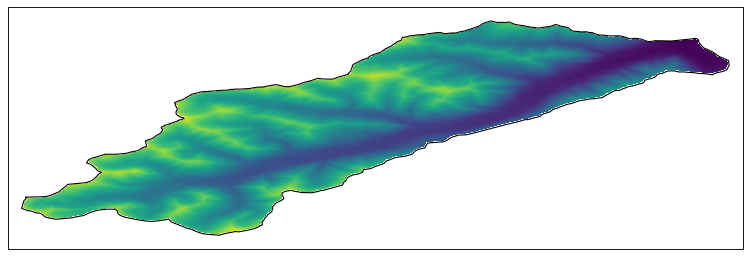

In [7]:
fig_property = dict()
fig_property['figsize'] = (12,4)
fig_property['dpi'] = 80
fig, ax = workflow.plot.get_ax(native_crs, **fig_property)
workflow.plot.dem(dem_profile, dem_raster, ax=ax)
workflow.plot.shply([huc_shape,], native_crs, ax=ax)
plt.show()

## Save DEM and HUC shape files do disk

In [8]:
if not os.path.isfile(filenames['huc']):
    hillslopes.save_shapefile(filenames['huc'], [huc_shape,], native_crs)          

if not os.path.isfile(filenames['dem']):
    hillslopes.save_demfile(filenames['dem'], dem_profile, dem_raster)

# Delineate subcatchments and flowpaths

## Subcatchments and flowpaths source

In [9]:
# NOTE: this needs to be added by Jon!
#
# At this point, we need:
assert(os.path.isfile(filenames['subcatchments'])) # subcatchment shapefile
assert(os.path.isfile(filenames['streams_raster'])) # streams raster
assert(os.path.isfile(filenames['aspect'])) # aspect raster
assert(os.path.isfile(filenames['slope'])) # slope raster
assert(os.path.isfile(filenames['flowpath_length'])) # raster of each pixel's distance to the stream
assert(os.path.isfile(filenames['elev_above_streams'])) # raster of HAND

## Load all subcatchments and flowpaths from source

In [10]:
_, subcatchments = workflow.get_shapes(filenames['subcatchments'], out_crs=native_crs)
print(f'Numbers of subcatchments in basin-{huc}: ', len(subcatchments))

2021-09-23 13:19:25,085 - root - INFO: 
2021-09-23 13:19:25,086 - root - INFO: Loading shapes
2021-09-23 13:19:25,086 - root - INFO: ------------------------------
2021-09-23 13:19:25,087 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:25,136 - root - INFO: ... found 44 shapes
2021-09-23 13:19:25,137 - root - INFO: Converting to shapely
2021-09-23 13:19:25,160 - root - INFO: Converting to requested CRS


Numbers of subcatchments in basin-190604020404:  44


## Validate: plot subcatchments and flowpaths

2021-09-23 13:19:25,325 - root - INFO: BOUNDS: (-149.3337383807433, 68.15814340504932, -148.79207171405866, 68.33619896061079)


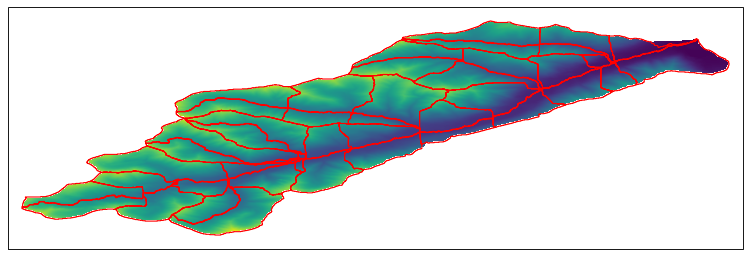

In [11]:
fig_property = dict()
fig_property['figsize'] = (12,4)
fig_property['dpi'] = 80
fig, ax = workflow.plot.get_ax(native_crs, **fig_property)
workflow.plot.dem(dem_profile, dem_raster, ax=ax)
workflow.plot.shply(workflow.utils.flatten(subcatchments),
                    native_crs, ax=ax, color='r')
plt.show()

# Land cover

## Project NNSI land cover and save to disk

In [12]:
# if not os.path.isfile(filenames['land_cover']):
#     landcover.reprojectLandCover(dem_profile, nssiImg_filename, filenames['land_cover'])
# Comment because no NSSI land cover map data

## Validate: plot land cover 

2021-09-23 13:19:25,482 - root - INFO: 
2021-09-23 13:19:25,482 - root - INFO: Loading Raster
2021-09-23 13:19:25,483 - root - INFO: ------------------------------
2021-09-23 13:19:25,483 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:25,484 - root - INFO: Collecting raster
2021-09-23 13:19:25,535 - root - INFO: ... got raster of shape: (570, 1879)
2021-09-23 13:19:25,544 - root - INFO: Masking to shape
2021-09-23 13:19:25,578 - root - INFO:   shape bounds: (-149.32373838074332, 68.16835009523078, -148.80217986384457, 68.32619896061078)
2021-09-23 13:19:25,583 - root - INFO:   casting mask of dtype: float32 to: nan
2021-09-23 13:19:25,584 - root - INFO: ... got raster bounds: (-149.32401615852078, 68.32647673838824, -148.802071714059, 68.16814340504965)
2021-09-23 13:19:25,695 - root - INFO: BOUNDS: (-149.32401615852078, 68.16814340504965, -148.802071714059, 68.32647673838824)


bounds in my_crs: (-149.32373838074332, 68.16835009523078, -148.80217986384457, 68.32619896061078)


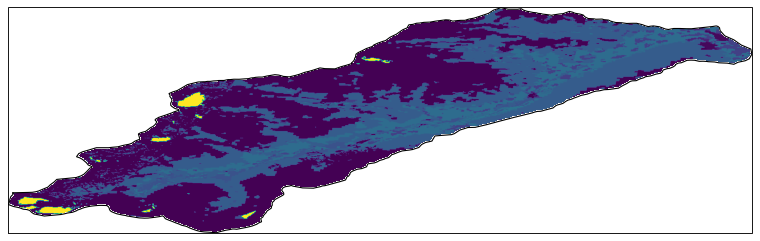

In [13]:
lc_profile, lc_raster = workflow.get_raster_on_shape(filenames['land_cover'],
                                                     huc_shape, huc_crs, 
                                                     mask=True, nodata=np.nan)
fig_property = dict()
fig_property['figsize'] = (12,4)
fig_property['dpi'] = 80

fig, ax = workflow.plot.get_ax(native_crs, **fig_property)
land_cover = workflow.plot.raster(lc_profile, lc_raster, ax=ax)
workflow.plot.shply([huc_shape,], native_crs, ax=ax)
# fig.colorbar(land_cover)
plt.show()

# Determine hillslopes geometry based on flowpaths

**Objective:**  
* Determine a single hillslope profile geometry for each subcatchment (44 in total).

**Objects to obtain:**  
* hillslope length
* an elevation profile along that length
* a width along that length

**Main idea:**
* Regard each subcatchment as a single flowpath, with average properties.

**Method:**  
* Route the surface flow and generate a standard D8<sup>[1]</sup> flowpath direction vector for each pixel of the (smoothed and filled) DEM.
* Form rasters comprising of "length along the flowpath to the stream network" and the corresponding "height above the stream network."
* Bin the rasters according to the flowpath length.
* Average pixels in each bin to determine:
    - hillslope length = 90th % of the maximum flowpath length
    - bins as a function of flowpath length
    - elevation as a function of bin
    - number of pixels in each bin gives an area



**Notes**  
[1] There are eight valid output directions relating to the eight adjacent cells into which flow could travel. This approach is commonly referred to as an [eight-direction (D8) flow model](https://pro.arcgis.com/en/pro-app/latest/tool-reference/raster-analysis/flow-direction.htm). This method models flow direction from each cell to its steepest downslope neighbor. The output is an integer raster whose values range from 1 to 255. The number denotes the flowpath.

## Validate: get hillslope parameters for one subcatchment 

In [14]:
hillslope_demo_pars = hillslopes.parameterizeSubcatchment(
    filenames, huc, subcatch_demo_id,
    target_crs=target_crs,
    hillslope_keep_fraction=hillslope_keep_fraction,
    hillslope_bin_dx=hillslope_bin_dx)

mesh_demo_pars = meshing.parameterizeMesh(hillslope_demo_pars, mesh_dx,
                                       riparian_slope_min=riparian_slope_min,
                                       hillslope_slope_min=hillslope_slope_min,
                                       min_area_ratio=min_area_ratio)
# print(hillslope.keys())

2021-09-23 13:19:25,805 - root - INFO: 
2021-09-23 13:19:25,805 - root - INFO: Loading shapes
2021-09-23 13:19:25,806 - root - INFO: ------------------------------
2021-09-23 13:19:25,806 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:25,811 - root - INFO: ... found 44 shapes
2021-09-23 13:19:25,812 - root - INFO: Converting to shapely
2021-09-23 13:19:25,866 - root - INFO: 
2021-09-23 13:19:25,866 - root - INFO: Loading Raster
2021-09-23 13:19:25,867 - root - INFO: ------------------------------
2021-09-23 13:19:25,867 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:19:25,868 - root - INFO: Collecting raster
2021-09-23 13:19:25,917 - root - INFO: ... got raster of shape: (44, 186)
2021-09-23 13:19:25,927 - root - INFO: Masking to shape
2021-09-23 13:19:25,959 - root - INFO:   shape bounds: (-149.17734949184924, 68.2100878494

bounds in my_crs: (-149.17734949184924, 68.2100878494955, -149.12596060295863, 68.22231007171811)
bounds in my_crs: (-149.17734949184924, 68.2100878494955, -149.12596060295863, 68.22231007171811)
bounds in my_crs: (-149.17734949184924, 68.2100878494955, -149.12596060295863, 68.22231007171811)


2021-09-23 13:19:26,143 - root - INFO:   shape bounds: (-149.17734949184924, 68.2100878494955, -149.12596060295863, 68.22231007171811)
2021-09-23 13:19:26,145 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:26,146 - root - INFO: ... got raster bounds: (-149.177627269627, 68.22231007171811, -149.12596060295863, 68.21008784949548)
2021-09-23 13:19:26,148 - root - INFO: 
2021-09-23 13:19:26,148 - root - INFO: Loading Raster
2021-09-23 13:19:26,149 - root - INFO: ------------------------------
2021-09-23 13:19:26,149 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:26,149 - root - INFO: Collecting raster
2021-09-23 13:19:26,191 - root - INFO: ... got raster of shape: (44, 186)
2021-09-23 13:19:26,200 - root - INFO: Masking to shape
2021-09-23 13:19:26,231 - root - INFO:   shape bounds: (-149.17734949184924, 68.2100878494955, -149.12596060295863, 68.22231007171811)
2021-09-23 13:19:26,23

bounds in my_crs: (-149.17734949184924, 68.2100878494955, -149.12596060295863, 68.22231007171811)


## Validate: plot the hillslope

/Users/3hg/opt/anaconda3/envs/watershed_workflow/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
2021-09-23 13:19:26,397 - root - INFO: BOUNDS: (-149.177627269627, 68.21008784949548, -149.12596060295863, 68.22231007171811)
2021-09-23 13:19:26,500 - root - INFO: BOUNDS: (-149.177627269627, 68.21008784949548, -149.12596060295863, 68.22231007171811)


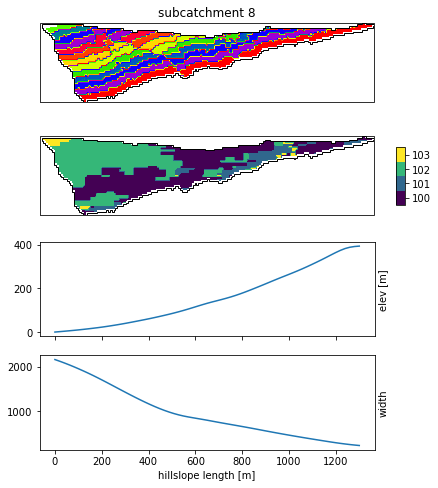

In [15]:
fig = plt.figure(figsize=(6,8))
plt.tight_layout()
gs = gridspec.GridSpec(4,1)
axs = [fig.add_subplot(gs[2,0]), fig.add_subplot(gs[3,0])]
plot.plot(hillslope_demo_pars, mesh_demo_pars, fig=fig, axs=axs)


ax0 = workflow.plot.get_ax(native_crs, fig, axgrid=gs[0,:])
workflow.plot.raster(hillslope_demo_pars['raster_profile'], hillslope_demo_pars['bins'],
                     ax=ax0, cmap='prism')
subcatch = hillslope_demo_pars['subcatchment']
subcatch_crs = hillslope_demo_pars['subcatchment_target_crs']
workflow.plot.shply(subcatch, subcatch_crs, ax=ax0, color='k')
ax0.set_title(f'subcatchment {subcatch_demo_id}')

ax1 = workflow.plot.get_ax(native_crs, fig, axgrid=gs[1,:])
vmin, vmax = min(hillslope_demo_pars['land_cover']), max(hillslope_demo_pars['land_cover'])
cmap = plt.get_cmap(('viridis'),vmax-vmin+1)
lc = workflow.plot.raster(hillslope_demo_pars['raster_profile'],
                          hillslope_demo_pars['land_cover_raster'], 
                          ax=ax1, vmin=vmin-0.5, vmax=vmax+0.5, cmap=cmap)
workflow.plot.shply(subcatch, subcatch_crs, ax=ax1, color='k')
position=fig.add_axes([0.95, 0.55, 0.02,0.1])

fig.colorbar(lc,ticks=np.arange(vmin,vmax+1),cax=position)

plt.show()

## Get parameters for all hillslopes

In [16]:
# hillslope_pars = []
# mesh_pars = []
# subcatch_all_ids = 1+np.arange(len(subcatchments))
# for subcatch_id in subcatch_all_ids:
#     hillslope_pars.append(hillslopes.parameterizeSubcatchment(
#         filenames, huc, subcatch_id,
#         target_crs=target_crs,
#         hillslope_keep_fraction=hillslope_keep_fraction,
#         hillslope_bin_dx=hillslope_bin_dx))
    
# for i in range(len(hillslope_pars)):    
#     mesh_pars.append(meshing.parameterizeMesh(hillslope_pars[i], mesh_dx,
#                                               riparian_slope_min=riparian_slope_min,
#                                               hillslope_slope_min=hillslope_slope_min,
#                                               min_area_ratio=min_area_ratio))

2021-09-23 13:19:26,690 - root - INFO: 
2021-09-23 13:19:26,691 - root - INFO: Loading shapes
2021-09-23 13:19:26,691 - root - INFO: ------------------------------
2021-09-23 13:19:26,692 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:26,697 - root - INFO: ... found 44 shapes
2021-09-23 13:19:26,698 - root - INFO: Converting to shapely
2021-09-23 13:19:26,751 - root - INFO: 
2021-09-23 13:19:26,752 - root - INFO: Loading Raster
2021-09-23 13:19:26,752 - root - INFO: ------------------------------
2021-09-23 13:19:26,752 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:19:26,753 - root - INFO: Collecting raster
2021-09-23 13:19:26,800 - root - INFO: ... got raster of shape: (69, 322)
2021-09-23 13:19:26,809 - root - INFO: Masking to shape
2021-09-23 13:19:26,840 - root - INFO:   shape bounds: (-149.32346060296518, 68.1889767383

bounds in my_crs: (-149.32346060296518, 68.18897673838367, -149.2340161585178, 68.20814340505098)
bounds in my_crs: (-149.32346060296518, 68.18897673838367, -149.2340161585178, 68.20814340505098)
bounds in my_crs: (-149.32346060296518, 68.18897673838367, -149.2340161585178, 68.20814340505098)


2021-09-23 13:19:27,022 - root - INFO:   shape bounds: (-149.32346060296518, 68.18897673838367, -149.2340161585178, 68.20814340505098)
2021-09-23 13:19:27,023 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:27,024 - root - INFO: ... got raster bounds: (-149.32346060296518, 68.20814340505098, -149.23401615851776, 68.18897673838367)
2021-09-23 13:19:27,028 - root - INFO: 
2021-09-23 13:19:27,029 - root - INFO: Loading Raster
2021-09-23 13:19:27,029 - root - INFO: ------------------------------
2021-09-23 13:19:27,029 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:27,030 - root - INFO: Collecting raster
2021-09-23 13:19:27,072 - root - INFO: ... got raster of shape: (69, 322)
2021-09-23 13:19:27,081 - root - INFO: Masking to shape
2021-09-23 13:19:27,114 - root - INFO:   shape bounds: (-149.32346060296518, 68.18897673838367, -149.2340161585178, 68.20814340505098)
2021-09-23 13:19:27,

bounds in my_crs: (-149.32346060296518, 68.18897673838367, -149.2340161585178, 68.20814340505098)
bounds in my_crs: (-149.32346060296518, 68.1800878494945, -149.2315161585177, 68.19758784949508)


2021-09-23 13:19:27,283 - root - INFO:   shape bounds: (-149.32346060296518, 68.1800878494945, -149.2315161585177, 68.19758784949508)
2021-09-23 13:19:27,285 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:27,286 - root - INFO: ... got raster bounds: (-149.32346060296518, 68.19786562727286, -149.23151615851768, 68.1800878494945)
2021-09-23 13:19:27,289 - root - INFO: 
2021-09-23 13:19:27,290 - root - INFO: Loading Raster
2021-09-23 13:19:27,291 - root - INFO: ------------------------------
2021-09-23 13:19:27,292 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:27,293 - root - INFO: Collecting raster
2021-09-23 13:19:27,335 - root - INFO: ... got raster of shape: (64, 331)
2021-09-23 13:19:27,343 - root - INFO: Masking to shape
2021-09-23 13:19:27,373 - root - INFO:   shape bounds: (-149.32346060296518, 68.1800878494945, -149.2315161585177, 68.19758784949508)
2021-09-23 13

bounds in my_crs: (-149.32346060296518, 68.1800878494945, -149.2315161585177, 68.19758784949508)
bounds in my_crs: (-149.32346060296518, 68.1800878494945, -149.2315161585177, 68.19758784949508)
bounds in my_crs: (-149.32346060296518, 68.1800878494945, -149.2315161585177, 68.19758784949508)


2021-09-23 13:19:27,556 - root - INFO:   shape bounds: (-149.32346060296518, 68.1800878494945, -149.2315161585177, 68.19758784949508)
2021-09-23 13:19:27,559 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:27,560 - root - INFO: ... got raster bounds: (-149.32346060296518, 68.19786562727286, -149.23151615851768, 68.1800878494945)
2021-09-23 13:19:27,581 - root - INFO: 
2021-09-23 13:19:27,582 - root - INFO: Loading shapes
2021-09-23 13:19:27,582 - root - INFO: ------------------------------
2021-09-23 13:19:27,582 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:27,587 - root - INFO: ... found 44 shapes
2021-09-23 13:19:27,588 - root - INFO: Converting to shapely
2021-09-23 13:19:27,640 - root - INFO: 
2021-09-23 13:19:27,641 - root - INFO: Loading Raster
2021-09-23 13:19:27,641 - root - INFO: ------------------------------
2021-09-23 13:19:27,641 - root - INFO: Loading file: '../h

bounds in my_crs: (-149.25429393629622, 68.17869896060556, -149.1884606029607, 68.20564340505089)
bounds in my_crs: (-149.25429393629622, 68.17869896060556, -149.1884606029607, 68.20564340505089)
bounds in my_crs: (-149.25429393629622, 68.17869896060556, -149.1884606029607, 68.20564340505089)


2021-09-23 13:19:27,900 - root - INFO:   shape bounds: (-149.25429393629622, 68.17869896060556, -149.1884606029607, 68.20564340505089)
2021-09-23 13:19:27,902 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:27,903 - root - INFO: ... got raster bounds: (-149.25429393629622, 68.20564340505089, -149.1884606029607, 68.17869896060556)
2021-09-23 13:19:27,907 - root - INFO: 
2021-09-23 13:19:27,908 - root - INFO: Loading Raster
2021-09-23 13:19:27,908 - root - INFO: ------------------------------
2021-09-23 13:19:27,908 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:27,909 - root - INFO: Collecting raster
2021-09-23 13:19:27,952 - root - INFO: ... got raster of shape: (97, 237)
2021-09-23 13:19:27,960 - root - INFO: Masking to shape
2021-09-23 13:19:27,992 - root - INFO:   shape bounds: (-149.25429393629622, 68.17869896060556, -149.1884606029607, 68.20564340505089)
2021-09-23 13:19:27,9

bounds in my_crs: (-149.25429393629622, 68.17869896060556, -149.1884606029607, 68.20564340505089)
bounds in my_crs: (-149.27262726963016, 68.1992545161618, -149.2079050474058, 68.21564340505122)


2021-09-23 13:19:28,158 - root - INFO:   shape bounds: (-149.27262726963016, 68.1992545161618, -149.2079050474058, 68.21564340505122)
2021-09-23 13:19:28,161 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:28,162 - root - INFO: ... got raster bounds: (-149.27262726963016, 68.21564340505122, -149.2079050474058, 68.19925451616179)
2021-09-23 13:19:28,165 - root - INFO: 
2021-09-23 13:19:28,165 - root - INFO: Loading Raster
2021-09-23 13:19:28,166 - root - INFO: ------------------------------
2021-09-23 13:19:28,166 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:28,167 - root - INFO: Collecting raster
2021-09-23 13:19:28,209 - root - INFO: ... got raster of shape: (59, 233)
2021-09-23 13:19:28,219 - root - INFO: Masking to shape
2021-09-23 13:19:28,250 - root - INFO:   shape bounds: (-149.27262726963016, 68.1992545161618, -149.2079050474058, 68.21564340505122)
2021-09-23 13

bounds in my_crs: (-149.27262726963016, 68.1992545161618, -149.2079050474058, 68.21564340505122)
bounds in my_crs: (-149.27262726963016, 68.1992545161618, -149.2079050474058, 68.21564340505122)
bounds in my_crs: (-149.27262726963016, 68.1992545161618, -149.2079050474058, 68.21564340505122)


2021-09-23 13:19:28,426 - root - INFO:   shape bounds: (-149.27262726963016, 68.1992545161618, -149.2079050474058, 68.21564340505122)
2021-09-23 13:19:28,428 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:28,429 - root - INFO: ... got raster bounds: (-149.27262726963016, 68.21564340505122, -149.2079050474058, 68.19925451616179)
2021-09-23 13:19:28,449 - root - INFO: 
2021-09-23 13:19:28,450 - root - INFO: Loading shapes
2021-09-23 13:19:28,450 - root - INFO: ------------------------------
2021-09-23 13:19:28,450 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:28,456 - root - INFO: ... found 44 shapes
2021-09-23 13:19:28,456 - root - INFO: Converting to shapely
2021-09-23 13:19:28,508 - root - INFO: 
2021-09-23 13:19:28,508 - root - INFO: Loading Raster
2021-09-23 13:19:28,509 - root - INFO: ------------------------------
2021-09-23 13:19:28,509 - root - INFO: Loading file: '../h

bounds in my_crs: (-149.27568282518584, 68.20731007171761, -149.17123838073792, 68.23425451616296)
bounds in my_crs: (-149.27568282518584, 68.20731007171761, -149.17123838073792, 68.23425451616296)
bounds in my_crs: (-149.27568282518584, 68.20731007171761, -149.17123838073792, 68.23425451616296)


2021-09-23 13:19:28,773 - root - INFO:   shape bounds: (-149.27568282518584, 68.20731007171761, -149.17123838073792, 68.23425451616296)
2021-09-23 13:19:28,775 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:28,776 - root - INFO: ... got raster bounds: (-149.2759606029636, 68.23453229394075, -149.17123838073792, 68.20731007171761)
2021-09-23 13:19:28,781 - root - INFO: 
2021-09-23 13:19:28,782 - root - INFO: Loading Raster
2021-09-23 13:19:28,782 - root - INFO: ------------------------------
2021-09-23 13:19:28,783 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:28,784 - root - INFO: Collecting raster
2021-09-23 13:19:28,825 - root - INFO: ... got raster of shape: (98, 377)
2021-09-23 13:19:28,834 - root - INFO: Masking to shape
2021-09-23 13:19:28,863 - root - INFO:   shape bounds: (-149.27568282518584, 68.20731007171761, -149.17123838073792, 68.23425451616296)
2021-09-23 13:19:28

bounds in my_crs: (-149.27568282518584, 68.20731007171761, -149.17123838073792, 68.23425451616296)
bounds in my_crs: (-149.21262726962817, 68.19675451616172, -149.17179393629348, 68.20953229393992)


2021-09-23 13:19:29,030 - root - INFO:   shape bounds: (-149.21262726962817, 68.19675451616172, -149.17179393629348, 68.20953229393992)
2021-09-23 13:19:29,032 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:29,032 - root - INFO: ... got raster bounds: (-149.21262726962817, 68.20953229393992, -149.17179393629348, 68.19675451616172)
2021-09-23 13:19:29,036 - root - INFO: 
2021-09-23 13:19:29,036 - root - INFO: Loading Raster
2021-09-23 13:19:29,037 - root - INFO: ------------------------------
2021-09-23 13:19:29,037 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:29,038 - root - INFO: Collecting raster
2021-09-23 13:19:29,080 - root - INFO: ... got raster of shape: (46, 147)
2021-09-23 13:19:29,089 - root - INFO: Masking to shape
2021-09-23 13:19:29,121 - root - INFO:   shape bounds: (-149.21262726962817, 68.19675451616172, -149.17179393629348, 68.20953229393992)
2021-09-

bounds in my_crs: (-149.21262726962817, 68.19675451616172, -149.17179393629348, 68.20953229393992)
bounds in my_crs: (-149.21262726962817, 68.19675451616172, -149.17179393629348, 68.20953229393992)
bounds in my_crs: (-149.21262726962817, 68.19675451616172, -149.17179393629348, 68.20953229393992)


2021-09-23 13:19:29,296 - root - INFO:   shape bounds: (-149.21262726962817, 68.19675451616172, -149.17179393629348, 68.20953229393992)
2021-09-23 13:19:29,298 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:29,298 - root - INFO: ... got raster bounds: (-149.21262726962817, 68.20953229393992, -149.17179393629348, 68.19675451616172)
2021-09-23 13:19:29,316 - root - INFO: 
2021-09-23 13:19:29,316 - root - INFO: Loading shapes
2021-09-23 13:19:29,317 - root - INFO: ------------------------------
2021-09-23 13:19:29,317 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:29,323 - root - INFO: ... found 44 shapes
2021-09-23 13:19:29,324 - root - INFO: Converting to shapely
2021-09-23 13:19:29,377 - root - INFO: 
2021-09-23 13:19:29,378 - root - INFO: Loading Raster
2021-09-23 13:19:29,378 - root - INFO: ------------------------------
2021-09-23 13:19:29,379 - root - INFO: Loading file: '.

bounds in my_crs: (-149.17123838073792, 68.19786562727286, -149.11734949184725, 68.22453229394041)
bounds in my_crs: (-149.17123838073792, 68.19786562727286, -149.11734949184725, 68.22453229394041)
bounds in my_crs: (-149.17123838073792, 68.19786562727286, -149.11734949184725, 68.22453229394041)


2021-09-23 13:19:29,641 - root - INFO:   shape bounds: (-149.17123838073792, 68.19786562727286, -149.11734949184725, 68.22453229394041)
2021-09-23 13:19:29,643 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:29,644 - root - INFO: ... got raster bounds: (-149.17123838073792, 68.22453229394041, -149.11734949184725, 68.19786562727286)
2021-09-23 13:19:29,647 - root - INFO: 
2021-09-23 13:19:29,647 - root - INFO: Loading Raster
2021-09-23 13:19:29,648 - root - INFO: ------------------------------
2021-09-23 13:19:29,648 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:29,650 - root - INFO: Collecting raster
2021-09-23 13:19:29,690 - root - INFO: ... got raster of shape: (96, 194)
2021-09-23 13:19:29,699 - root - INFO: Masking to shape
2021-09-23 13:19:29,730 - root - INFO:   shape bounds: (-149.17123838073792, 68.19786562727286, -149.11734949184725, 68.22453229394041)
2021-09-23 13:19:2

bounds in my_crs: (-149.17123838073792, 68.19786562727286, -149.11734949184725, 68.22453229394041)
bounds in my_crs: (-149.17734949184924, 68.2100878494955, -149.12596060295863, 68.22231007171811)


2021-09-23 13:19:29,895 - root - INFO:   shape bounds: (-149.17734949184924, 68.2100878494955, -149.12596060295863, 68.22231007171811)
2021-09-23 13:19:29,897 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:29,897 - root - INFO: ... got raster bounds: (-149.177627269627, 68.22231007171811, -149.12596060295863, 68.21008784949548)
2021-09-23 13:19:29,900 - root - INFO: 
2021-09-23 13:19:29,901 - root - INFO: Loading Raster
2021-09-23 13:19:29,901 - root - INFO: ------------------------------
2021-09-23 13:19:29,901 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:29,902 - root - INFO: Collecting raster
2021-09-23 13:19:29,944 - root - INFO: ... got raster of shape: (44, 186)
2021-09-23 13:19:29,952 - root - INFO: Masking to shape
2021-09-23 13:19:29,980 - root - INFO:   shape bounds: (-149.17734949184924, 68.2100878494955, -149.12596060295863, 68.22231007171811)
2021-09-23 1

bounds in my_crs: (-149.17734949184924, 68.2100878494955, -149.12596060295863, 68.22231007171811)
bounds in my_crs: (-149.17734949184924, 68.2100878494955, -149.12596060295863, 68.22231007171811)
bounds in my_crs: (-149.17734949184924, 68.2100878494955, -149.12596060295863, 68.22231007171811)


2021-09-23 13:19:30,155 - root - INFO:   shape bounds: (-149.17734949184924, 68.2100878494955, -149.12596060295863, 68.22231007171811)
2021-09-23 13:19:30,157 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:30,158 - root - INFO: ... got raster bounds: (-149.177627269627, 68.22231007171811, -149.12596060295863, 68.21008784949548)
2021-09-23 13:19:30,173 - root - INFO: 
2021-09-23 13:19:30,173 - root - INFO: Loading shapes
2021-09-23 13:19:30,173 - root - INFO: ------------------------------
2021-09-23 13:19:30,174 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:30,178 - root - INFO: ... found 44 shapes
2021-09-23 13:19:30,179 - root - INFO: Converting to shapely
2021-09-23 13:19:30,231 - root - INFO: 
2021-09-23 13:19:30,232 - root - INFO: Loading Raster
2021-09-23 13:19:30,232 - root - INFO: ------------------------------
2021-09-23 13:19:30,233 - root - INFO: Loading file: '../h

bounds in my_crs: (-149.12207171406962, 68.21453229394008, -149.11457171406937, 68.2248100717182)
bounds in my_crs: (-149.12207171406962, 68.21453229394008, -149.11457171406937, 68.2248100717182)
bounds in my_crs: (-149.12207171406962, 68.21453229394008, -149.11457171406937, 68.2248100717182)


2021-09-23 13:19:30,486 - root - INFO:   shape bounds: (-149.12207171406962, 68.21453229394008, -149.11457171406937, 68.2248100717182)
2021-09-23 13:19:30,488 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:30,489 - root - INFO: ... got raster bounds: (-149.12207171406962, 68.2248100717182, -149.11457171406937, 68.21453229394008)
2021-09-23 13:19:30,490 - root - INFO: 
2021-09-23 13:19:30,491 - root - INFO: Loading Raster
2021-09-23 13:19:30,491 - root - INFO: ------------------------------
2021-09-23 13:19:30,492 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:30,492 - root - INFO: Collecting raster
2021-09-23 13:19:30,534 - root - INFO: ... got raster of shape: (37, 27)
2021-09-23 13:19:30,543 - root - INFO: Masking to shape
2021-09-23 13:19:30,573 - root - INFO:   shape bounds: (-149.12207171406962, 68.21453229394008, -149.11457171406937, 68.2248100717182)
2021-09-23 13:19:30,57

bounds in my_crs: (-149.12207171406962, 68.21453229394008, -149.11457171406937, 68.2248100717182)
bounds in my_crs: (-149.12234949184742, 68.22453229394041, -149.11429393629157, 68.22981007171836)


2021-09-23 13:19:30,740 - root - INFO:   shape bounds: (-149.12234949184742, 68.22453229394041, -149.11429393629157, 68.22981007171836)
2021-09-23 13:19:30,742 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:30,743 - root - INFO: ... got raster bounds: (-149.12262726962518, 68.22981007171836, -149.11429393629157, 68.22453229394041)
2021-09-23 13:19:30,744 - root - INFO: 
2021-09-23 13:19:30,744 - root - INFO: Loading Raster
2021-09-23 13:19:30,745 - root - INFO: ------------------------------
2021-09-23 13:19:30,745 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:30,746 - root - INFO: Collecting raster
2021-09-23 13:19:30,787 - root - INFO: ... got raster of shape: (19, 30)
2021-09-23 13:19:30,796 - root - INFO: Masking to shape
2021-09-23 13:19:30,827 - root - INFO:   shape bounds: (-149.12234949184742, 68.22453229394041, -149.11429393629157, 68.22981007171836)
2021-09-2

bounds in my_crs: (-149.12234949184742, 68.22453229394041, -149.11429393629157, 68.22981007171836)
bounds in my_crs: (-149.12234949184742, 68.22453229394041, -149.11429393629157, 68.22981007171836)
bounds in my_crs: (-149.12234949184742, 68.22453229394041, -149.11429393629157, 68.22981007171836)


2021-09-23 13:19:31,014 - root - INFO:   shape bounds: (-149.12234949184742, 68.22453229394041, -149.11429393629157, 68.22981007171836)
2021-09-23 13:19:31,017 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:31,018 - root - INFO: ... got raster bounds: (-149.12262726962518, 68.22981007171836, -149.11429393629157, 68.22453229394041)
2021-09-23 13:19:31,030 - root - INFO: 
2021-09-23 13:19:31,030 - root - INFO: Loading shapes
2021-09-23 13:19:31,030 - root - INFO: ------------------------------
2021-09-23 13:19:31,031 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:31,036 - root - INFO: ... found 44 shapes
2021-09-23 13:19:31,036 - root - INFO: Converting to shapely
2021-09-23 13:19:31,092 - root - INFO: 
2021-09-23 13:19:31,093 - root - INFO: Loading Raster
2021-09-23 13:19:31,093 - root - INFO: ------------------------------
2021-09-23 13:19:31,094 - root - INFO: Loading file: '.

bounds in my_crs: (-149.12540504740306, 68.19953229393958, -149.07207171406796, 68.23203229394066)
bounds in my_crs: (-149.12540504740306, 68.19953229393958, -149.07207171406796, 68.23203229394066)
bounds in my_crs: (-149.12540504740306, 68.19953229393958, -149.07207171406796, 68.23203229394066)


2021-09-23 13:19:31,367 - root - INFO:   shape bounds: (-149.12540504740306, 68.19953229393958, -149.07207171406796, 68.23203229394066)
2021-09-23 13:19:31,369 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:31,370 - root - INFO: ... got raster bounds: (-149.12540504740306, 68.23203229394066, -149.07207171406796, 68.19953229393958)
2021-09-23 13:19:31,375 - root - INFO: 
2021-09-23 13:19:31,375 - root - INFO: Loading Raster
2021-09-23 13:19:31,376 - root - INFO: ------------------------------
2021-09-23 13:19:31,376 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:31,377 - root - INFO: Collecting raster
2021-09-23 13:19:31,419 - root - INFO: ... got raster of shape: (117, 192)
2021-09-23 13:19:31,427 - root - INFO: Masking to shape
2021-09-23 13:19:31,457 - root - INFO:   shape bounds: (-149.12540504740306, 68.19953229393958, -149.07207171406796, 68.23203229394066)
2021-09-23 13:19:

bounds in my_crs: (-149.12540504740306, 68.19953229393958, -149.07207171406796, 68.23203229394066)
bounds in my_crs: (-149.1159606029583, 68.2248100717182, -149.08040504740157, 68.25092118283018)


2021-09-23 13:19:31,619 - root - INFO:   shape bounds: (-149.1159606029583, 68.2248100717182, -149.08040504740157, 68.25092118283018)
2021-09-23 13:19:31,621 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:31,622 - root - INFO: ... got raster bounds: (-149.1159606029583, 68.25119896060797, -149.08040504740157, 68.2248100717182)
2021-09-23 13:19:31,626 - root - INFO: 
2021-09-23 13:19:31,626 - root - INFO: Loading Raster
2021-09-23 13:19:31,627 - root - INFO: ------------------------------
2021-09-23 13:19:31,627 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:31,628 - root - INFO: Collecting raster
2021-09-23 13:19:31,673 - root - INFO: ... got raster of shape: (95, 128)
2021-09-23 13:19:31,682 - root - INFO: Masking to shape
2021-09-23 13:19:31,712 - root - INFO:   shape bounds: (-149.1159606029583, 68.2248100717182, -149.08040504740157, 68.25092118283018)
2021-09-23 13:

bounds in my_crs: (-149.1159606029583, 68.2248100717182, -149.08040504740157, 68.25092118283018)
bounds in my_crs: (-149.1159606029583, 68.2248100717182, -149.08040504740157, 68.25092118283018)
bounds in my_crs: (-149.1159606029583, 68.2248100717182, -149.08040504740157, 68.25092118283018)


2021-09-23 13:19:31,897 - root - INFO:   shape bounds: (-149.1159606029583, 68.2248100717182, -149.08040504740157, 68.25092118283018)
2021-09-23 13:19:31,899 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:31,900 - root - INFO: ... got raster bounds: (-149.1159606029583, 68.25119896060797, -149.08040504740157, 68.2248100717182)
2021-09-23 13:19:31,911 - root - INFO: 
2021-09-23 13:19:31,912 - root - INFO: Loading shapes
2021-09-23 13:19:31,913 - root - INFO: ------------------------------
2021-09-23 13:19:31,913 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:31,918 - root - INFO: ... found 44 shapes
2021-09-23 13:19:31,919 - root - INFO: Converting to shapely
2021-09-23 13:19:31,974 - root - INFO: 
2021-09-23 13:19:31,974 - root - INFO: Loading Raster
2021-09-23 13:19:31,975 - root - INFO: ------------------------------
2021-09-23 13:19:31,975 - root - INFO: Loading file: '../hu

bounds in my_crs: (-149.08568282517953, 68.21647673838459, -149.0287383807332, 68.2439767383855)
bounds in my_crs: (-149.08568282517953, 68.21647673838459, -149.0287383807332, 68.2439767383855)
bounds in my_crs: (-149.08568282517953, 68.21647673838459, -149.0287383807332, 68.2439767383855)


2021-09-23 13:19:32,247 - root - INFO:   shape bounds: (-149.08568282517953, 68.21647673838459, -149.0287383807332, 68.2439767383855)
2021-09-23 13:19:32,249 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:32,249 - root - INFO: ... got raster bounds: (-149.0859606029573, 68.2439767383855, -149.0287383807332, 68.21647673838459)
2021-09-23 13:19:32,253 - root - INFO: 
2021-09-23 13:19:32,254 - root - INFO: Loading Raster
2021-09-23 13:19:32,254 - root - INFO: ------------------------------
2021-09-23 13:19:32,254 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:32,255 - root - INFO: Collecting raster
2021-09-23 13:19:32,296 - root - INFO: ... got raster of shape: (99, 206)
2021-09-23 13:19:32,305 - root - INFO: Masking to shape
2021-09-23 13:19:32,337 - root - INFO:   shape bounds: (-149.08568282517953, 68.21647673838459, -149.0287383807332, 68.2439767383855)
2021-09-23 13:19:32,339 -

bounds in my_crs: (-149.08568282517953, 68.21647673838459, -149.0287383807332, 68.2439767383855)
bounds in my_crs: (-149.08984949184634, 68.23231007171844, -149.0304050473999, 68.25092118283018)


2021-09-23 13:19:32,498 - root - INFO:   shape bounds: (-149.08984949184634, 68.23231007171844, -149.0304050473999, 68.25092118283018)
2021-09-23 13:19:32,500 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:32,501 - root - INFO: ... got raster bounds: (-149.0901272696241, 68.25119896060797, -149.0304050473999, 68.23231007171844)
2021-09-23 13:19:32,505 - root - INFO: 
2021-09-23 13:19:32,506 - root - INFO: Loading Raster
2021-09-23 13:19:32,506 - root - INFO: ------------------------------
2021-09-23 13:19:32,507 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:32,508 - root - INFO: Collecting raster
2021-09-23 13:19:32,550 - root - INFO: ... got raster of shape: (68, 215)
2021-09-23 13:19:32,560 - root - INFO: Masking to shape
2021-09-23 13:19:32,591 - root - INFO:   shape bounds: (-149.08984949184634, 68.23231007171844, -149.0304050473999, 68.25092118283018)
2021-09-23 1

bounds in my_crs: (-149.08984949184634, 68.23231007171844, -149.0304050473999, 68.25092118283018)
bounds in my_crs: (-149.08984949184634, 68.23231007171844, -149.0304050473999, 68.25092118283018)
bounds in my_crs: (-149.08984949184634, 68.23231007171844, -149.0304050473999, 68.25092118283018)


2021-09-23 13:19:32,768 - root - INFO:   shape bounds: (-149.08984949184634, 68.23231007171844, -149.0304050473999, 68.25092118283018)
2021-09-23 13:19:32,770 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:32,771 - root - INFO: ... got raster bounds: (-149.0901272696241, 68.25119896060797, -149.0304050473999, 68.23231007171844)
2021-09-23 13:19:32,786 - root - INFO: 
2021-09-23 13:19:32,787 - root - INFO: Loading shapes
2021-09-23 13:19:32,787 - root - INFO: ------------------------------
2021-09-23 13:19:32,788 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:32,793 - root - INFO: ... found 44 shapes
2021-09-23 13:19:32,794 - root - INFO: Converting to shapely
2021-09-23 13:19:32,846 - root - INFO: 
2021-09-23 13:19:32,846 - root - INFO: Loading Raster
2021-09-23 13:19:32,847 - root - INFO: ------------------------------
2021-09-23 13:19:32,847 - root - INFO: Loading file: '../h

bounds in my_crs: (-149.0304050473999, 68.2442545161633, -148.97596060295365, 68.26814340505297)
bounds in my_crs: (-149.0304050473999, 68.2442545161633, -148.97596060295365, 68.26814340505297)
bounds in my_crs: (-149.0304050473999, 68.2442545161633, -148.97596060295365, 68.26814340505297)


2021-09-23 13:19:33,116 - root - INFO:   shape bounds: (-149.0304050473999, 68.2442545161633, -148.97596060295365, 68.26814340505297)
2021-09-23 13:19:33,118 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:33,119 - root - INFO: ... got raster bounds: (-149.0304050473999, 68.26814340505297, -148.97596060295365, 68.24425451616328)
2021-09-23 13:19:33,123 - root - INFO: 
2021-09-23 13:19:33,124 - root - INFO: Loading Raster
2021-09-23 13:19:33,124 - root - INFO: ------------------------------
2021-09-23 13:19:33,125 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:33,126 - root - INFO: Collecting raster
2021-09-23 13:19:33,170 - root - INFO: ... got raster of shape: (86, 196)
2021-09-23 13:19:33,179 - root - INFO: Masking to shape
2021-09-23 13:19:33,211 - root - INFO:   shape bounds: (-149.0304050473999, 68.2442545161633, -148.97596060295365, 68.26814340505297)
2021-09-23 13:19:33,213

bounds in my_crs: (-149.0304050473999, 68.2442545161633, -148.97596060295365, 68.26814340505297)
bounds in my_crs: (-149.0306828251777, 68.2353656272741, -148.97457171406472, 68.25453229394141)


2021-09-23 13:19:33,372 - root - INFO:   shape bounds: (-149.0306828251777, 68.2353656272741, -148.97457171406472, 68.25453229394141)
2021-09-23 13:19:33,374 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:33,375 - root - INFO: ... got raster bounds: (-149.03096060295547, 68.25453229394141, -148.97457171406472, 68.2353656272741)
2021-09-23 13:19:33,378 - root - INFO: 
2021-09-23 13:19:33,378 - root - INFO: Loading Raster
2021-09-23 13:19:33,378 - root - INFO: ------------------------------
2021-09-23 13:19:33,379 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:33,379 - root - INFO: Collecting raster
2021-09-23 13:19:33,419 - root - INFO: ... got raster of shape: (69, 203)
2021-09-23 13:19:33,428 - root - INFO: Masking to shape
2021-09-23 13:19:33,460 - root - INFO:   shape bounds: (-149.0306828251777, 68.2353656272741, -148.97457171406472, 68.25453229394141)
2021-09-23 13

bounds in my_crs: (-149.0306828251777, 68.2353656272741, -148.97457171406472, 68.25453229394141)
bounds in my_crs: (-149.0306828251777, 68.2353656272741, -148.97457171406472, 68.25453229394141)
bounds in my_crs: (-149.0306828251777, 68.2353656272741, -148.97457171406472, 68.25453229394141)


2021-09-23 13:19:33,631 - root - INFO:   shape bounds: (-149.0306828251777, 68.2353656272741, -148.97457171406472, 68.25453229394141)
2021-09-23 13:19:33,633 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:33,634 - root - INFO: ... got raster bounds: (-149.03096060295547, 68.25453229394141, -148.97457171406472, 68.2353656272741)
2021-09-23 13:19:33,650 - root - INFO: 
2021-09-23 13:19:33,650 - root - INFO: Loading shapes
2021-09-23 13:19:33,651 - root - INFO: ------------------------------
2021-09-23 13:19:33,651 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:33,656 - root - INFO: ... found 44 shapes
2021-09-23 13:19:33,657 - root - INFO: Converting to shapely
2021-09-23 13:19:33,708 - root - INFO: 
2021-09-23 13:19:33,709 - root - INFO: Loading Raster
2021-09-23 13:19:33,709 - root - INFO: ------------------------------
2021-09-23 13:19:33,710 - root - INFO: Loading file: '../h

bounds in my_crs: (-149.01318282517713, 68.25592118283035, -148.94040504739692, 68.28064340505338)
bounds in my_crs: (-149.01318282517713, 68.25592118283035, -148.94040504739692, 68.28064340505338)
bounds in my_crs: (-149.01318282517713, 68.25592118283035, -148.94040504739692, 68.28064340505338)


2021-09-23 13:19:33,973 - root - INFO:   shape bounds: (-149.01318282517713, 68.25592118283035, -148.94040504739692, 68.28064340505338)
2021-09-23 13:19:33,975 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:33,976 - root - INFO: ... got raster bounds: (-149.0134606029549, 68.28064340505338, -148.94040504739692, 68.25592118283033)
2021-09-23 13:19:33,980 - root - INFO: 
2021-09-23 13:19:33,981 - root - INFO: Loading Raster
2021-09-23 13:19:33,981 - root - INFO: ------------------------------
2021-09-23 13:19:33,981 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:33,982 - root - INFO: Collecting raster
2021-09-23 13:19:34,024 - root - INFO: ... got raster of shape: (89, 263)
2021-09-23 13:19:34,032 - root - INFO: Masking to shape
2021-09-23 13:19:34,064 - root - INFO:   shape bounds: (-149.01318282517713, 68.25592118283035, -148.94040504739692, 68.28064340505338)
2021-09-23 13:19:34

bounds in my_crs: (-149.01318282517713, 68.25592118283035, -148.94040504739692, 68.28064340505338)
bounds in my_crs: (-148.97623838073144, 68.24786562727452, -148.92318282517414, 68.27564340505322)


2021-09-23 13:19:34,226 - root - INFO:   shape bounds: (-148.97623838073144, 68.24786562727452, -148.92318282517414, 68.27564340505322)
2021-09-23 13:19:34,228 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:34,229 - root - INFO: ... got raster bounds: (-148.97623838073144, 68.27564340505322, -148.92318282517414, 68.24786562727452)
2021-09-23 13:19:34,232 - root - INFO: 
2021-09-23 13:19:34,233 - root - INFO: Loading Raster
2021-09-23 13:19:34,233 - root - INFO: ------------------------------
2021-09-23 13:19:34,233 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:34,234 - root - INFO: Collecting raster
2021-09-23 13:19:34,276 - root - INFO: ... got raster of shape: (100, 191)
2021-09-23 13:19:34,284 - root - INFO: Masking to shape
2021-09-23 13:19:34,315 - root - INFO:   shape bounds: (-148.97623838073144, 68.24786562727452, -148.92318282517414, 68.27564340505322)
2021-09

bounds in my_crs: (-148.97623838073144, 68.24786562727452, -148.92318282517414, 68.27564340505322)
bounds in my_crs: (-148.97623838073144, 68.24786562727452, -148.92318282517414, 68.27564340505322)
bounds in my_crs: (-148.97623838073144, 68.24786562727452, -148.92318282517414, 68.27564340505322)


2021-09-23 13:19:34,492 - root - INFO:   shape bounds: (-148.97623838073144, 68.24786562727452, -148.92318282517414, 68.27564340505322)
2021-09-23 13:19:34,494 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:34,495 - root - INFO: ... got raster bounds: (-148.97623838073144, 68.27564340505322, -148.92318282517414, 68.24786562727452)
2021-09-23 13:19:34,510 - root - INFO: 
2021-09-23 13:19:34,511 - root - INFO: Loading shapes
2021-09-23 13:19:34,511 - root - INFO: ------------------------------
2021-09-23 13:19:34,512 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:34,516 - root - INFO: ... found 44 shapes
2021-09-23 13:19:34,517 - root - INFO: Converting to shapely
2021-09-23 13:19:34,570 - root - INFO: 
2021-09-23 13:19:34,571 - root - INFO: Loading Raster
2021-09-23 13:19:34,571 - root - INFO: ------------------------------
2021-09-23 13:19:34,572 - root - INFO: Loading file: '.

bounds in my_crs: (-148.95179393628618, 68.27647673838658, -148.89679393628435, 68.30203229394299)
bounds in my_crs: (-148.95179393628618, 68.27647673838658, -148.89679393628435, 68.30203229394299)
bounds in my_crs: (-148.95179393628618, 68.27647673838658, -148.89679393628435, 68.30203229394299)


2021-09-23 13:19:34,839 - root - INFO:   shape bounds: (-148.95179393628618, 68.27647673838658, -148.89679393628435, 68.30203229394299)
2021-09-23 13:19:34,840 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:34,841 - root - INFO: ... got raster bounds: (-148.95179393628618, 68.30203229394299, -148.89679393628435, 68.27647673838658)
2021-09-23 13:19:34,845 - root - INFO: 
2021-09-23 13:19:34,845 - root - INFO: Loading Raster
2021-09-23 13:19:34,846 - root - INFO: ------------------------------
2021-09-23 13:19:34,846 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:34,847 - root - INFO: Collecting raster
2021-09-23 13:19:34,888 - root - INFO: ... got raster of shape: (92, 198)
2021-09-23 13:19:34,897 - root - INFO: Masking to shape
2021-09-23 13:19:34,928 - root - INFO:   shape bounds: (-148.95179393628618, 68.27647673838658, -148.89679393628435, 68.30203229394299)
2021-09-23 13:19:3

bounds in my_crs: (-148.95179393628618, 68.27647673838658, -148.89679393628435, 68.30203229394299)
bounds in my_crs: (-148.94012726961913, 68.26425451616396, -148.88790504739518, 68.29147673838708)


2021-09-23 13:19:35,092 - root - INFO:   shape bounds: (-148.94012726961913, 68.26425451616396, -148.88790504739518, 68.29147673838708)
2021-09-23 13:19:35,094 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:35,095 - root - INFO: ... got raster bounds: (-148.94012726961913, 68.29147673838708, -148.88790504739518, 68.26425451616394)
2021-09-23 13:19:35,099 - root - INFO: 
2021-09-23 13:19:35,100 - root - INFO: Loading Raster
2021-09-23 13:19:35,100 - root - INFO: ------------------------------
2021-09-23 13:19:35,101 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:35,101 - root - INFO: Collecting raster
2021-09-23 13:19:35,144 - root - INFO: ... got raster of shape: (98, 188)
2021-09-23 13:19:35,153 - root - INFO: Masking to shape
2021-09-23 13:19:35,184 - root - INFO:   shape bounds: (-148.94012726961913, 68.26425451616396, -148.88790504739518, 68.29147673838708)
2021-09-

bounds in my_crs: (-148.94012726961913, 68.26425451616396, -148.88790504739518, 68.29147673838708)
bounds in my_crs: (-148.94012726961913, 68.26425451616396, -148.88790504739518, 68.29147673838708)
bounds in my_crs: (-148.94012726961913, 68.26425451616396, -148.88790504739518, 68.29147673838708)


2021-09-23 13:19:35,360 - root - INFO:   shape bounds: (-148.94012726961913, 68.26425451616396, -148.88790504739518, 68.29147673838708)
2021-09-23 13:19:35,362 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:35,363 - root - INFO: ... got raster bounds: (-148.94012726961913, 68.29147673838708, -148.88790504739518, 68.26425451616394)
2021-09-23 13:19:35,379 - root - INFO: 
2021-09-23 13:19:35,379 - root - INFO: Loading shapes
2021-09-23 13:19:35,379 - root - INFO: ------------------------------
2021-09-23 13:19:35,380 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:35,385 - root - INFO: ... found 44 shapes
2021-09-23 13:19:35,385 - root - INFO: Converting to shapely
2021-09-23 13:19:35,438 - root - INFO: 
2021-09-23 13:19:35,439 - root - INFO: Loading Raster
2021-09-23 13:19:35,439 - root - INFO: ------------------------------
2021-09-23 13:19:35,440 - root - INFO: Loading file: '.

bounds in my_crs: (-148.89679393628435, 68.27425451616429, -148.8701272696168, 68.29592118283168)
bounds in my_crs: (-148.89679393628435, 68.27425451616429, -148.8701272696168, 68.29592118283168)
bounds in my_crs: (-148.89679393628435, 68.27425451616429, -148.8701272696168, 68.29592118283168)


2021-09-23 13:19:35,700 - root - INFO:   shape bounds: (-148.89679393628435, 68.27425451616429, -148.8701272696168, 68.29592118283168)
2021-09-23 13:19:35,702 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:35,703 - root - INFO: ... got raster bounds: (-148.89679393628435, 68.29619896060946, -148.8701272696168, 68.27425451616429)
2021-09-23 13:19:35,706 - root - INFO: 
2021-09-23 13:19:35,706 - root - INFO: Loading Raster
2021-09-23 13:19:35,707 - root - INFO: ------------------------------
2021-09-23 13:19:35,707 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:35,709 - root - INFO: Collecting raster
2021-09-23 13:19:35,751 - root - INFO: ... got raster of shape: (79, 96)
2021-09-23 13:19:35,759 - root - INFO: Masking to shape
2021-09-23 13:19:35,789 - root - INFO:   shape bounds: (-148.89679393628435, 68.27425451616429, -148.8701272696168, 68.29592118283168)
2021-09-23 13:19:35,79

bounds in my_crs: (-148.89679393628435, 68.27425451616429, -148.8701272696168, 68.29592118283168)
bounds in my_crs: (-148.9109606029515, 68.29175451616487, -148.88707171406182, 68.30147673838741)


2021-09-23 13:19:35,952 - root - INFO: 
2021-09-23 13:19:35,953 - root - INFO: Loading Raster
2021-09-23 13:19:35,953 - root - INFO: ------------------------------
2021-09-23 13:19:35,953 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:35,954 - root - INFO: Collecting raster
2021-09-23 13:19:35,995 - root - INFO: ... got raster of shape: (35, 86)
2021-09-23 13:19:36,004 - root - INFO: Masking to shape
2021-09-23 13:19:36,034 - root - INFO:   shape bounds: (-148.9109606029515, 68.29175451616487, -148.88707171406182, 68.30147673838741)
2021-09-23 13:19:36,036 - root - INFO:   casting mask of dtype: float32 to: -999.0
2021-09-23 13:19:36,037 - root - INFO: ... got raster bounds: (-148.9109606029515, 68.30147673838741, -148.88707171406182, 68.29175451616486)
2021-09-23 13:19:36,039 - root - INFO: 
2021-09-23 13:19:36,040 - root - INFO: Loading Raster
2021-09-23 13:19:36,041 - root - INFO: ----------------

bounds in my_crs: (-148.9109606029515, 68.29175451616487, -148.88707171406182, 68.30147673838741)
bounds in my_crs: (-148.9109606029515, 68.29175451616487, -148.88707171406182, 68.30147673838741)
bounds in my_crs: (-148.9109606029515, 68.29175451616487, -148.88707171406182, 68.30147673838741)


2021-09-23 13:19:36,207 - root - INFO:   shape bounds: (-148.9109606029515, 68.29175451616487, -148.88707171406182, 68.30147673838741)
2021-09-23 13:19:36,208 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:36,209 - root - INFO: ... got raster bounds: (-148.9109606029515, 68.30147673838741, -148.88707171406182, 68.29175451616486)
2021-09-23 13:19:36,223 - root - INFO: 
2021-09-23 13:19:36,223 - root - INFO: Loading shapes
2021-09-23 13:19:36,224 - root - INFO: ------------------------------
2021-09-23 13:19:36,224 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:36,229 - root - INFO: ... found 44 shapes
2021-09-23 13:19:36,230 - root - INFO: Converting to shapely
2021-09-23 13:19:36,282 - root - INFO: 
2021-09-23 13:19:36,283 - root - INFO: Loading Raster
2021-09-23 13:19:36,283 - root - INFO: ------------------------------
2021-09-23 13:19:36,284 - root - INFO: Loading file: '../

bounds in my_crs: (-148.88596060295066, 68.27925451616446, -148.8023494918368, 68.31314340505446)
bounds in my_crs: (-148.88596060295066, 68.27925451616446, -148.8023494918368, 68.31314340505446)
bounds in my_crs: (-148.88596060295066, 68.27925451616446, -148.8023494918368, 68.31314340505446)


2021-09-23 13:19:36,533 - root - INFO: Masking to shape
2021-09-23 13:19:36,566 - root - INFO:   shape bounds: (-148.88596060295066, 68.27925451616446, -148.8023494918368, 68.31314340505446)
2021-09-23 13:19:36,568 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:36,569 - root - INFO: ... got raster bounds: (-148.88596060295066, 68.31314340505446, -148.80234949183676, 68.27925451616444)
2021-09-23 13:19:36,574 - root - INFO: 
2021-09-23 13:19:36,575 - root - INFO: Loading Raster
2021-09-23 13:19:36,575 - root - INFO: ------------------------------
2021-09-23 13:19:36,576 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:36,580 - root - INFO: Collecting raster
2021-09-23 13:19:36,622 - root - INFO: ... got raster of shape: (122, 301)
2021-09-23 13:19:36,631 - root - INFO: Masking to shape
2021-09-23 13:19:36,663 - root - INFO:   shape bounds: (-148.88596060295066, 68.27925451616446, -1

bounds in my_crs: (-148.88596060295066, 68.27925451616446, -148.8023494918368, 68.31314340505446)
bounds in my_crs: (-148.89068282517306, 68.29619896060946, -148.83429393628228, 68.31536562727676)


2021-09-23 13:19:36,838 - root - INFO:   shape bounds: (-148.89068282517306, 68.29619896060946, -148.83429393628228, 68.31536562727676)
2021-09-23 13:19:36,840 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:36,841 - root - INFO: ... got raster bounds: (-148.89096060295083, 68.31536562727676, -148.83429393628228, 68.29619896060946)
2021-09-23 13:19:36,843 - root - INFO: 
2021-09-23 13:19:36,844 - root - INFO: Loading Raster
2021-09-23 13:19:36,844 - root - INFO: ------------------------------
2021-09-23 13:19:36,845 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:36,845 - root - INFO: Collecting raster
2021-09-23 13:19:36,888 - root - INFO: ... got raster of shape: (69, 204)
2021-09-23 13:19:36,897 - root - INFO: Masking to shape
2021-09-23 13:19:36,927 - root - INFO:   shape bounds: (-148.89068282517306, 68.29619896060946, -148.83429393628228, 68.31536562727676)
2021-09-

bounds in my_crs: (-148.89068282517306, 68.29619896060946, -148.83429393628228, 68.31536562727676)
bounds in my_crs: (-148.89068282517306, 68.29619896060946, -148.83429393628228, 68.31536562727676)
bounds in my_crs: (-148.89068282517306, 68.29619896060946, -148.83429393628228, 68.31536562727676)


2021-09-23 13:19:37,107 - root - INFO:   shape bounds: (-148.89068282517306, 68.29619896060946, -148.83429393628228, 68.31536562727676)
2021-09-23 13:19:37,109 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:37,110 - root - INFO: ... got raster bounds: (-148.89096060295083, 68.31536562727676, -148.83429393628228, 68.29619896060946)
2021-09-23 13:19:37,126 - root - INFO: 
2021-09-23 13:19:37,127 - root - INFO: Loading shapes
2021-09-23 13:19:37,127 - root - INFO: ------------------------------
2021-09-23 13:19:37,128 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:37,132 - root - INFO: ... found 44 shapes
2021-09-23 13:19:37,133 - root - INFO: Converting to shapely
2021-09-23 13:19:37,184 - root - INFO: 
2021-09-23 13:19:37,185 - root - INFO: Loading Raster
2021-09-23 13:19:37,185 - root - INFO: ------------------------------
2021-09-23 13:19:37,186 - root - INFO: Loading file: '.

bounds in my_crs: (-149.20290504740564, 68.22592118282935, -149.1117939362915, 68.26036562727494)
bounds in my_crs: (-149.20290504740564, 68.22592118282935, -149.1117939362915, 68.26036562727494)
bounds in my_crs: (-149.20290504740564, 68.22592118282935, -149.1117939362915, 68.26036562727494)


2021-09-23 13:19:37,448 - root - INFO:   shape bounds: (-149.20290504740564, 68.22592118282935, -149.1117939362915, 68.26036562727494)
2021-09-23 13:19:37,450 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:37,451 - root - INFO: ... got raster bounds: (-149.20290504740564, 68.26036562727494, -149.1117939362915, 68.22592118282935)
2021-09-23 13:19:37,455 - root - INFO: 
2021-09-23 13:19:37,456 - root - INFO: Loading Raster
2021-09-23 13:19:37,456 - root - INFO: ------------------------------
2021-09-23 13:19:37,456 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:37,458 - root - INFO: Collecting raster
2021-09-23 13:19:37,500 - root - INFO: ... got raster of shape: (124, 328)
2021-09-23 13:19:37,509 - root - INFO: Masking to shape
2021-09-23 13:19:37,542 - root - INFO:   shape bounds: (-149.20290504740564, 68.22592118282935, -149.1117939362915, 68.26036562727494)
2021-09-23 13:19:37,

bounds in my_crs: (-149.20290504740564, 68.22592118282935, -149.1117939362915, 68.26036562727494)
bounds in my_crs: (-149.2034606029612, 68.22814340505164, -149.11734949184725, 68.25453229394141)


2021-09-23 13:19:37,711 - root - INFO:   shape bounds: (-149.2034606029612, 68.22814340505164, -149.11734949184725, 68.25453229394141)
2021-09-23 13:19:37,713 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:37,713 - root - INFO: ... got raster bounds: (-149.2034606029612, 68.25453229394141, -149.11734949184722, 68.22814340505164)
2021-09-23 13:19:37,716 - root - INFO: 
2021-09-23 13:19:37,717 - root - INFO: Loading Raster
2021-09-23 13:19:37,717 - root - INFO: ------------------------------
2021-09-23 13:19:37,717 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:37,719 - root - INFO: Collecting raster
2021-09-23 13:19:37,759 - root - INFO: ... got raster of shape: (95, 310)
2021-09-23 13:19:37,769 - root - INFO: Masking to shape
2021-09-23 13:19:37,799 - root - INFO:   shape bounds: (-149.2034606029612, 68.22814340505164, -149.11734949184725, 68.25453229394141)
2021-09-23 

bounds in my_crs: (-149.2034606029612, 68.22814340505164, -149.11734949184725, 68.25453229394141)
bounds in my_crs: (-149.2034606029612, 68.22814340505164, -149.11734949184725, 68.25453229394141)
bounds in my_crs: (-149.2034606029612, 68.22814340505164, -149.11734949184725, 68.25453229394141)


2021-09-23 13:19:37,980 - root - INFO:   shape bounds: (-149.2034606029612, 68.22814340505164, -149.11734949184725, 68.25453229394141)
2021-09-23 13:19:37,982 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:37,983 - root - INFO: ... got raster bounds: (-149.2034606029612, 68.25453229394141, -149.11734949184722, 68.22814340505164)
2021-09-23 13:19:38,006 - root - INFO: 
2021-09-23 13:19:38,007 - root - INFO: Loading shapes
2021-09-23 13:19:38,008 - root - INFO: ------------------------------
2021-09-23 13:19:38,008 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:38,013 - root - INFO: ... found 44 shapes
2021-09-23 13:19:38,014 - root - INFO: Converting to shapely
2021-09-23 13:19:38,065 - root - INFO: 
2021-09-23 13:19:38,065 - root - INFO: Loading Raster
2021-09-23 13:19:38,066 - root - INFO: ------------------------------
2021-09-23 13:19:38,066 - root - INFO: Loading file: '../

bounds in my_crs: (-149.04318282517812, 68.30758784949873, -148.94151615850808, 68.32619896061045)
bounds in my_crs: (-149.04318282517812, 68.30758784949873, -148.94151615850808, 68.32619896061045)
bounds in my_crs: (-149.04318282517812, 68.30758784949873, -148.94151615850808, 68.32619896061045)


2021-09-23 13:19:38,331 - root - INFO:   shape bounds: (-149.04318282517812, 68.30758784949873, -148.94151615850808, 68.32619896061045)
2021-09-23 13:19:38,333 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:38,334 - root - INFO: ... got raster bounds: (-149.0434606029559, 68.32619896061045, -148.94151615850805, 68.30758784949873)
2021-09-23 13:19:38,337 - root - INFO: 
2021-09-23 13:19:38,338 - root - INFO: Loading Raster
2021-09-23 13:19:38,338 - root - INFO: ------------------------------
2021-09-23 13:19:38,339 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:38,339 - root - INFO: Collecting raster
2021-09-23 13:19:38,383 - root - INFO: ... got raster of shape: (67, 367)
2021-09-23 13:19:38,392 - root - INFO: Masking to shape
2021-09-23 13:19:38,421 - root - INFO:   shape bounds: (-149.04318282517812, 68.30758784949873, -148.94151615850808, 68.32619896061045)
2021-09-23 13:19:38

bounds in my_crs: (-149.04318282517812, 68.30758784949873, -148.94151615850808, 68.32619896061045)
bounds in my_crs: (-149.04318282517812, 68.29814340505396, -148.94207171406364, 68.31286562727668)


2021-09-23 13:19:38,585 - root - INFO:   shape bounds: (-149.04318282517812, 68.29814340505396, -148.94207171406364, 68.31286562727668)
2021-09-23 13:19:38,587 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:38,588 - root - INFO: ... got raster bounds: (-149.0434606029559, 68.31286562727668, -148.94207171406364, 68.29814340505396)
2021-09-23 13:19:38,592 - root - INFO: 
2021-09-23 13:19:38,592 - root - INFO: Loading Raster
2021-09-23 13:19:38,593 - root - INFO: ------------------------------
2021-09-23 13:19:38,593 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:38,593 - root - INFO: Collecting raster
2021-09-23 13:19:38,644 - root - INFO: ... got raster of shape: (53, 365)
2021-09-23 13:19:38,652 - root - INFO: Masking to shape
2021-09-23 13:19:38,682 - root - INFO:   shape bounds: (-149.04318282517812, 68.29814340505396, -148.94207171406364, 68.31286562727668)
2021-09-2

bounds in my_crs: (-149.04318282517812, 68.29814340505396, -148.94207171406364, 68.31286562727668)
bounds in my_crs: (-149.04318282517812, 68.29814340505396, -148.94207171406364, 68.31286562727668)
bounds in my_crs: (-149.04318282517812, 68.29814340505396, -148.94207171406364, 68.31286562727668)


2021-09-23 13:19:38,858 - root - INFO:   shape bounds: (-149.04318282517812, 68.29814340505396, -148.94207171406364, 68.31286562727668)
2021-09-23 13:19:38,860 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:38,861 - root - INFO: ... got raster bounds: (-149.0434606029559, 68.31286562727668, -148.94207171406364, 68.29814340505396)
2021-09-23 13:19:38,882 - root - INFO: 
2021-09-23 13:19:38,882 - root - INFO: Loading shapes
2021-09-23 13:19:38,883 - root - INFO: ------------------------------
2021-09-23 13:19:38,883 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:38,888 - root - INFO: ... found 44 shapes
2021-09-23 13:19:38,888 - root - INFO: Converting to shapely
2021-09-23 13:19:38,942 - root - INFO: 
2021-09-23 13:19:38,943 - root - INFO: Loading Raster
2021-09-23 13:19:38,944 - root - INFO: ------------------------------
2021-09-23 13:19:38,944 - root - INFO: Loading file: '..

bounds in my_crs: (-148.94179393628585, 68.29203229394265, -148.88373838072837, 68.32369896061037)
bounds in my_crs: (-148.94179393628585, 68.29203229394265, -148.88373838072837, 68.32369896061037)
bounds in my_crs: (-148.94179393628585, 68.29203229394265, -148.88373838072837, 68.32369896061037)


2021-09-23 13:19:39,220 - root - INFO:   shape bounds: (-148.94179393628585, 68.29203229394265, -148.88373838072837, 68.32369896061037)
2021-09-23 13:19:39,223 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:39,223 - root - INFO: ... got raster bounds: (-148.94179393628585, 68.32369896061037, -148.88373838072837, 68.29203229394265)
2021-09-23 13:19:39,226 - root - INFO: 
2021-09-23 13:19:39,227 - root - INFO: Loading Raster
2021-09-23 13:19:39,227 - root - INFO: ------------------------------
2021-09-23 13:19:39,228 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:39,231 - root - INFO: Collecting raster
2021-09-23 13:19:39,274 - root - INFO: ... got raster of shape: (114, 209)
2021-09-23 13:19:39,283 - root - INFO: Masking to shape
2021-09-23 13:19:39,315 - root - INFO:   shape bounds: (-148.94179393628585, 68.29203229394265, -148.88373838072837, 68.32369896061037)
2021-09-23 13:19:

bounds in my_crs: (-148.94179393628585, 68.29203229394265, -148.88373838072837, 68.32369896061037)
bounds in my_crs: (-148.942905047397, 68.29619896060946, -148.8895717140619, 68.30925451616545)


2021-09-23 13:19:39,478 - root - INFO:   shape bounds: (-148.942905047397, 68.29619896060946, -148.8895717140619, 68.30925451616545)
2021-09-23 13:19:39,480 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:39,481 - root - INFO: ... got raster bounds: (-148.942905047397, 68.30953229394324, -148.8895717140619, 68.29619896060946)
2021-09-23 13:19:39,484 - root - INFO: 
2021-09-23 13:19:39,484 - root - INFO: Loading Raster
2021-09-23 13:19:39,485 - root - INFO: ------------------------------
2021-09-23 13:19:39,485 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:39,486 - root - INFO: Collecting raster
2021-09-23 13:19:39,528 - root - INFO: ... got raster of shape: (48, 192)
2021-09-23 13:19:39,536 - root - INFO: Masking to shape
2021-09-23 13:19:39,566 - root - INFO:   shape bounds: (-148.942905047397, 68.29619896060946, -148.8895717140619, 68.30925451616545)
2021-09-23 13:19:

bounds in my_crs: (-148.942905047397, 68.29619896060946, -148.8895717140619, 68.30925451616545)
bounds in my_crs: (-148.942905047397, 68.29619896060946, -148.8895717140619, 68.30925451616545)
bounds in my_crs: (-148.942905047397, 68.29619896060946, -148.8895717140619, 68.30925451616545)


2021-09-23 13:19:39,745 - root - INFO:   shape bounds: (-148.942905047397, 68.29619896060946, -148.8895717140619, 68.30925451616545)
2021-09-23 13:19:39,747 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:39,748 - root - INFO: ... got raster bounds: (-148.942905047397, 68.30953229394324, -148.8895717140619, 68.29619896060946)
2021-09-23 13:19:39,759 - root - INFO: 
2021-09-23 13:19:39,759 - root - INFO: Loading shapes
2021-09-23 13:19:39,760 - root - INFO: ------------------------------
2021-09-23 13:19:39,760 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:39,765 - root - INFO: ... found 44 shapes
2021-09-23 13:19:39,766 - root - INFO: Converting to shapely
2021-09-23 13:19:39,817 - root - INFO: 
2021-09-23 13:19:39,818 - root - INFO: Loading Raster
2021-09-23 13:19:39,818 - root - INFO: ------------------------------
2021-09-23 13:19:39,819 - root - INFO: Loading file: '../huc/

bounds in my_crs: (-149.08262726962386, 68.28119896060896, -148.9987383807322, 68.2995322939429)
bounds in my_crs: (-149.08262726962386, 68.28119896060896, -148.9987383807322, 68.2995322939429)
bounds in my_crs: (-149.08262726962386, 68.28119896060896, -148.9987383807322, 68.2995322939429)


2021-09-23 13:19:40,083 - root - INFO:   shape bounds: (-149.08262726962386, 68.28119896060896, -148.9987383807322, 68.2995322939429)
2021-09-23 13:19:40,085 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:40,085 - root - INFO: ... got raster bounds: (-149.08262726962386, 68.2995322939429, -148.9987383807322, 68.28119896060896)
2021-09-23 13:19:40,089 - root - INFO: 
2021-09-23 13:19:40,089 - root - INFO: Loading Raster
2021-09-23 13:19:40,090 - root - INFO: ------------------------------
2021-09-23 13:19:40,090 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:40,092 - root - INFO: Collecting raster
2021-09-23 13:19:40,134 - root - INFO: ... got raster of shape: (66, 302)
2021-09-23 13:19:40,143 - root - INFO: Masking to shape
2021-09-23 13:19:40,174 - root - INFO:   shape bounds: (-149.08262726962386, 68.28119896060896, -148.9987383807322, 68.2995322939429)
2021-09-23 13:19:40,176 

bounds in my_crs: (-149.08262726962386, 68.28119896060896, -148.9987383807322, 68.2995322939429)
bounds in my_crs: (-149.08012726962377, 68.29147673838708, -148.9984606029544, 68.3123100717211)


2021-09-23 13:19:40,337 - root - INFO:   shape bounds: (-149.08012726962377, 68.29147673838708, -148.9984606029544, 68.3123100717211)
2021-09-23 13:19:40,339 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:40,340 - root - INFO: ... got raster bounds: (-149.08012726962377, 68.3123100717211, -148.9984606029544, 68.29147673838708)
2021-09-23 13:19:40,343 - root - INFO: 
2021-09-23 13:19:40,344 - root - INFO: Loading Raster
2021-09-23 13:19:40,345 - root - INFO: ------------------------------
2021-09-23 13:19:40,345 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:40,346 - root - INFO: Collecting raster
2021-09-23 13:19:40,386 - root - INFO: ... got raster of shape: (75, 294)
2021-09-23 13:19:40,394 - root - INFO: Masking to shape
2021-09-23 13:19:40,424 - root - INFO:   shape bounds: (-149.08012726962377, 68.29147673838708, -148.9984606029544, 68.3123100717211)
2021-09-23 13:

bounds in my_crs: (-149.08012726962377, 68.29147673838708, -148.9984606029544, 68.3123100717211)
bounds in my_crs: (-149.08012726962377, 68.29147673838708, -148.9984606029544, 68.3123100717211)
bounds in my_crs: (-149.08012726962377, 68.29147673838708, -148.9984606029544, 68.3123100717211)


2021-09-23 13:19:40,601 - root - INFO:   shape bounds: (-149.08012726962377, 68.29147673838708, -148.9984606029544, 68.3123100717211)
2021-09-23 13:19:40,603 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:40,604 - root - INFO: ... got raster bounds: (-149.08012726962377, 68.3123100717211, -148.9984606029544, 68.29147673838708)
2021-09-23 13:19:40,619 - root - INFO: 
2021-09-23 13:19:40,619 - root - INFO: Loading shapes
2021-09-23 13:19:40,620 - root - INFO: ------------------------------
2021-09-23 13:19:40,620 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:40,625 - root - INFO: ... found 44 shapes
2021-09-23 13:19:40,625 - root - INFO: Converting to shapely
2021-09-23 13:19:40,680 - root - INFO: 
2021-09-23 13:19:40,681 - root - INFO: Loading Raster
2021-09-23 13:19:40,681 - root - INFO: ------------------------------
2021-09-23 13:19:40,682 - root - INFO: Loading file: '../hu

bounds in my_crs: (-149.03457171406671, 68.27508784949765, -148.94012726961913, 68.29703229394282)
bounds in my_crs: (-149.03457171406671, 68.27508784949765, -148.94012726961913, 68.29703229394282)
bounds in my_crs: (-149.03457171406671, 68.27508784949765, -148.94012726961913, 68.29703229394282)


2021-09-23 13:19:40,957 - root - INFO:   shape bounds: (-149.03457171406671, 68.27508784949765, -148.94012726961913, 68.29703229394282)
2021-09-23 13:19:40,959 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:40,959 - root - INFO: ... got raster bounds: (-149.03457171406671, 68.29703229394282, -148.94012726961913, 68.27508784949765)
2021-09-23 13:19:40,964 - root - INFO: 
2021-09-23 13:19:40,964 - root - INFO: Loading Raster
2021-09-23 13:19:40,965 - root - INFO: ------------------------------
2021-09-23 13:19:40,965 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:40,966 - root - INFO: Collecting raster
2021-09-23 13:19:41,010 - root - INFO: ... got raster of shape: (79, 340)
2021-09-23 13:19:41,019 - root - INFO: Masking to shape
2021-09-23 13:19:41,050 - root - INFO:   shape bounds: (-149.03457171406671, 68.27508784949765, -148.94012726961913, 68.29703229394282)
2021-09-23 13:19:4

bounds in my_crs: (-149.03457171406671, 68.27508784949765, -148.94012726961913, 68.29703229394282)
bounds in my_crs: (-148.9984606029544, 68.27647673838658, -148.93957171406356, 68.30619896060979)


2021-09-23 13:19:41,212 - root - INFO:   shape bounds: (-148.9984606029544, 68.27647673838658, -148.93957171406356, 68.30619896060979)
2021-09-23 13:19:41,215 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:41,215 - root - INFO: ... got raster bounds: (-148.9984606029544, 68.30619896060979, -148.93957171406356, 68.27647673838658)
2021-09-23 13:19:41,219 - root - INFO: 
2021-09-23 13:19:41,219 - root - INFO: Loading Raster
2021-09-23 13:19:41,220 - root - INFO: ------------------------------
2021-09-23 13:19:41,220 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:41,221 - root - INFO: Collecting raster
2021-09-23 13:19:41,266 - root - INFO: ... got raster of shape: (107, 212)
2021-09-23 13:19:41,275 - root - INFO: Masking to shape
2021-09-23 13:19:41,305 - root - INFO:   shape bounds: (-148.9984606029544, 68.27647673838658, -148.93957171406356, 68.30619896060979)
2021-09-23

bounds in my_crs: (-148.9984606029544, 68.27647673838658, -148.93957171406356, 68.30619896060979)
bounds in my_crs: (-148.9984606029544, 68.27647673838658, -148.93957171406356, 68.30619896060979)
bounds in my_crs: (-148.9984606029544, 68.27647673838658, -148.93957171406356, 68.30619896060979)


2021-09-23 13:19:41,484 - root - INFO:   shape bounds: (-148.9984606029544, 68.27647673838658, -148.93957171406356, 68.30619896060979)
2021-09-23 13:19:41,486 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:41,487 - root - INFO: ... got raster bounds: (-148.9984606029544, 68.30619896060979, -148.93957171406356, 68.27647673838658)
2021-09-23 13:19:41,501 - root - INFO: 
2021-09-23 13:19:41,501 - root - INFO: Loading shapes
2021-09-23 13:19:41,501 - root - INFO: ------------------------------
2021-09-23 13:19:41,502 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:41,506 - root - INFO: ... found 44 shapes
2021-09-23 13:19:41,507 - root - INFO: Converting to shapely
2021-09-23 13:19:41,562 - root - INFO: 
2021-09-23 13:19:41,563 - root - INFO: Loading Raster
2021-09-23 13:19:41,563 - root - INFO: ------------------------------
2021-09-23 13:19:41,564 - root - INFO: Loading file: '../

bounds in my_crs: (-149.21512726962825, 68.16842118282744, -149.13040504740323, 68.20425451616197)
bounds in my_crs: (-149.21512726962825, 68.16842118282744, -149.13040504740323, 68.20425451616197)
bounds in my_crs: (-149.21512726962825, 68.16842118282744, -149.13040504740323, 68.20425451616197)


2021-09-23 13:19:41,829 - root - INFO:   shape bounds: (-149.21512726962825, 68.16842118282744, -149.13040504740323, 68.20425451616197)
2021-09-23 13:19:41,831 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:41,832 - root - INFO: ... got raster bounds: (-149.21512726962825, 68.20453229393975, -149.13040504740323, 68.16842118282744)
2021-09-23 13:19:41,836 - root - INFO: 
2021-09-23 13:19:41,837 - root - INFO: Loading Raster
2021-09-23 13:19:41,837 - root - INFO: ------------------------------
2021-09-23 13:19:41,838 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:41,838 - root - INFO: Collecting raster
2021-09-23 13:19:41,879 - root - INFO: ... got raster of shape: (130, 305)
2021-09-23 13:19:41,888 - root - INFO: Masking to shape
2021-09-23 13:19:41,918 - root - INFO:   shape bounds: (-149.21512726962825, 68.16842118282744, -149.13040504740323, 68.20425451616197)
2021-09-23 13:19:

bounds in my_crs: (-149.21512726962825, 68.16842118282744, -149.13040504740323, 68.20425451616197)
bounds in my_crs: (-149.2117939362948, 68.17675451616105, -149.1629050474043, 68.21064340505106)


2021-09-23 13:19:42,090 - root - INFO:   shape bounds: (-149.2117939362948, 68.17675451616105, -149.1629050474043, 68.21064340505106)
2021-09-23 13:19:42,092 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:42,093 - root - INFO: ... got raster bounds: (-149.2117939362948, 68.21064340505106, -149.1629050474043, 68.17675451616104)
2021-09-23 13:19:42,096 - root - INFO: 
2021-09-23 13:19:42,096 - root - INFO: Loading Raster
2021-09-23 13:19:42,097 - root - INFO: ------------------------------
2021-09-23 13:19:42,097 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:42,099 - root - INFO: Collecting raster
2021-09-23 13:19:42,141 - root - INFO: ... got raster of shape: (122, 176)
2021-09-23 13:19:42,150 - root - INFO: Masking to shape
2021-09-23 13:19:42,181 - root - INFO:   shape bounds: (-149.2117939362948, 68.17675451616105, -149.1629050474043, 68.21064340505106)
2021-09-23 13

bounds in my_crs: (-149.2117939362948, 68.17675451616105, -149.1629050474043, 68.21064340505106)
bounds in my_crs: (-149.2117939362948, 68.17675451616105, -149.1629050474043, 68.21064340505106)
bounds in my_crs: (-149.2117939362948, 68.17675451616105, -149.1629050474043, 68.21064340505106)


2021-09-23 13:19:42,360 - root - INFO:   shape bounds: (-149.2117939362948, 68.17675451616105, -149.1629050474043, 68.21064340505106)
2021-09-23 13:19:42,363 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:42,364 - root - INFO: ... got raster bounds: (-149.2117939362948, 68.21064340505106, -149.1629050474043, 68.17675451616104)
2021-09-23 13:19:42,384 - root - INFO: 
2021-09-23 13:19:42,384 - root - INFO: Loading shapes
2021-09-23 13:19:42,385 - root - INFO: ------------------------------
2021-09-23 13:19:42,385 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:42,391 - root - INFO: ... found 44 shapes
2021-09-23 13:19:42,392 - root - INFO: Converting to shapely
2021-09-23 13:19:42,446 - root - INFO: 
2021-09-23 13:19:42,447 - root - INFO: Loading Raster
2021-09-23 13:19:42,447 - root - INFO: ------------------------------
2021-09-23 13:19:42,448 - root - INFO: Loading file: '../hu

bounds in my_crs: (-149.21068282518368, 68.25869896060821, -149.11846060295838, 68.27925451616446)
bounds in my_crs: (-149.21068282518368, 68.25869896060821, -149.11846060295838, 68.27925451616446)
bounds in my_crs: (-149.21068282518368, 68.25869896060821, -149.11846060295838, 68.27925451616446)


2021-09-23 13:19:42,706 - root - INFO:   shape bounds: (-149.21068282518368, 68.25869896060821, -149.11846060295838, 68.27925451616446)
2021-09-23 13:19:42,708 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:42,709 - root - INFO: ... got raster bounds: (-149.21096060296145, 68.27953229394224, -149.11846060295838, 68.25869896060821)
2021-09-23 13:19:42,713 - root - INFO: 
2021-09-23 13:19:42,713 - root - INFO: Loading Raster
2021-09-23 13:19:42,714 - root - INFO: ------------------------------
2021-09-23 13:19:42,714 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:42,715 - root - INFO: Collecting raster
2021-09-23 13:19:42,756 - root - INFO: ... got raster of shape: (75, 333)
2021-09-23 13:19:42,765 - root - INFO: Masking to shape
2021-09-23 13:19:42,796 - root - INFO:   shape bounds: (-149.21068282518368, 68.25869896060821, -149.11846060295838, 68.27925451616446)
2021-09-23 13:19:4

bounds in my_crs: (-149.21068282518368, 68.25869896060821, -149.11846060295838, 68.27925451616446)
bounds in my_crs: (-149.20984949185032, 68.25314340505247, -149.12762726962535, 68.26925451616412)


2021-09-23 13:19:42,956 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:42,957 - root - INFO: ... got raster bounds: (-149.2101272696281, 68.26953229394191, -149.12762726962535, 68.25314340505247)
2021-09-23 13:19:42,962 - root - INFO: 
2021-09-23 13:19:42,962 - root - INFO: Loading Raster
2021-09-23 13:19:42,963 - root - INFO: ------------------------------
2021-09-23 13:19:42,963 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:42,964 - root - INFO: Collecting raster
2021-09-23 13:19:43,005 - root - INFO: ... got raster of shape: (59, 297)
2021-09-23 13:19:43,013 - root - INFO: Masking to shape
2021-09-23 13:19:43,044 - root - INFO:   shape bounds: (-149.20984949185032, 68.25314340505247, -149.12762726962535, 68.26925451616412)
2021-09-23 13:19:43,046 - root - INFO:   casting mask of dtype: float32 to: -999.0
2021-09-23 13:19:43,047 - root - INFO: ... got raster bounds: 

bounds in my_crs: (-149.20984949185032, 68.25314340505247, -149.12762726962535, 68.26925451616412)
bounds in my_crs: (-149.20984949185032, 68.25314340505247, -149.12762726962535, 68.26925451616412)
bounds in my_crs: (-149.20984949185032, 68.25314340505247, -149.12762726962535, 68.26925451616412)


2021-09-23 13:19:43,220 - root - INFO:   shape bounds: (-149.20984949185032, 68.25314340505247, -149.12762726962535, 68.26925451616412)
2021-09-23 13:19:43,222 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:43,222 - root - INFO: ... got raster bounds: (-149.2101272696281, 68.26953229394191, -149.12762726962535, 68.25314340505247)
2021-09-23 13:19:43,240 - root - INFO: 
2021-09-23 13:19:43,241 - root - INFO: Loading shapes
2021-09-23 13:19:43,241 - root - INFO: ------------------------------
2021-09-23 13:19:43,242 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:43,247 - root - INFO: ... found 44 shapes
2021-09-23 13:19:43,248 - root - INFO: Converting to shapely
2021-09-23 13:19:43,299 - root - INFO: 
2021-09-23 13:19:43,300 - root - INFO: Loading Raster
2021-09-23 13:19:43,301 - root - INFO: ------------------------------
2021-09-23 13:19:43,301 - root - INFO: Loading file: '..

bounds in my_crs: (-149.12734949184758, 68.25842118283043, -149.06346060295655, 68.28703229394249)
bounds in my_crs: (-149.12734949184758, 68.25842118283043, -149.06346060295655, 68.28703229394249)
bounds in my_crs: (-149.12734949184758, 68.25842118283043, -149.06346060295655, 68.28703229394249)


2021-09-23 13:19:43,561 - root - INFO:   shape bounds: (-149.12734949184758, 68.25842118283043, -149.06346060295655, 68.28703229394249)
2021-09-23 13:19:43,564 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:43,564 - root - INFO: ... got raster bounds: (-149.12762726962535, 68.28703229394249, -149.06346060295655, 68.25842118283043)
2021-09-23 13:19:43,569 - root - INFO: 
2021-09-23 13:19:43,570 - root - INFO: Loading Raster
2021-09-23 13:19:43,570 - root - INFO: ------------------------------
2021-09-23 13:19:43,571 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:43,572 - root - INFO: Collecting raster
2021-09-23 13:19:43,613 - root - INFO: ... got raster of shape: (103, 231)
2021-09-23 13:19:43,621 - root - INFO: Masking to shape
2021-09-23 13:19:43,653 - root - INFO:   shape bounds: (-149.12734949184758, 68.25842118283043, -149.06346060295655, 68.28703229394249)
2021-09-23 13:19:

bounds in my_crs: (-149.12734949184758, 68.25842118283043, -149.06346060295655, 68.28703229394249)
bounds in my_crs: (-149.1315161585144, 68.2481434050523, -149.0795717140682, 68.26203229394166)


2021-09-23 13:19:43,814 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:43,814 - root - INFO: ... got raster bounds: (-149.13179393629215, 68.26203229394166, -149.0795717140682, 68.2481434050523)
2021-09-23 13:19:43,816 - root - INFO: 
2021-09-23 13:19:43,817 - root - INFO: Loading Raster
2021-09-23 13:19:43,817 - root - INFO: ------------------------------
2021-09-23 13:19:43,817 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:43,818 - root - INFO: Collecting raster
2021-09-23 13:19:43,859 - root - INFO: ... got raster of shape: (50, 188)
2021-09-23 13:19:43,868 - root - INFO: Masking to shape
2021-09-23 13:19:43,899 - root - INFO:   shape bounds: (-149.1315161585144, 68.2481434050523, -149.0795717140682, 68.26203229394166)
2021-09-23 13:19:43,901 - root - INFO:   casting mask of dtype: float32 to: -999.0
2021-09-23 13:19:43,902 - root - INFO: ... got raster bounds: (-14

bounds in my_crs: (-149.1315161585144, 68.2481434050523, -149.0795717140682, 68.26203229394166)
bounds in my_crs: (-149.1315161585144, 68.2481434050523, -149.0795717140682, 68.26203229394166)
bounds in my_crs: (-149.1315161585144, 68.2481434050523, -149.0795717140682, 68.26203229394166)


2021-09-23 13:19:44,073 - root - INFO:   shape bounds: (-149.1315161585144, 68.2481434050523, -149.0795717140682, 68.26203229394166)
2021-09-23 13:19:44,075 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:44,076 - root - INFO: ... got raster bounds: (-149.13179393629215, 68.26203229394166, -149.0795717140682, 68.2481434050523)
2021-09-23 13:19:44,091 - root - INFO: 
2021-09-23 13:19:44,091 - root - INFO: Loading shapes
2021-09-23 13:19:44,092 - root - INFO: ------------------------------
2021-09-23 13:19:44,092 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:44,098 - root - INFO: ... found 44 shapes
2021-09-23 13:19:44,099 - root - INFO: Converting to shapely
2021-09-23 13:19:44,194 - root - INFO: 
2021-09-23 13:19:44,195 - root - INFO: Loading Raster
2021-09-23 13:19:44,195 - root - INFO: ------------------------------
2021-09-23 13:19:44,196 - root - INFO: Loading file: '../huc

bounds in my_crs: (-149.0795717140682, 68.2439767383855, -149.00901615851032, 68.28703229394249)
bounds in my_crs: (-149.0795717140682, 68.2439767383855, -149.00901615851032, 68.28703229394249)
bounds in my_crs: (-149.0795717140682, 68.2439767383855, -149.00901615851032, 68.28703229394249)


2021-09-23 13:19:44,464 - root - INFO:   shape bounds: (-149.0795717140682, 68.2439767383855, -149.00901615851032, 68.28703229394249)
2021-09-23 13:19:44,467 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:44,467 - root - INFO: ... got raster bounds: (-149.0795717140682, 68.28703229394249, -149.00901615851032, 68.2439767383855)
2021-09-23 13:19:44,473 - root - INFO: 
2021-09-23 13:19:44,474 - root - INFO: Loading Raster
2021-09-23 13:19:44,474 - root - INFO: ------------------------------
2021-09-23 13:19:44,474 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:44,476 - root - INFO: Collecting raster
2021-09-23 13:19:44,519 - root - INFO: ... got raster of shape: (155, 254)
2021-09-23 13:19:44,528 - root - INFO: Masking to shape
2021-09-23 13:19:44,559 - root - INFO:   shape bounds: (-149.0795717140682, 68.2439767383855, -149.00901615851032, 68.28703229394249)
2021-09-23 13:19:44,561

bounds in my_crs: (-149.0795717140682, 68.2439767383855, -149.00901615851032, 68.28703229394249)
bounds in my_crs: (-149.08290504740165, 68.24731007171894, -149.03151615851107, 68.25814340505264)


2021-09-23 13:19:44,730 - root - INFO:   shape bounds: (-149.08290504740165, 68.24731007171894, -149.03151615851107, 68.25814340505264)
2021-09-23 13:19:44,732 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:44,733 - root - INFO: ... got raster bounds: (-149.08290504740165, 68.25814340505264, -149.03151615851107, 68.24731007171894)
2021-09-23 13:19:44,735 - root - INFO: 
2021-09-23 13:19:44,736 - root - INFO: Loading Raster
2021-09-23 13:19:44,736 - root - INFO: ------------------------------
2021-09-23 13:19:44,737 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:44,737 - root - INFO: Collecting raster
2021-09-23 13:19:44,779 - root - INFO: ... got raster of shape: (39, 185)
2021-09-23 13:19:44,787 - root - INFO: Masking to shape
2021-09-23 13:19:44,820 - root - INFO:   shape bounds: (-149.08290504740165, 68.24731007171894, -149.03151615851107, 68.25814340505264)
2021-09-

bounds in my_crs: (-149.08290504740165, 68.24731007171894, -149.03151615851107, 68.25814340505264)
bounds in my_crs: (-149.08290504740165, 68.24731007171894, -149.03151615851107, 68.25814340505264)
bounds in my_crs: (-149.08290504740165, 68.24731007171894, -149.03151615851107, 68.25814340505264)


2021-09-23 13:19:44,995 - root - INFO:   shape bounds: (-149.08290504740165, 68.24731007171894, -149.03151615851107, 68.25814340505264)
2021-09-23 13:19:44,997 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:44,998 - root - INFO: ... got raster bounds: (-149.08290504740165, 68.25814340505264, -149.03151615851107, 68.24731007171894)
2021-09-23 13:19:45,012 - root - INFO: 
2021-09-23 13:19:45,012 - root - INFO: Loading shapes
2021-09-23 13:19:45,013 - root - INFO: ------------------------------
2021-09-23 13:19:45,013 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_subcatchments.shp'
2021-09-23 13:19:45,018 - root - INFO: ... found 44 shapes
2021-09-23 13:19:45,019 - root - INFO: Converting to shapely
2021-09-23 13:19:45,072 - root - INFO: 
2021-09-23 13:19:45,072 - root - INFO: Loading Raster
2021-09-23 13:19:45,073 - root - INFO: ------------------------------
2021-09-23 13:19:45,073 - root - INFO: Loading file: '.

bounds in my_crs: (-149.23262726962884, 68.22092118282919, -149.11790504740281, 68.25453229394141)
bounds in my_crs: (-149.23262726962884, 68.22092118282919, -149.11790504740281, 68.25453229394141)
bounds in my_crs: (-149.23262726962884, 68.22092118282919, -149.11790504740281, 68.25453229394141)


2021-09-23 13:19:45,349 - root - INFO:   shape bounds: (-149.23262726962884, 68.22092118282919, -149.11790504740281, 68.25453229394141)
2021-09-23 13:19:45,351 - root - INFO:   casting mask of dtype: float32 to: -9999.0
2021-09-23 13:19:45,352 - root - INFO: ... got raster bounds: (-149.23262726962884, 68.25453229394141, -149.11790504740281, 68.22092118282919)
2021-09-23 13:19:45,357 - root - INFO: 
2021-09-23 13:19:45,357 - root - INFO: Loading Raster
2021-09-23 13:19:45,358 - root - INFO: ------------------------------
2021-09-23 13:19:45,358 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:19:45,362 - root - INFO: Collecting raster
2021-09-23 13:19:45,405 - root - INFO: ... got raster of shape: (121, 413)
2021-09-23 13:19:45,414 - root - INFO: Masking to shape
2021-09-23 13:19:45,445 - root - INFO:   shape bounds: (-149.23262726962884, 68.22092118282919, -149.11790504740281, 68.25453229394141)
2021-09-23 13:19:

bounds in my_crs: (-149.23262726962884, 68.22092118282919, -149.11790504740281, 68.25453229394141)
bounds in my_crs: (-149.23207171407327, 68.22008784949583, -149.14707171407045, 68.24008784949649)


2021-09-23 13:19:45,625 - root - INFO:   shape bounds: (-149.23207171407327, 68.22008784949583, -149.14707171407045, 68.24008784949649)
2021-09-23 13:19:45,627 - root - INFO:   casting mask of dtype: float32 to: -32768.0
2021-09-23 13:19:45,628 - root - INFO: ... got raster bounds: (-149.23207171407327, 68.24036562727427, -149.14707171407045, 68.22008784949583)
2021-09-23 13:19:45,632 - root - INFO: 
2021-09-23 13:19:45,632 - root - INFO: Loading Raster
2021-09-23 13:19:45,632 - root - INFO: ------------------------------
2021-09-23 13:19:45,633 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_elev_above_streams.tif'
2021-09-23 13:19:45,633 - root - INFO: Collecting raster
2021-09-23 13:19:45,676 - root - INFO: ... got raster of shape: (73, 306)
2021-09-23 13:19:45,685 - root - INFO: Masking to shape
2021-09-23 13:19:45,715 - root - INFO:   shape bounds: (-149.23207171407327, 68.22008784949583, -149.14707171407045, 68.24008784949649)
2021-09-

bounds in my_crs: (-149.23207171407327, 68.22008784949583, -149.14707171407045, 68.24008784949649)
bounds in my_crs: (-149.23207171407327, 68.22008784949583, -149.14707171407045, 68.24008784949649)
bounds in my_crs: (-149.23207171407327, 68.22008784949583, -149.14707171407045, 68.24008784949649)


2021-09-23 13:19:45,889 - root - INFO:   shape bounds: (-149.23207171407327, 68.22008784949583, -149.14707171407045, 68.24008784949649)
2021-09-23 13:19:45,892 - root - INFO:   casting mask of dtype: float32 to: 255.0
2021-09-23 13:19:45,893 - root - INFO: ... got raster bounds: (-149.23207171407327, 68.24036562727427, -149.14707171407045, 68.22008784949583)


## Plot all hillslopes

In [17]:
# fig = plt.figure(figsize=(20,30),dpi=80)
# nx, ny = 6,8
# sep=0.02

# axs = []
# for i in range(nx):
#     for j in range(ny):
#         sub_id = i*ny+j+1
#         if sub_id > len(subcatchments):
#             continue
        
#         gs = gridspec.GridSpec(4,1,bottom=j/ny+sep, left=i/nx+sep, top=(j+1)/ny - sep, right=(i+1)/nx - sep)
#         ax1 = fig.add_subplot(gs[2,0])
#         ax2 = fig.add_subplot(gs[3,0])
#         axs = [ax1,ax2]
#         h_par = hillslope_pars[sub_id-1]
#         m_par = mesh_pars[sub_id-1]        
#         plot.plot(h_par, m_par, fig=fig, axs=axs)
        
#         ax0 = workflow.plot.get_ax(native_crs, fig, axgrid=gs[0,0])
#         ax0.set_title(f'subcatchment {sub_id}')
#         workflow.plot.raster(hillslope_pars[sub_id-1]['raster_profile'], 
#                              hillslope_pars[sub_id-1]['bins'], ax=ax0, cmap='prism')
#         subcatch = hillslope_pars[sub_id-1]['subcatchment']
#         subcatch_crs = hillslope_pars[sub_id-1]['subcatchment_target_crs']            
#         workflow.plot.shply(subcatch, subcatch_crs, ax=ax0, color='k')
        
#         ax1 = workflow.plot.get_ax(native_crs, fig, axgrid=gs[1,0])
#         vmin, vmax = min(hillslope_pars[sub_id-1]['land_cover']), max(hillslope_pars[sub_id-1]['land_cover'])
#         cmap = plt.get_cmap(('viridis'),vmax-vmin+1)
#         lc = workflow.plot.raster(hillslope_pars[sub_id-1]['raster_profile'], 
#                                   hillslope_pars[sub_id-1]['land_cover_raster'], 
#                                   ax=ax1, vmin=vmin-0.5, vmax=vmax+0.5, cmap=cmap)
#         workflow.plot.shply(subcatch, subcatch_crs, ax=ax1, color='k')
#         position=fig.add_axes([i/nx+sep+0.13, j/ny+sep+0.045, 0.006,0.04])

#         fig.colorbar(lc,ticks=np.arange(vmin,vmax+1),cax=position)

# plt.tight_layout()
# plt.show()

# Generate mesh

In [18]:
layer_info = meshing.layeringStructure(organic_cells=30, organic_cell_dz=0.02, 
                      increase2depth=9.4, increase_cells=20, largest_dz=2.0,
                      bottom_depth=46)
layer_types, layer_data, layer_ncells = layer_info

## Column spinup mesh

In [19]:
if os.path.isfile(os.path.join(mesh_dir,'column.exo')):
    os.remove(os.path.join(mesh_dir,'column.exo'))
colum_mesh = meshing.createColumnMesh(layer_info, 
                                      os.path.join(mesh_dir,'column.exo'))

## 2D for a given subcatchment

In [20]:
m2 = meshing.createHillslopeMesh2D(mesh_demo_pars)
m3 = meshing.createHillslopeMesh3D(m2, mesh_demo_pars, layer_info,
                                   os.path.join(mesh_dir,f'sag_hillslope{subcatch_demo_id}.exo'))

## 3D for a given subcatchment

2021-09-23 13:19:46,324 - root - INFO: 
2021-09-23 13:19:46,324 - root - INFO: Meshing
2021-09-23 13:19:46,325 - root - INFO: ------------------------------
2021-09-23 13:19:46,333 - root - INFO: Triangulating...
2021-09-23 13:19:46,333 - root - INFO:    8 points and 8 facets
2021-09-23 13:19:46,334 - root - INFO:  checking graph consistency
2021-09-23 13:19:46,334 - root - INFO:  tolerance is set to 1
2021-09-23 13:19:46,335 - root - INFO:  building graph data structures
2021-09-23 13:19:46,336 - root - INFO:  triangle.build...
2021-09-23 13:19:46,446 - root - INFO:   ...built: 4932 mesh points and 9596 triangles
2021-09-23 13:19:46,447 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:19:46,676 - root - INFO:   min area = 61.36431884765625
2021-09-23 13:19:46,677 - root - INFO:   max area = 199.99404907226562
2021-09-23 13:19:46,800 - root - INFO: 
2021-09-23 13:19:46,800 - root - INFO: Loading Raster
2021-09-23 13:19:46,801 - root - INFO: ------------------------------

bounds in my_crs: (-149.17752425651716, 68.2100293487316, -149.1277460038376, 68.22241031118037)
bounds in my_crs: (-149.17752425651716, 68.2100293487316, -149.1277460038376, 68.22241031118037)


2021-09-23 13:19:47,047 - root - INFO: 
2021-09-23 13:19:47,047 - root - INFO: Loading Raster
2021-09-23 13:19:47,047 - root - INFO: ------------------------------
2021-09-23 13:19:47,048 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:19:47,048 - root - INFO: Collecting raster
2021-09-23 13:19:47,091 - root - INFO: ... got raster of shape: (46, 180)
2021-09-23 13:19:47,100 - root - INFO: ... got raster bounds: (-149.177627269627, 68.22258784949591, -149.12762726962535, 68.20981007171771)


bounds in my_crs: (-149.17752425651716, 68.2100293487316, -149.1277460038376, 68.22241031118037)

You are using exodus.py v 1.20.5 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment8.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment8.exo


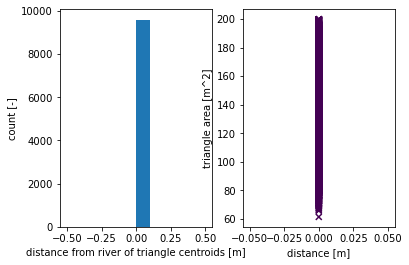

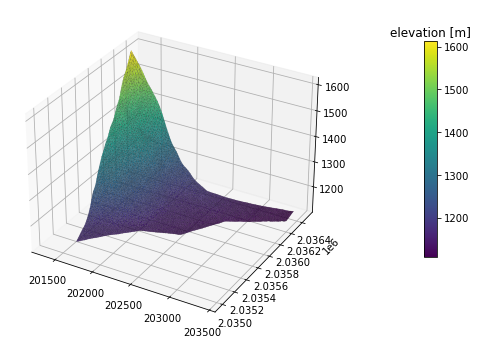

In [21]:
subcatch_demo_smooth = hillslope_demo_pars['subcatchment_smooth']
m2, lc = meshing.createSubcatchmentMesh2D(filenames, subcatch_demo_smooth, subcatch_crs,
                                          mesh_demo_pars, plot=True)
m3 = meshing.createSubcatchmentMesh3D(m2, lc, layer_info,
                                      os.path.join(mesh_dir, f'sag_subcatchment{subcatch_demo_id}.exo'))

## 2D for all subcatchments

In [23]:
# subcatch_all_ids = np.arange(1, len(subcatchments)+1)
# for subcatch_id in subcatch_all_ids:
#     index = subcatch_id - 1
#     m2 = meshing.createHillslopeMesh2D(mesh_pars[index])
#     m3 = meshing.createHillslopeMesh3D(m2, mesh_pars[index], meshing.layeringStructure(),
#                                        os.path.join(mesh_dir,f'sag_hillslope{subcatch_id}.exo'))

## 3D for all subcatchments

2021-09-23 13:19:59,872 - root - INFO: 
2021-09-23 13:19:59,873 - root - INFO: Meshing
2021-09-23 13:19:59,874 - root - INFO: ------------------------------
2021-09-23 13:19:59,874 - root - INFO: Triangulating...
2021-09-23 13:19:59,875 - root - INFO:    18 points and 18 facets
2021-09-23 13:19:59,875 - root - INFO:  checking graph consistency
2021-09-23 13:19:59,876 - root - INFO:  tolerance is set to 1
2021-09-23 13:19:59,876 - root - INFO:  building graph data structures
2021-09-23 13:19:59,877 - root - INFO:  triangle.build...
2021-09-23 13:20:00,160 - root - INFO:   ...built: 14261 mesh points and 28029 triangles
2021-09-23 13:20:00,161 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:20:00,821 - root - INFO:   min area = 49.853485107421875
2021-09-23 13:20:00,822 - root - INFO:   max area = 199.99191284179688
2021-09-23 13:20:01,146 - root - INFO: 
2021-09-23 13:20:01,147 - root - INFO: Loading Raster
2021-09-23 13:20:01,148 - root - INFO: -------------------------

bounds in my_crs: (-149.32333181192908, 68.18904867385021, -149.23495351407024, 68.20809989576648)


2021-09-23 13:20:01,416 - root - INFO: ... got raster of shape: (69, 319)
2021-09-23 13:20:01,424 - root - INFO: ... got raster bounds: (-149.32346060296518, 68.20814340505098, -149.23484949185112, 68.18897673838367)
2021-09-23 13:20:01,518 - root - INFO: 
2021-09-23 13:20:01,519 - root - INFO: Loading Raster
2021-09-23 13:20:01,520 - root - INFO: ------------------------------
2021-09-23 13:20:01,520 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:20:01,521 - root - INFO: Collecting raster
2021-09-23 13:20:01,562 - root - INFO: ... got raster of shape: (69, 319)
2021-09-23 13:20:01,572 - root - INFO: ... got raster bounds: (-149.32346060296518, 68.20814340505098, -149.23484949185112, 68.18897673838367)


bounds in my_crs: (-149.32333181192908, 68.18904867385021, -149.23495351407024, 68.20809989576648)
bounds in my_crs: (-149.32333181192908, 68.18904867385021, -149.23495351407024, 68.20809989576648)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment1.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment1.exo


2021-09-23 13:20:35,175 - root - INFO: 
2021-09-23 13:20:35,176 - root - INFO: Meshing
2021-09-23 13:20:35,176 - root - INFO: ------------------------------
2021-09-23 13:20:35,177 - root - INFO: Triangulating...
2021-09-23 13:20:35,178 - root - INFO:    19 points and 19 facets
2021-09-23 13:20:35,179 - root - INFO:  checking graph consistency
2021-09-23 13:20:35,179 - root - INFO:  tolerance is set to 1
2021-09-23 13:20:35,180 - root - INFO:  building graph data structures
2021-09-23 13:20:35,181 - root - INFO:  triangle.build...
2021-09-23 13:20:35,449 - root - INFO:   ...built: 13807 mesh points and 27147 triangles
2021-09-23 13:20:35,450 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:20:36,100 - root - INFO:   min area = 60.220672607421875
2021-09-23 13:20:36,101 - root - INFO:   max area = 199.98150634765625
2021-09-23 13:20:36,382 - root - INFO: 
2021-09-23 13:20:36,383 - root - INFO: Loading Raster
2021-09-23 13:20:36,383 - root - INFO: -------------------------

bounds in my_crs: (-149.32349899933536, 68.18007214137471, -149.23231844816064, 68.19760352339726)


2021-09-23 13:20:36,642 - root - INFO: ... got raster of shape: (65, 330)
2021-09-23 13:20:36,651 - root - INFO: ... got raster bounds: (-149.32373838074298, 68.19786562727286, -149.23207171407327, 68.1798100717167)
2021-09-23 13:20:36,746 - root - INFO: 
2021-09-23 13:20:36,747 - root - INFO: Loading Raster
2021-09-23 13:20:36,747 - root - INFO: ------------------------------
2021-09-23 13:20:36,748 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:20:36,749 - root - INFO: Collecting raster
2021-09-23 13:20:36,794 - root - INFO: ... got raster of shape: (65, 330)
2021-09-23 13:20:36,803 - root - INFO: ... got raster bounds: (-149.32373838074298, 68.19786562727286, -149.23207171407327, 68.1798100717167)


bounds in my_crs: (-149.32349899933536, 68.18007214137471, -149.23231844816064, 68.19760352339726)
bounds in my_crs: (-149.32349899933536, 68.18007214137471, -149.23231844816064, 68.19760352339726)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment2.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment2.exo


2021-09-23 13:21:09,384 - root - INFO: 
2021-09-23 13:21:09,385 - root - INFO: Meshing
2021-09-23 13:21:09,385 - root - INFO: ------------------------------
2021-09-23 13:21:09,386 - root - INFO: Triangulating...
2021-09-23 13:21:09,387 - root - INFO:    16 points and 16 facets
2021-09-23 13:21:09,387 - root - INFO:  checking graph consistency
2021-09-23 13:21:09,388 - root - INFO:  tolerance is set to 1
2021-09-23 13:21:09,388 - root - INFO:  building graph data structures
2021-09-23 13:21:09,389 - root - INFO:  triangle.build...
2021-09-23 13:21:09,689 - root - INFO:   ...built: 16183 mesh points and 31951 triangles
2021-09-23 13:21:09,690 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:21:10,365 - root - INFO:   min area = 59.8853759765625
2021-09-23 13:21:10,366 - root - INFO:   max area = 199.969482421875
2021-09-23 13:21:10,711 - root - INFO: 
2021-09-23 13:21:10,712 - root - INFO: Loading Raster
2021-09-23 13:21:10,712 - root - INFO: -----------------------------

bounds in my_crs: (-149.25371456417372, 68.17875098194455, -149.18872340913728, 68.20521902133713)


2021-09-23 13:21:11,001 - root - INFO: ... got raster of shape: (96, 235)
2021-09-23 13:21:11,010 - root - INFO: ... got raster bounds: (-149.25373838074066, 68.20536562727311, -149.1884606029607, 68.17869896060556)
2021-09-23 13:21:11,113 - root - INFO: 
2021-09-23 13:21:11,114 - root - INFO: Loading Raster
2021-09-23 13:21:11,114 - root - INFO: ------------------------------
2021-09-23 13:21:11,115 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:21:11,116 - root - INFO: Collecting raster
2021-09-23 13:21:11,164 - root - INFO: ... got raster of shape: (96, 235)
2021-09-23 13:21:11,175 - root - INFO: ... got raster bounds: (-149.25373838074066, 68.20536562727311, -149.1884606029607, 68.17869896060556)


bounds in my_crs: (-149.25371456417372, 68.17875098194455, -149.18872340913728, 68.20521902133713)
bounds in my_crs: (-149.25371456417372, 68.17875098194455, -149.18872340913728, 68.20521902133713)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment3.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment3.exo


2021-09-23 13:21:47,979 - root - INFO: 
2021-09-23 13:21:47,979 - root - INFO: Meshing
2021-09-23 13:21:47,980 - root - INFO: ------------------------------
2021-09-23 13:21:47,981 - root - INFO: Triangulating...
2021-09-23 13:21:47,982 - root - INFO:    11 points and 11 facets
2021-09-23 13:21:47,982 - root - INFO:  checking graph consistency
2021-09-23 13:21:47,982 - root - INFO:  tolerance is set to 1
2021-09-23 13:21:47,983 - root - INFO:  building graph data structures
2021-09-23 13:21:47,984 - root - INFO:  triangle.build...
2021-09-23 13:21:48,194 - root - INFO:   ...built: 10834 mesh points and 21327 triangles
2021-09-23 13:21:48,195 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:21:48,659 - root - INFO:   min area = 58.8323974609375
2021-09-23 13:21:48,660 - root - INFO:   max area = 199.98284912109375
2021-09-23 13:21:48,875 - root - INFO: 
2021-09-23 13:21:48,875 - root - INFO: Loading Raster
2021-09-23 13:21:48,876 - root - INFO: ---------------------------

bounds in my_crs: (-149.27179877026592, 68.19927082938099, -149.20801699376824, 68.21563762826689)
bounds in my_crs: (-149.27179877026592, 68.19927082938099, -149.20801699376824, 68.21563762826689)


2021-09-23 13:21:49,187 - root - INFO: 
2021-09-23 13:21:49,188 - root - INFO: Loading Raster
2021-09-23 13:21:49,188 - root - INFO: ------------------------------
2021-09-23 13:21:49,189 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:21:49,189 - root - INFO: Collecting raster
2021-09-23 13:21:49,236 - root - INFO: ... got raster of shape: (59, 231)
2021-09-23 13:21:49,245 - root - INFO: ... got raster bounds: (-149.2720717140746, 68.21564340505122, -149.2079050474058, 68.19925451616179)


bounds in my_crs: (-149.27179877026592, 68.19927082938099, -149.20801699376824, 68.21563762826689)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment4.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment4.exo


2021-09-23 13:22:14,429 - root - INFO: 
2021-09-23 13:22:14,430 - root - INFO: Meshing
2021-09-23 13:22:14,430 - root - INFO: ------------------------------
2021-09-23 13:22:14,431 - root - INFO: Triangulating...
2021-09-23 13:22:14,431 - root - INFO:    18 points and 18 facets
2021-09-23 13:22:14,432 - root - INFO:  checking graph consistency
2021-09-23 13:22:14,432 - root - INFO:  tolerance is set to 1
2021-09-23 13:22:14,433 - root - INFO:  building graph data structures
2021-09-23 13:22:14,433 - root - INFO:  triangle.build...
2021-09-23 13:22:14,893 - root - INFO:   ...built: 26624 mesh points and 52678 triangles
2021-09-23 13:22:14,894 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:22:15,974 - root - INFO:   min area = 52.785980224609375
2021-09-23 13:22:15,974 - root - INFO:   max area = 199.97225952148438
2021-09-23 13:22:16,437 - root - INFO: 
2021-09-23 13:22:16,438 - root - INFO: Loading Raster
2021-09-23 13:22:16,439 - root - INFO: -------------------------

bounds in my_crs: (-149.27573517147246, 68.207289642888, -149.17231387605082, 68.23426687242299)


2021-09-23 13:22:16,724 - root - INFO: 
2021-09-23 13:22:16,724 - root - INFO: Loading Raster
2021-09-23 13:22:16,725 - root - INFO: ------------------------------
2021-09-23 13:22:16,725 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:22:16,726 - root - INFO: Collecting raster
2021-09-23 13:22:16,769 - root - INFO: ... got raster of shape: (99, 374)
2021-09-23 13:22:16,778 - root - INFO: ... got raster bounds: (-149.2759606029636, 68.23453229394075, -149.17207171407128, 68.20703229393983)
2021-09-23 13:22:16,913 - root - INFO: 
2021-09-23 13:22:16,914 - root - INFO: Loading Raster
2021-09-23 13:22:16,914 - root - INFO: ------------------------------
2021-09-23 13:22:16,915 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:22:16,916 - root - INFO: Collecting raster
2021-09-23 13:22:16,960 - root - INFO: ... got raster of shape: (99, 37

bounds in my_crs: (-149.27573517147246, 68.207289642888, -149.17231387605082, 68.23426687242299)
bounds in my_crs: (-149.27573517147246, 68.207289642888, -149.17231387605082, 68.23426687242299)


2021-09-23 13:22:16,969 - root - INFO: ... got raster bounds: (-149.2759606029636, 68.23453229394075, -149.17207171407128, 68.20703229393983)


Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment5.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment5.exo


2021-09-23 13:23:17,638 - root - INFO: 
2021-09-23 13:23:17,639 - root - INFO: Meshing
2021-09-23 13:23:17,640 - root - INFO: ------------------------------
2021-09-23 13:23:17,640 - root - INFO: Triangulating...
2021-09-23 13:23:17,641 - root - INFO:    10 points and 10 facets
2021-09-23 13:23:17,641 - root - INFO:  checking graph consistency
2021-09-23 13:23:17,642 - root - INFO:  tolerance is set to 1
2021-09-23 13:23:17,643 - root - INFO:  building graph data structures
2021-09-23 13:23:17,643 - root - INFO:  triangle.build...
2021-09-23 13:23:17,773 - root - INFO:   ...built: 6428 mesh points and 12588 triangles
2021-09-23 13:23:17,777 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:23:18,066 - root - INFO:   min area = 30.5418701171875
2021-09-23 13:23:18,067 - root - INFO:   max area = 199.99493408203125
2021-09-23 13:23:18,212 - root - INFO: 
2021-09-23 13:23:18,213 - root - INFO: Loading Raster
2021-09-23 13:23:18,213 - root - INFO: ----------------------------

bounds in my_crs: (-149.21318529930883, 68.19654310128655, -149.17137472521458, 68.20967710288205)
bounds in my_crs: (-149.21318529930883, 68.19654310128655, -149.17137472521458, 68.20967710288205)


2021-09-23 13:23:18,477 - root - INFO: 
2021-09-23 13:23:18,478 - root - INFO: Loading Raster
2021-09-23 13:23:18,478 - root - INFO: ------------------------------
2021-09-23 13:23:18,479 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:23:18,479 - root - INFO: Collecting raster
2021-09-23 13:23:18,522 - root - INFO: ... got raster of shape: (48, 152)
2021-09-23 13:23:18,531 - root - INFO: ... got raster bounds: (-149.21346060296153, 68.2098100717177, -149.17123838073792, 68.19647673838392)


bounds in my_crs: (-149.21318529930883, 68.19654310128655, -149.17137472521458, 68.20967710288205)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment6.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment6.exo


2021-09-23 13:23:33,101 - root - INFO: 
2021-09-23 13:23:33,102 - root - INFO: Meshing
2021-09-23 13:23:33,103 - root - INFO: ------------------------------
2021-09-23 13:23:33,104 - root - INFO: Triangulating...
2021-09-23 13:23:33,104 - root - INFO:    10 points and 10 facets
2021-09-23 13:23:33,105 - root - INFO:  checking graph consistency
2021-09-23 13:23:33,105 - root - INFO:  tolerance is set to 1
2021-09-23 13:23:33,106 - root - INFO:  building graph data structures
2021-09-23 13:23:33,107 - root - INFO:  triangle.build...
2021-09-23 13:23:33,386 - root - INFO:   ...built: 13061 mesh points and 25746 triangles
2021-09-23 13:23:33,387 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:23:33,952 - root - INFO:   min area = 31.566497802734375
2021-09-23 13:23:33,953 - root - INFO:   max area = 199.987060546875
2021-09-23 13:23:34,201 - root - INFO: 
2021-09-23 13:23:34,202 - root - INFO: Loading Raster
2021-09-23 13:23:34,202 - root - INFO: ---------------------------

bounds in my_crs: (-149.17008126329404, 68.19860441435323, -149.11752268914583, 68.224084697891)
bounds in my_crs: (-149.17008126329404, 68.19860441435323, -149.11752268914583, 68.224084697891)


2021-09-23 13:23:34,452 - root - INFO: ... got raster bounds: (-149.17012726962676, 68.22425451616263, -149.11734949184722, 68.19842118282844)
2021-09-23 13:23:34,542 - root - INFO: 
2021-09-23 13:23:34,543 - root - INFO: Loading Raster
2021-09-23 13:23:34,544 - root - INFO: ------------------------------
2021-09-23 13:23:34,544 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:23:34,545 - root - INFO: Collecting raster
2021-09-23 13:23:34,588 - root - INFO: ... got raster of shape: (93, 190)
2021-09-23 13:23:34,597 - root - INFO: ... got raster bounds: (-149.17012726962676, 68.22425451616263, -149.11734949184722, 68.19842118282844)


bounds in my_crs: (-149.17008126329404, 68.19860441435323, -149.11752268914583, 68.224084697891)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment7.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment7.exo


2021-09-23 13:24:03,815 - root - INFO: 
2021-09-23 13:24:03,816 - root - INFO: Meshing
2021-09-23 13:24:03,817 - root - INFO: ------------------------------
2021-09-23 13:24:03,817 - root - INFO: Triangulating...
2021-09-23 13:24:03,818 - root - INFO:    8 points and 8 facets
2021-09-23 13:24:03,818 - root - INFO:  checking graph consistency
2021-09-23 13:24:03,819 - root - INFO:  tolerance is set to 1
2021-09-23 13:24:03,820 - root - INFO:  building graph data structures
2021-09-23 13:24:03,820 - root - INFO:  triangle.build...
2021-09-23 13:24:03,924 - root - INFO:   ...built: 4932 mesh points and 9596 triangles
2021-09-23 13:24:03,927 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:24:04,147 - root - INFO:   min area = 61.36431884765625
2021-09-23 13:24:04,147 - root - INFO:   max area = 199.99404907226562
2021-09-23 13:24:04,264 - root - INFO: 
2021-09-23 13:24:04,265 - root - INFO: Loading Raster
2021-09-23 13:24:04,265 - root - INFO: ------------------------------

bounds in my_crs: (-149.17752425651716, 68.2100293487316, -149.1277460038376, 68.22241031118037)
bounds in my_crs: (-149.17752425651716, 68.2100293487316, -149.1277460038376, 68.22241031118037)


2021-09-23 13:24:04,507 - root - INFO: Collecting raster
2021-09-23 13:24:04,551 - root - INFO: ... got raster of shape: (46, 180)
2021-09-23 13:24:04,560 - root - INFO: ... got raster bounds: (-149.177627269627, 68.22258784949591, -149.12762726962535, 68.20981007171771)


bounds in my_crs: (-149.17752425651716, 68.2100293487316, -149.1277460038376, 68.22241031118037)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment8.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment8.exo


2021-09-23 13:24:15,607 - root - INFO: 
2021-09-23 13:24:15,607 - root - INFO: Meshing
2021-09-23 13:24:15,608 - root - INFO: ------------------------------
2021-09-23 13:24:15,608 - root - INFO: Triangulating...
2021-09-23 13:24:15,609 - root - INFO:    5 points and 5 facets
2021-09-23 13:24:15,609 - root - INFO:  checking graph consistency
2021-09-23 13:24:15,610 - root - INFO:  tolerance is set to 1
2021-09-23 13:24:15,610 - root - INFO:  building graph data structures
2021-09-23 13:24:15,611 - root - INFO:  triangle.build...
2021-09-23 13:24:15,633 - root - INFO:   ...built: 943 mesh points and 1765 triangles
2021-09-23 13:24:15,634 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:24:15,683 - root - INFO:   min area = 64.89346313476562
2021-09-23 13:24:15,684 - root - INFO:   max area = 199.94284057617188
2021-09-23 13:24:15,736 - root - INFO: 
2021-09-23 13:24:15,737 - root - INFO: Loading Raster
2021-09-23 13:24:15,737 - root - INFO: ------------------------------


bounds in my_crs: (-149.12195772397504, 68.2146470306309, -149.11469670554692, 68.22476698259781)
bounds in my_crs: (-149.12195772397504, 68.2146470306309, -149.11469670554692, 68.22476698259781)
bounds in my_crs: (-149.12195772397504, 68.2146470306309, -149.11469670554692, 68.22476698259781)

2021-09-23 13:24:15,982 - root - INFO: ... got raster of shape: (37, 27)
2021-09-23 13:24:15,991 - root - INFO: ... got raster bounds: (-149.12207171406962, 68.2248100717182, -149.11457171406937, 68.21453229394008)



Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment9.exo


2021-09-23 13:24:18,174 - root - INFO: 
2021-09-23 13:24:18,175 - root - INFO: Meshing
2021-09-23 13:24:18,176 - root - INFO: ------------------------------
2021-09-23 13:24:18,176 - root - INFO: Triangulating...
2021-09-23 13:24:18,177 - root - INFO:    4 points and 4 facets
2021-09-23 13:24:18,178 - root - INFO:  checking graph consistency
2021-09-23 13:24:18,178 - root - INFO:  tolerance is set to 1
2021-09-23 13:24:18,180 - root - INFO:  building graph data structures
2021-09-23 13:24:18,180 - root - INFO:  triangle.build...
2021-09-23 13:24:18,190 - root - INFO:   ...built: 403 mesh points and 740 triangles
2021-09-23 13:24:18,191 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:24:18,218 - root - INFO:   min area = 63.197265625
2021-09-23 13:24:18,219 - root - INFO:   max area = 197.10922241210938
2021-09-23 13:24:18,265 - root - INFO: 
2021-09-23 13:24:18,266 - root - INFO: Loading Raster
2021-09-23 13:24:18,266 - root - INFO: ------------------------------
2021-0

Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment9.exo
bounds in my_crs: (-149.1220145604678, 68.224633298062, -149.11450991948863, 68.22964545511863)


2021-09-23 13:24:18,374 - root - INFO: 
2021-09-23 13:24:18,375 - root - INFO: Loading Raster
2021-09-23 13:24:18,375 - root - INFO: ------------------------------
2021-09-23 13:24:18,375 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:24:18,376 - root - INFO: Collecting raster
2021-09-23 13:24:18,421 - root - INFO: ... got raster of shape: (19, 28)
2021-09-23 13:24:18,430 - root - INFO: ... got raster bounds: (-149.12207171406962, 68.22981007171836, -149.11429393629157, 68.22453229394041)
2021-09-23 13:24:18,471 - root - INFO: 
2021-09-23 13:24:18,471 - root - INFO: Loading Raster
2021-09-23 13:24:18,472 - root - INFO: ------------------------------
2021-09-23 13:24:18,473 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:24:18,473 - root - INFO: Collecting raster
2021-09-23 13:24:18,514 - root - INFO: ... got raster of shape: (19, 28

bounds in my_crs: (-149.1220145604678, 68.224633298062, -149.11450991948863, 68.22964545511863)
bounds in my_crs: (-149.1220145604678, 68.224633298062, -149.11450991948863, 68.22964545511863)


2021-09-23 13:24:19,504 - root - INFO: 


Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment10.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment10.exo


2021-09-23 13:24:19,505 - root - INFO: Meshing
2021-09-23 13:24:19,505 - root - INFO: ------------------------------
2021-09-23 13:24:19,506 - root - INFO: Triangulating...
2021-09-23 13:24:19,507 - root - INFO:    17 points and 17 facets
2021-09-23 13:24:19,507 - root - INFO:  checking graph consistency
2021-09-23 13:24:19,507 - root - INFO:  tolerance is set to 1
2021-09-23 13:24:19,508 - root - INFO:  building graph data structures
2021-09-23 13:24:19,509 - root - INFO:  triangle.build...
2021-09-23 13:24:19,825 - root - INFO:   ...built: 17219 mesh points and 33992 triangles
2021-09-23 13:24:19,826 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:24:20,547 - root - INFO:   min area = 62.965301513671875
2021-09-23 13:24:20,548 - root - INFO:   max area = 199.99411010742188
2021-09-23 13:24:20,902 - root - INFO: 
2021-09-23 13:24:20,903 - root - INFO: Loading Raster
2021-09-23 13:24:20,904 - root - INFO: ------------------------------
2021-09-23 13:24:20,904 - root - I

bounds in my_crs: (-149.1252712902553, 68.19958418193676, -149.0724953180663, 68.23194119249688)


2021-09-23 13:24:21,180 - root - INFO: ... got raster of shape: (117, 191)
2021-09-23 13:24:21,189 - root - INFO: ... got raster bounds: (-149.12540504740306, 68.23203229394066, -149.07234949184576, 68.19953229393958)
2021-09-23 13:24:21,291 - root - INFO: 
2021-09-23 13:24:21,291 - root - INFO: Loading Raster
2021-09-23 13:24:21,292 - root - INFO: ------------------------------
2021-09-23 13:24:21,292 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:24:21,293 - root - INFO: Collecting raster
2021-09-23 13:24:21,335 - root - INFO: ... got raster of shape: (117, 191)
2021-09-23 13:24:21,344 - root - INFO: ... got raster bounds: (-149.12540504740306, 68.23203229394066, -149.07234949184576, 68.19953229393958)


bounds in my_crs: (-149.1252712902553, 68.19958418193676, -149.0724953180663, 68.23194119249688)
bounds in my_crs: (-149.1252712902553, 68.19958418193676, -149.0724953180663, 68.23194119249688)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment11.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment11.exo


2021-09-23 13:25:00,161 - root - INFO: 
2021-09-23 13:25:00,162 - root - INFO: Meshing
2021-09-23 13:25:00,163 - root - INFO: ------------------------------
2021-09-23 13:25:00,164 - root - INFO: Triangulating...
2021-09-23 13:25:00,164 - root - INFO:    7 points and 7 facets
2021-09-23 13:25:00,165 - root - INFO:  checking graph consistency
2021-09-23 13:25:00,165 - root - INFO:  tolerance is set to 1
2021-09-23 13:25:00,166 - root - INFO:  building graph data structures
2021-09-23 13:25:00,166 - root - INFO:  triangle.build...
2021-09-23 13:25:00,404 - root - INFO:   ...built: 11500 mesh points and 22655 triangles
2021-09-23 13:25:00,406 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:25:00,925 - root - INFO:   min area = 39.735809326171875
2021-09-23 13:25:00,927 - root - INFO:   max area = 199.99679565429688
2021-09-23 13:25:01,157 - root - INFO: 
2021-09-23 13:25:01,158 - root - INFO: Loading Raster
2021-09-23 13:25:01,159 - root - INFO: ---------------------------

bounds in my_crs: (-149.1159483824004, 68.2248164661218, -149.0804188841349, 68.25091454444949)
bounds in my_crs: (-149.1159483824004, 68.2248164661218, -149.0804188841349, 68.25091454444949)


2021-09-23 13:25:01,476 - root - INFO: 
2021-09-23 13:25:01,477 - root - INFO: Loading Raster
2021-09-23 13:25:01,477 - root - INFO: ------------------------------
2021-09-23 13:25:01,478 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:25:01,478 - root - INFO: Collecting raster
2021-09-23 13:25:01,523 - root - INFO: ... got raster of shape: (94, 128)
2021-09-23 13:25:01,531 - root - INFO: ... got raster bounds: (-149.1159606029583, 68.25092118283018, -149.08040504740157, 68.22481007171821)


bounds in my_crs: (-149.1159483824004, 68.2248164661218, -149.0804188841349, 68.25091454444949)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment12.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment12.exo


2021-09-23 13:25:28,597 - root - INFO: 
2021-09-23 13:25:28,598 - root - INFO: Meshing
2021-09-23 13:25:28,598 - root - INFO: ------------------------------
2021-09-23 13:25:28,599 - root - INFO: Triangulating...
2021-09-23 13:25:28,600 - root - INFO:    12 points and 12 facets
2021-09-23 13:25:28,600 - root - INFO:  checking graph consistency
2021-09-23 13:25:28,601 - root - INFO:  tolerance is set to 1
2021-09-23 13:25:28,601 - root - INFO:  building graph data structures
2021-09-23 13:25:28,602 - root - INFO:  triangle.build...
2021-09-23 13:25:28,852 - root - INFO:   ...built: 14357 mesh points and 28318 triangles
2021-09-23 13:25:28,853 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:25:29,519 - root - INFO:   min area = 57.526275634765625
2021-09-23 13:25:29,520 - root - INFO:   max area = 199.99566650390625
2021-09-23 13:25:29,790 - root - INFO: 
2021-09-23 13:25:29,791 - root - INFO: Loading Raster
2021-09-23 13:25:29,792 - root - INFO: -------------------------

bounds in my_crs: (-149.08555398967127, 68.21735876156187, -149.02887005478019, 68.24383919593815)


2021-09-23 13:25:30,038 - root - INFO: ... got raster of shape: (96, 205)
2021-09-23 13:25:30,048 - root - INFO: ... got raster bounds: (-149.08568282517953, 68.2439767383855, -149.0287383807332, 68.21731007171795)
2021-09-23 13:25:30,138 - root - INFO: 
2021-09-23 13:25:30,139 - root - INFO: Loading Raster
2021-09-23 13:25:30,139 - root - INFO: ------------------------------
2021-09-23 13:25:30,140 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:25:30,141 - root - INFO: Collecting raster
2021-09-23 13:25:30,183 - root - INFO: ... got raster of shape: (96, 205)
2021-09-23 13:25:30,191 - root - INFO: ... got raster bounds: (-149.08568282517953, 68.2439767383855, -149.0287383807332, 68.21731007171795)


bounds in my_crs: (-149.08555398967127, 68.21735876156187, -149.02887005478019, 68.24383919593815)
bounds in my_crs: (-149.08555398967127, 68.21735876156187, -149.02887005478019, 68.24383919593815)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment13.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment13.exo


2021-09-23 13:26:05,227 - root - INFO: 
2021-09-23 13:26:05,228 - root - INFO: Meshing
2021-09-23 13:26:05,228 - root - INFO: ------------------------------
2021-09-23 13:26:05,228 - root - INFO: Triangulating...
2021-09-23 13:26:05,231 - root - INFO:    7 points and 7 facets
2021-09-23 13:26:05,233 - root - INFO:  checking graph consistency
2021-09-23 13:26:05,234 - root - INFO:  tolerance is set to 1
2021-09-23 13:26:05,235 - root - INFO:  building graph data structures
2021-09-23 13:26:05,236 - root - INFO:  triangle.build...
2021-09-23 13:26:05,579 - root - INFO:   ...built: 12402 mesh points and 24442 triangles
2021-09-23 13:26:05,580 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:26:06,126 - root - INFO:   min area = 39.55126953125
2021-09-23 13:26:06,127 - root - INFO:   max area = 199.97433471679688
2021-09-23 13:26:06,416 - root - INFO: 
2021-09-23 13:26:06,417 - root - INFO: Loading Raster
2021-09-23 13:26:06,417 - root - INFO: ------------------------------


bounds in my_crs: (-149.09027776606652, 68.2321531453996, -149.02999166915717, 68.25089018150955)


2021-09-23 13:26:06,695 - root - INFO: ... got raster of shape: (68, 218)
2021-09-23 13:26:06,708 - root - INFO: ... got raster bounds: (-149.0904050474019, 68.25092118283018, -149.02984949184435, 68.23203229394066)
2021-09-23 13:26:06,800 - root - INFO: 
2021-09-23 13:26:06,801 - root - INFO: Loading Raster
2021-09-23 13:26:06,802 - root - INFO: ------------------------------
2021-09-23 13:26:06,802 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:26:06,803 - root - INFO: Collecting raster
2021-09-23 13:26:06,858 - root - INFO: ... got raster of shape: (68, 218)
2021-09-23 13:26:06,867 - root - INFO: ... got raster bounds: (-149.0904050474019, 68.25092118283018, -149.02984949184435, 68.23203229394066)


bounds in my_crs: (-149.09027776606652, 68.2321531453996, -149.02999166915717, 68.25089018150955)
bounds in my_crs: (-149.09027776606652, 68.2321531453996, -149.02999166915717, 68.25089018150955)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment14.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment14.exo


2021-09-23 13:26:36,122 - root - INFO: 
2021-09-23 13:26:36,123 - root - INFO: Meshing
2021-09-23 13:26:36,123 - root - INFO: ------------------------------
2021-09-23 13:26:36,124 - root - INFO: Triangulating...
2021-09-23 13:26:36,125 - root - INFO:    11 points and 11 facets
2021-09-23 13:26:36,125 - root - INFO:  checking graph consistency
2021-09-23 13:26:36,126 - root - INFO:  tolerance is set to 1
2021-09-23 13:26:36,127 - root - INFO:  building graph data structures
2021-09-23 13:26:36,127 - root - INFO:  triangle.build...
2021-09-23 13:26:36,466 - root - INFO:   ...built: 14740 mesh points and 29109 triangles
2021-09-23 13:26:36,467 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:26:37,094 - root - INFO:   min area = 60.285186767578125
2021-09-23 13:26:37,095 - root - INFO:   max area = 199.97903442382812
2021-09-23 13:26:37,369 - root - INFO: 
2021-09-23 13:26:37,370 - root - INFO: Loading Raster
2021-09-23 13:26:37,370 - root - INFO: -------------------------

bounds in my_crs: (-149.03048446793935, 68.24422492626324, -148.97588227121466, 68.26816107683497)
bounds in my_crs: (-149.03048446793935, 68.24422492626324, -148.97588227121466, 68.26816107683497)


2021-09-23 13:26:37,615 - root - INFO: ... got raster bounds: (-149.0306828251777, 68.26842118283076, -148.97568282517588, 68.24397673838551)
2021-09-23 13:26:37,701 - root - INFO: 
2021-09-23 13:26:37,702 - root - INFO: Loading Raster
2021-09-23 13:26:37,702 - root - INFO: ------------------------------
2021-09-23 13:26:37,703 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:26:37,704 - root - INFO: Collecting raster
2021-09-23 13:26:37,743 - root - INFO: ... got raster of shape: (88, 198)
2021-09-23 13:26:37,752 - root - INFO: ... got raster bounds: (-149.0306828251777, 68.26842118283076, -148.97568282517588, 68.24397673838551)


bounds in my_crs: (-149.03048446793935, 68.24422492626324, -148.97588227121466, 68.26816107683497)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment15.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment15.exo


2021-09-23 13:27:13,827 - root - INFO: 
2021-09-23 13:27:13,828 - root - INFO: Meshing
2021-09-23 13:27:13,829 - root - INFO: ------------------------------
2021-09-23 13:27:13,829 - root - INFO: Triangulating...
2021-09-23 13:27:13,831 - root - INFO:    12 points and 12 facets
2021-09-23 13:27:13,831 - root - INFO:  checking graph consistency
2021-09-23 13:27:13,832 - root - INFO:  tolerance is set to 1
2021-09-23 13:27:13,833 - root - INFO:  building graph data structures
2021-09-23 13:27:13,834 - root - INFO:  triangle.build...
2021-09-23 13:27:13,971 - root - INFO:   ...built: 6756 mesh points and 13181 triangles
2021-09-23 13:27:13,974 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:27:14,311 - root - INFO:   min area = 56.0380859375
2021-09-23 13:27:14,311 - root - INFO:   max area = 199.96469116210938
2021-09-23 13:27:14,459 - root - INFO: 
2021-09-23 13:27:14,459 - root - INFO: Loading Raster
2021-09-23 13:27:14,460 - root - INFO: ------------------------------


bounds in my_crs: (-149.030312656111, 68.23544774934933, -148.97494286142927, 68.25448400386779)
bounds in my_crs: (-149.030312656111, 68.23544774934933, -148.97494286142927, 68.25448400386779)


2021-09-23 13:27:14,716 - root - INFO: 
2021-09-23 13:27:14,716 - root - INFO: Loading Raster
2021-09-23 13:27:14,717 - root - INFO: ------------------------------
2021-09-23 13:27:14,717 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:27:14,718 - root - INFO: Collecting raster
2021-09-23 13:27:14,756 - root - INFO: ... got raster of shape: (69, 200)
2021-09-23 13:27:14,765 - root - INFO: ... got raster bounds: (-149.0304050473999, 68.25453229394141, -148.97484949184252, 68.2353656272741)


bounds in my_crs: (-149.030312656111, 68.23544774934933, -148.97494286142927, 68.25448400386779)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment16.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment16.exo


2021-09-23 13:27:30,881 - root - INFO: 
2021-09-23 13:27:30,882 - root - INFO: Meshing
2021-09-23 13:27:30,883 - root - INFO: ------------------------------
2021-09-23 13:27:30,883 - root - INFO: Triangulating...
2021-09-23 13:27:30,884 - root - INFO:    13 points and 13 facets
2021-09-23 13:27:30,885 - root - INFO:  checking graph consistency
2021-09-23 13:27:30,885 - root - INFO:  tolerance is set to 1
2021-09-23 13:27:30,886 - root - INFO:  building graph data structures
2021-09-23 13:27:30,887 - root - INFO:  triangle.build...
2021-09-23 13:27:31,228 - root - INFO:   ...built: 19301 mesh points and 38159 triangles
2021-09-23 13:27:31,229 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:27:32,157 - root - INFO:   min area = 33.711090087890625
2021-09-23 13:27:32,158 - root - INFO:   max area = 199.98992919921875
2021-09-23 13:27:32,521 - root - INFO: 
2021-09-23 13:27:32,522 - root - INFO: Loading Raster
2021-09-23 13:27:32,522 - root - INFO: -------------------------

bounds in my_crs: (-149.01323342717478, 68.25590210213116, -148.9403544805741, 68.28066175352585)


2021-09-23 13:27:32,813 - root - INFO: ... got raster of shape: (91, 264)
2021-09-23 13:27:32,822 - root - INFO: ... got raster bounds: (-149.0134606029549, 68.28092118283118, -148.94012726961913, 68.25564340505257)
2021-09-23 13:27:32,929 - root - INFO: 
2021-09-23 13:27:32,930 - root - INFO: Loading Raster
2021-09-23 13:27:32,930 - root - INFO: ------------------------------
2021-09-23 13:27:32,931 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:27:32,932 - root - INFO: Collecting raster
2021-09-23 13:27:32,975 - root - INFO: ... got raster of shape: (91, 264)
2021-09-23 13:27:32,984 - root - INFO: ... got raster bounds: (-149.0134606029549, 68.28092118283118, -148.94012726961913, 68.25564340505257)


bounds in my_crs: (-149.01323342717478, 68.25590210213116, -148.9403544805741, 68.28066175352585)
bounds in my_crs: (-149.01323342717478, 68.25590210213116, -148.9403544805741, 68.28066175352585)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment17.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment17.exo


2021-09-23 13:28:19,449 - root - INFO: 
2021-09-23 13:28:19,450 - root - INFO: Meshing
2021-09-23 13:28:19,451 - root - INFO: ------------------------------
2021-09-23 13:28:19,452 - root - INFO: Triangulating...
2021-09-23 13:28:19,452 - root - INFO:    11 points and 11 facets
2021-09-23 13:28:19,453 - root - INFO:  checking graph consistency
2021-09-23 13:28:19,453 - root - INFO:  tolerance is set to 1
2021-09-23 13:28:19,454 - root - INFO:  building graph data structures
2021-09-23 13:28:19,454 - root - INFO:  triangle.build...
2021-09-23 13:28:19,690 - root - INFO:   ...built: 10157 mesh points and 19949 triangles
2021-09-23 13:28:19,691 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:28:20,197 - root - INFO:   min area = 40.16156005859375
2021-09-23 13:28:20,197 - root - INFO:   max area = 199.96157836914062
2021-09-23 13:28:20,414 - root - INFO: 
2021-09-23 13:28:20,415 - root - INFO: Loading Raster
2021-09-23 13:28:20,415 - root - INFO: --------------------------

bounds in my_crs: (-148.97544054998755, 68.24802136627605, -148.92374290221164, 68.2754465236705)
bounds in my_crs: (-148.97544054998755, 68.24802136627605, -148.92374290221164, 68.2754465236705)


2021-09-23 13:28:20,723 - root - INFO: 
2021-09-23 13:28:20,723 - root - INFO: Loading Raster
2021-09-23 13:28:20,724 - root - INFO: ------------------------------
2021-09-23 13:28:20,725 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:28:20,726 - root - INFO: Collecting raster
2021-09-23 13:28:20,773 - root - INFO: ... got raster of shape: (100, 187)
2021-09-23 13:28:20,781 - root - INFO: ... got raster bounds: (-148.97568282517588, 68.27564340505322, -148.9237383807297, 68.24786562727452)


bounds in my_crs: (-148.97544054998755, 68.24802136627605, -148.92374290221164, 68.2754465236705)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment18.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment18.exo


2021-09-23 13:28:45,494 - root - INFO: 
2021-09-23 13:28:45,495 - root - INFO: Meshing
2021-09-23 13:28:45,496 - root - INFO: ------------------------------
2021-09-23 13:28:45,496 - root - INFO: Triangulating...
2021-09-23 13:28:45,497 - root - INFO:    11 points and 11 facets
2021-09-23 13:28:45,497 - root - INFO:  checking graph consistency
2021-09-23 13:28:45,498 - root - INFO:  tolerance is set to 1
2021-09-23 13:28:45,498 - root - INFO:  building graph data structures
2021-09-23 13:28:45,499 - root - INFO:  triangle.build...
2021-09-23 13:28:45,749 - root - INFO:   ...built: 13602 mesh points and 26815 triangles
2021-09-23 13:28:45,750 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:28:46,346 - root - INFO:   min area = 62.41168212890625
2021-09-23 13:28:46,347 - root - INFO:   max area = 199.99432373046875
2021-09-23 13:28:46,609 - root - INFO: 
2021-09-23 13:28:46,611 - root - INFO: Loading Raster
2021-09-23 13:28:46,611 - root - INFO: --------------------------

bounds in my_crs: (-148.95191254087308, 68.27643226672154, -148.89667548409713, 68.3020752808257)
bounds in my_crs: (-148.95191254087308, 68.27643226672154, -148.89667548409713, 68.3020752808257)


2021-09-23 13:28:46,857 - root - INFO: ... got raster of shape: (94, 200)
2021-09-23 13:28:46,866 - root - INFO: ... got raster bounds: (-148.95207171406398, 68.30231007172077, -148.89651615850659, 68.2761989606088)
2021-09-23 13:28:46,954 - root - INFO: 
2021-09-23 13:28:46,955 - root - INFO: Loading Raster
2021-09-23 13:28:46,955 - root - INFO: ------------------------------
2021-09-23 13:28:46,956 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:28:46,957 - root - INFO: Collecting raster
2021-09-23 13:28:47,011 - root - INFO: ... got raster of shape: (94, 200)
2021-09-23 13:28:47,020 - root - INFO: ... got raster bounds: (-148.95207171406398, 68.30231007172077, -148.89651615850659, 68.2761989606088)


bounds in my_crs: (-148.95191254087308, 68.27643226672154, -148.89667548409713, 68.3020752808257)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment19.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment19.exo


2021-09-23 13:29:18,162 - root - INFO: 
2021-09-23 13:29:18,163 - root - INFO: Meshing
2021-09-23 13:29:18,164 - root - INFO: ------------------------------
2021-09-23 13:29:18,164 - root - INFO: Triangulating...
2021-09-23 13:29:18,165 - root - INFO:    12 points and 12 facets
2021-09-23 13:29:18,166 - root - INFO:  checking graph consistency
2021-09-23 13:29:18,166 - root - INFO:  tolerance is set to 1
2021-09-23 13:29:18,167 - root - INFO:  building graph data structures
2021-09-23 13:29:18,167 - root - INFO:  triangle.build...
2021-09-23 13:29:18,400 - root - INFO:   ...built: 13447 mesh points and 26529 triangles
2021-09-23 13:29:18,401 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:29:18,958 - root - INFO:   min area = 30.117584228515625
2021-09-23 13:29:18,960 - root - INFO:   max area = 199.97067260742188
2021-09-23 13:29:19,221 - root - INFO: 
2021-09-23 13:29:19,222 - root - INFO: Loading Raster
2021-09-23 13:29:19,222 - root - INFO: -------------------------

bounds in my_crs: (-148.93997970821187, 68.2642068923835, -148.88833346973985, 68.29151277341492)
bounds in my_crs: (-148.93997970821187, 68.2642068923835, -148.88833346973985, 68.29151277341492)


2021-09-23 13:29:19,466 - root - INFO: ... got raster bounds: (-148.94012726961913, 68.29175451616487, -148.88818282517295, 68.26397673838618)
2021-09-23 13:29:19,552 - root - INFO: 
2021-09-23 13:29:19,553 - root - INFO: Loading Raster
2021-09-23 13:29:19,553 - root - INFO: ------------------------------
2021-09-23 13:29:19,554 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:29:19,554 - root - INFO: Collecting raster
2021-09-23 13:29:19,596 - root - INFO: ... got raster of shape: (100, 187)
2021-09-23 13:29:19,603 - root - INFO: ... got raster bounds: (-148.94012726961913, 68.29175451616487, -148.88818282517295, 68.26397673838618)


bounds in my_crs: (-148.93997970821187, 68.2642068923835, -148.88833346973985, 68.29151277341492)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment20.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment20.exo


2021-09-23 13:29:50,329 - root - INFO: 
2021-09-23 13:29:50,330 - root - INFO: Meshing
2021-09-23 13:29:50,331 - root - INFO: ------------------------------
2021-09-23 13:29:50,332 - root - INFO: Triangulating...
2021-09-23 13:29:50,332 - root - INFO:    7 points and 7 facets
2021-09-23 13:29:50,332 - root - INFO:  checking graph consistency
2021-09-23 13:29:50,333 - root - INFO:  tolerance is set to 1
2021-09-23 13:29:50,334 - root - INFO:  building graph data structures
2021-09-23 13:29:50,334 - root - INFO:  triangle.build...
2021-09-23 13:29:50,508 - root - INFO:   ...built: 6608 mesh points and 12970 triangles
2021-09-23 13:29:50,510 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:29:50,785 - root - INFO:   min area = 43.099029541015625
2021-09-23 13:29:50,785 - root - INFO:   max area = 199.95602416992188
/Users/3hg/opt/watershed_workflow/workflow/hilev.py:823: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`ma

bounds in my_crs: (-148.89718738747706, 68.2742911759621, -148.87057232368306, 68.29525279044076)
bounds in my_crs: (-148.89718738747706, 68.2742911759621, -148.87057232368306, 68.29525279044076)


2021-09-23 13:29:51,206 - root - INFO: 
2021-09-23 13:29:51,207 - root - INFO: Loading Raster
2021-09-23 13:29:51,207 - root - INFO: ------------------------------
2021-09-23 13:29:51,207 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:29:51,208 - root - INFO: Collecting raster
2021-09-23 13:29:51,248 - root - INFO: ... got raster of shape: (76, 97)
2021-09-23 13:29:51,256 - root - INFO: ... got raster bounds: (-148.89734949183995, 68.2953656272761, -148.8704050473946, 68.27425451616429)


bounds in my_crs: (-148.89718738747706, 68.2742911759621, -148.87057232368306, 68.29525279044076)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment21.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment21.exo


2021-09-23 13:30:06,124 - root - INFO: 
2021-09-23 13:30:06,125 - root - INFO: Meshing
2021-09-23 13:30:06,125 - root - INFO: ------------------------------
2021-09-23 13:30:06,126 - root - INFO: Triangulating...
2021-09-23 13:30:06,127 - root - INFO:    7 points and 7 facets
2021-09-23 13:30:06,127 - root - INFO:  checking graph consistency
2021-09-23 13:30:06,128 - root - INFO:  tolerance is set to 1
2021-09-23 13:30:06,128 - root - INFO:  building graph data structures
2021-09-23 13:30:06,129 - root - INFO:  triangle.build...
2021-09-23 13:30:06,187 - root - INFO:   ...built: 2742 mesh points and 5329 triangles
2021-09-23 13:30:06,192 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:30:06,317 - root - INFO:   min area = 70.24395751953125
2021-09-23 13:30:06,318 - root - INFO:   max area = 199.92208862304688
2021-09-23 13:30:06,405 - root - INFO: 
2021-09-23 13:30:06,405 - root - INFO: Loading Raster
2021-09-23 13:30:06,406 - root - INFO: ------------------------------

bounds in my_crs: (-148.910918589009, 68.29176938492151, -148.88725686690233, 68.30146371124668)
bounds in my_crs: (-148.910918589009, 68.29176938492151, -148.88725686690233, 68.30146371124668)


2021-09-23 13:30:06,663 - root - INFO: ... got raster of shape: (35, 86)
2021-09-23 13:30:06,672 - root - INFO: ... got raster bounds: (-148.9109606029515, 68.30147673838741, -148.88707171406182, 68.29175451616486)


bounds in my_crs: (-148.910918589009, 68.29176938492151, -148.88725686690233, 68.30146371124668)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment22.exo


2021-09-23 13:30:13,043 - root - INFO: 
2021-09-23 13:30:13,044 - root - INFO: Meshing
2021-09-23 13:30:13,045 - root - INFO: ------------------------------
2021-09-23 13:30:13,045 - root - INFO: Triangulating...
2021-09-23 13:30:13,046 - root - INFO:    11 points and 11 facets
2021-09-23 13:30:13,047 - root - INFO:  checking graph consistency
2021-09-23 13:30:13,047 - root - INFO:  tolerance is set to 1
2021-09-23 13:30:13,048 - root - INFO:  building graph data structures
2021-09-23 13:30:13,049 - root - INFO:  triangle.build...


Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment22.exo


2021-09-23 13:30:13,560 - root - INFO:   ...built: 25109 mesh points and 49729 triangles
2021-09-23 13:30:13,561 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:30:14,626 - root - INFO:   min area = 33.818603515625
2021-09-23 13:30:14,627 - root - INFO:   max area = 199.98837280273438
2021-09-23 13:30:15,098 - root - INFO: 
2021-09-23 13:30:15,099 - root - INFO: Loading Raster
2021-09-23 13:30:15,100 - root - INFO: ------------------------------
2021-09-23 13:30:15,100 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_dem.tif'
2021-09-23 13:30:15,101 - root - INFO: Collecting raster
2021-09-23 13:30:15,147 - root - INFO: ... got raster of shape: (118, 299)
2021-09-23 13:30:15,156 - root - INFO: ... got raster bounds: (-148.8854050473951, 68.3123100717211, -148.8023494918368, 68.27953229394224)
2021-09-23 13:30:15,166 - root - INFO: 
2021-09-23 13:30:15,167 - root - INFO: Elevating Triangulation to DEM
2021-09-23 13:30:15,167 - 

bounds in my_crs: (-148.88521273906292, 68.27969771246877, -148.8025928025057, 68.31223501391474)


2021-09-23 13:30:15,377 - root - INFO: 
2021-09-23 13:30:15,377 - root - INFO: Loading Raster
2021-09-23 13:30:15,378 - root - INFO: ------------------------------
2021-09-23 13:30:15,378 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:30:15,379 - root - INFO: Collecting raster
2021-09-23 13:30:15,422 - root - INFO: ... got raster of shape: (118, 299)
2021-09-23 13:30:15,431 - root - INFO: ... got raster bounds: (-148.8854050473951, 68.3123100717211, -148.8023494918368, 68.27953229394224)
2021-09-23 13:30:15,558 - root - INFO: 
2021-09-23 13:30:15,559 - root - INFO: Loading Raster
2021-09-23 13:30:15,559 - root - INFO: ------------------------------
2021-09-23 13:30:15,560 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:30:15,561 - root - INFO: Collecting raster
2021-09-23 13:30:15,604 - root - INFO: ... got raster of shape: (118, 29

bounds in my_crs: (-148.88521273906292, 68.27969771246877, -148.8025928025057, 68.31223501391474)
bounds in my_crs: (-148.88521273906292, 68.27969771246877, -148.8025928025057, 68.31223501391474)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment23.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment23.exo


2021-09-23 13:31:12,622 - root - INFO: 
2021-09-23 13:31:12,623 - root - INFO: Meshing
2021-09-23 13:31:12,623 - root - INFO: ------------------------------
2021-09-23 13:31:12,624 - root - INFO: Triangulating...
2021-09-23 13:31:12,625 - root - INFO:    12 points and 12 facets
2021-09-23 13:31:12,625 - root - INFO:  checking graph consistency
2021-09-23 13:31:12,626 - root - INFO:  tolerance is set to 1
2021-09-23 13:31:12,627 - root - INFO:  building graph data structures
2021-09-23 13:31:12,627 - root - INFO:  triangle.build...
2021-09-23 13:31:12,810 - root - INFO:   ...built: 8381 mesh points and 16425 triangles
2021-09-23 13:31:12,812 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:31:13,170 - root - INFO:   min area = 57.891387939453125
2021-09-23 13:31:13,170 - root - INFO:   max area = 199.97000122070312
2021-09-23 13:31:13,346 - root - INFO: 
2021-09-23 13:31:13,347 - root - INFO: Loading Raster
2021-09-23 13:31:13,347 - root - INFO: --------------------------

bounds in my_crs: (-148.89050828534556, 68.29630970675676, -148.83569652200882, 68.31529633597262)
bounds in my_crs: (-148.89050828534556, 68.29630970675676, -148.83569652200882, 68.31529633597262)


2021-09-23 13:31:13,634 - root - INFO: 
2021-09-23 13:31:13,635 - root - INFO: Loading Raster
2021-09-23 13:31:13,635 - root - INFO: ------------------------------
2021-09-23 13:31:13,635 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:31:13,636 - root - INFO: Collecting raster
2021-09-23 13:31:13,680 - root - INFO: ... got raster of shape: (69, 198)
2021-09-23 13:31:13,689 - root - INFO: ... got raster bounds: (-148.89068282517306, 68.31536562727676, -148.83568282517123, 68.29619896060946)


bounds in my_crs: (-148.89050828534556, 68.29630970675676, -148.83569652200882, 68.31529633597262)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment24.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment24.exo


2021-09-23 13:31:32,748 - root - INFO: 
2021-09-23 13:31:32,749 - root - INFO: Meshing
2021-09-23 13:31:32,749 - root - INFO: ------------------------------
2021-09-23 13:31:32,750 - root - INFO: Triangulating...
2021-09-23 13:31:32,751 - root - INFO:    14 points and 14 facets
2021-09-23 13:31:32,751 - root - INFO:  checking graph consistency
2021-09-23 13:31:32,752 - root - INFO:  tolerance is set to 1
2021-09-23 13:31:32,752 - root - INFO:  building graph data structures
2021-09-23 13:31:32,753 - root - INFO:  triangle.build...
2021-09-23 13:31:33,082 - root - INFO:   ...built: 17656 mesh points and 34733 triangles
2021-09-23 13:31:33,083 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:31:33,812 - root - INFO:   min area = 45.799346923828125
2021-09-23 13:31:33,813 - root - INFO:   max area = 199.99880981445312
2021-09-23 13:31:34,144 - root - INFO: 
2021-09-23 13:31:34,145 - root - INFO: Loading Raster
2021-09-23 13:31:34,146 - root - INFO: -------------------------

bounds in my_crs: (-149.2023114423899, 68.22649059997109, -149.11282179624425, 68.26026451666776)
bounds in my_crs: (-149.2023114423899, 68.22649059997109, -149.11282179624425, 68.26026451666776)

2021-09-23 13:31:34,429 - root - INFO: ... got raster of shape: (122, 323)
2021-09-23 13:31:34,439 - root - INFO: ... got raster bounds: (-149.20234949185007, 68.26036562727494, -149.11262726962488, 68.22647673838492)
2021-09-23 13:31:34,544 - root - INFO: 
2021-09-23 13:31:34,545 - root - INFO: Loading Raster
2021-09-23 13:31:34,546 - root - INFO: ------------------------------
2021-09-23 13:31:34,546 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:31:34,547 - root - INFO: Collecting raster
2021-09-23 13:31:34,591 - root - INFO: ... got raster of shape: (122, 323)
2021-09-23 13:31:34,601 - root - INFO: ... got raster bounds: (-149.20234949185007, 68.26036562727494, -149.11262726962488, 68.22647673838492)



bounds in my_crs: (-149.2023114423899, 68.22649059997109, -149.11282179624425, 68.26026451666776)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment25.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment25.exo


2021-09-23 13:32:15,189 - root - INFO: 
2021-09-23 13:32:15,190 - root - INFO: Meshing
2021-09-23 13:32:15,190 - root - INFO: ------------------------------
2021-09-23 13:32:15,191 - root - INFO: Triangulating...
2021-09-23 13:32:15,192 - root - INFO:    16 points and 16 facets
2021-09-23 13:32:15,193 - root - INFO:  checking graph consistency
2021-09-23 13:32:15,193 - root - INFO:  tolerance is set to 1
2021-09-23 13:32:15,194 - root - INFO:  building graph data structures
2021-09-23 13:32:15,194 - root - INFO:  triangle.build...
2021-09-23 13:32:15,416 - root - INFO:   ...built: 12325 mesh points and 24185 triangles
2021-09-23 13:32:15,416 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:32:15,931 - root - INFO:   min area = 54.143829345703125
2021-09-23 13:32:15,932 - root - INFO:   max area = 199.97232055664062
2021-09-23 13:32:16,166 - root - INFO: 
2021-09-23 13:32:16,167 - root - INFO: Loading Raster
2021-09-23 13:32:16,167 - root - INFO: -------------------------

bounds in my_crs: (-149.2027125613783, 68.22906514462669, -149.11872166444675, 68.25409188894433)
bounds in my_crs: (-149.2027125613783, 68.22906514462669, -149.11872166444675, 68.25409188894433)


2021-09-23 13:32:16,487 - root - INFO: 
2021-09-23 13:32:16,488 - root - INFO: Loading Raster
2021-09-23 13:32:16,489 - root - INFO: ------------------------------
2021-09-23 13:32:16,489 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:32:16,490 - root - INFO: Collecting raster
2021-09-23 13:32:16,532 - root - INFO: ... got raster of shape: (91, 304)
2021-09-23 13:32:16,541 - root - INFO: ... got raster bounds: (-149.20290504740564, 68.25425451616363, -149.11846060295838, 68.22897673838501)


bounds in my_crs: (-149.2027125613783, 68.22906514462669, -149.11872166444675, 68.25409188894433)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment26.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment26.exo


2021-09-23 13:32:43,976 - root - INFO: 
2021-09-23 13:32:43,977 - root - INFO: Meshing
2021-09-23 13:32:43,978 - root - INFO: ------------------------------
2021-09-23 13:32:43,978 - root - INFO: Triangulating...
2021-09-23 13:32:43,979 - root - INFO:    15 points and 15 facets
2021-09-23 13:32:43,980 - root - INFO:  checking graph consistency
2021-09-23 13:32:43,980 - root - INFO:  tolerance is set to 1
2021-09-23 13:32:43,981 - root - INFO:  building graph data structures
2021-09-23 13:32:43,982 - root - INFO:  triangle.build...
2021-09-23 13:32:44,317 - root - INFO:   ...built: 17860 mesh points and 35224 triangles
2021-09-23 13:32:44,318 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:32:45,076 - root - INFO:   min area = 49.17083740234375
2021-09-23 13:32:45,077 - root - INFO:   max area = 199.99969482421875
2021-09-23 13:32:45,399 - root - INFO: 
2021-09-23 13:32:45,400 - root - INFO: Loading Raster
2021-09-23 13:32:45,400 - root - INFO: --------------------------

bounds in my_crs: (-149.04318244732482, 68.3075879275871, -148.9415163590378, 68.32619886093677)


2021-09-23 13:32:45,664 - root - INFO: ... got raster of shape: (67, 366)
2021-09-23 13:32:45,673 - root - INFO: ... got raster bounds: (-149.04318282517812, 68.32619896061045, -148.94151615850808, 68.30758784949873)
2021-09-23 13:32:45,776 - root - INFO: 
2021-09-23 13:32:45,777 - root - INFO: Loading Raster
2021-09-23 13:32:45,778 - root - INFO: ------------------------------
2021-09-23 13:32:45,778 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:32:45,779 - root - INFO: Collecting raster
2021-09-23 13:32:45,823 - root - INFO: ... got raster of shape: (67, 366)
2021-09-23 13:32:45,832 - root - INFO: ... got raster bounds: (-149.04318282517812, 68.32619896061045, -148.94151615850808, 68.30758784949873)


bounds in my_crs: (-149.04318244732482, 68.3075879275871, -148.9415163590378, 68.32619886093677)
bounds in my_crs: (-149.04318244732482, 68.3075879275871, -148.9415163590378, 68.32619886093677)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment27.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment27.exo


2021-09-23 13:33:25,933 - root - INFO: 
2021-09-23 13:33:25,934 - root - INFO: Meshing
2021-09-23 13:33:25,934 - root - INFO: ------------------------------
2021-09-23 13:33:25,935 - root - INFO: Triangulating...
2021-09-23 13:33:25,936 - root - INFO:    16 points and 16 facets
2021-09-23 13:33:25,936 - root - INFO:  checking graph consistency
2021-09-23 13:33:25,937 - root - INFO:  tolerance is set to 1
2021-09-23 13:33:25,937 - root - INFO:  building graph data structures
2021-09-23 13:33:25,938 - root - INFO:  triangle.build...
2021-09-23 13:33:26,129 - root - INFO:   ...built: 10247 mesh points and 20021 triangles
2021-09-23 13:33:26,131 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:33:26,559 - root - INFO:   min area = 32.547149658203125
2021-09-23 13:33:26,560 - root - INFO:   max area = 199.9788818359375
2021-09-23 13:33:26,759 - root - INFO: 
2021-09-23 13:33:26,760 - root - INFO: Loading Raster
2021-09-23 13:33:26,761 - root - INFO: --------------------------

bounds in my_crs: (-149.04326109267967, 68.29809678948162, -148.9420293378915, 68.31282624167491)
bounds in my_crs: (-149.04326109267967, 68.29809678948162, -148.9420293378915, 68.31282624167491)


2021-09-23 13:33:27,060 - root - INFO: 
2021-09-23 13:33:27,061 - root - INFO: Loading Raster
2021-09-23 13:33:27,061 - root - INFO: ------------------------------
2021-09-23 13:33:27,062 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:33:27,063 - root - INFO: Collecting raster
2021-09-23 13:33:27,105 - root - INFO: ... got raster of shape: (54, 366)
2021-09-23 13:33:27,115 - root - INFO: ... got raster bounds: (-149.0434606029559, 68.31286562727668, -148.94179393628585, 68.29786562727618)


bounds in my_crs: (-149.04326109267967, 68.29809678948162, -148.9420293378915, 68.31282624167491)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment28.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment28.exo


2021-09-23 13:33:49,630 - root - INFO: 
2021-09-23 13:33:49,631 - root - INFO: Meshing
2021-09-23 13:33:49,632 - root - INFO: ------------------------------
2021-09-23 13:33:49,632 - root - INFO: Triangulating...
2021-09-23 13:33:49,633 - root - INFO:    10 points and 10 facets
2021-09-23 13:33:49,634 - root - INFO:  checking graph consistency
2021-09-23 13:33:49,634 - root - INFO:  tolerance is set to 1
2021-09-23 13:33:49,635 - root - INFO:  building graph data structures
2021-09-23 13:33:49,635 - root - INFO:  triangle.build...
2021-09-23 13:33:49,862 - root - INFO:   ...built: 11915 mesh points and 23383 triangles
2021-09-23 13:33:49,863 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:33:50,360 - root - INFO:   min area = 23.0093994140625
2021-09-23 13:33:50,361 - root - INFO:   max area = 199.97549438476562
2021-09-23 13:33:50,590 - root - INFO: 
2021-09-23 13:33:50,591 - root - INFO: Loading Raster
2021-09-23 13:33:50,592 - root - INFO: ---------------------------

bounds in my_crs: (-148.94155418719984, 68.29263214767145, -148.8849378668285, 68.32350695237726)
bounds in my_crs: (-148.94155418719984, 68.29263214767145, -148.8849378668285, 68.32350695237726)


2021-09-23 13:33:50,928 - root - INFO: 
2021-09-23 13:33:50,929 - root - INFO: Loading Raster
2021-09-23 13:33:50,929 - root - INFO: ------------------------------
2021-09-23 13:33:50,930 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:33:50,930 - root - INFO: Collecting raster
2021-09-23 13:33:50,973 - root - INFO: ... got raster of shape: (112, 205)
2021-09-23 13:33:50,982 - root - INFO: ... got raster bounds: (-148.94179393628585, 68.32369896061037, -148.8848494918395, 68.29258784949823)


bounds in my_crs: (-148.94155418719984, 68.29263214767145, -148.8849378668285, 68.32350695237726)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment29.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment29.exo


2021-09-23 13:34:17,858 - root - INFO: 
2021-09-23 13:34:17,859 - root - INFO: Meshing
2021-09-23 13:34:17,860 - root - INFO: ------------------------------
2021-09-23 13:34:17,860 - root - INFO: Triangulating...
2021-09-23 13:34:17,861 - root - INFO:    8 points and 8 facets
2021-09-23 13:34:17,862 - root - INFO:  checking graph consistency
2021-09-23 13:34:17,862 - root - INFO:  tolerance is set to 1
2021-09-23 13:34:17,863 - root - INFO:  building graph data structures
2021-09-23 13:34:17,863 - root - INFO:  triangle.build...
2021-09-23 13:34:17,967 - root - INFO:   ...built: 5451 mesh points and 10614 triangles
2021-09-23 13:34:17,969 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:34:18,210 - root - INFO:   min area = 62.992156982421875
2021-09-23 13:34:18,211 - root - INFO:   max area = 199.96957397460938
2021-09-23 13:34:18,339 - root - INFO: 
2021-09-23 13:34:18,340 - root - INFO: Loading Raster
2021-09-23 13:34:18,340 - root - INFO: ----------------------------

bounds in my_crs: (-148.9429899607772, 68.29616867587684, -148.88945611412026, 68.3092619420527)
bounds in my_crs: (-148.9429899607772, 68.29616867587684, -148.88945611412026, 68.3092619420527)


2021-09-23 13:34:18,590 - root - INFO: 
2021-09-23 13:34:18,591 - root - INFO: Loading Raster
2021-09-23 13:34:18,591 - root - INFO: ------------------------------
2021-09-23 13:34:18,592 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:34:18,592 - root - INFO: Collecting raster
2021-09-23 13:34:18,633 - root - INFO: ... got raster of shape: (49, 194)
2021-09-23 13:34:18,641 - root - INFO: ... got raster bounds: (-148.9431828251748, 68.30953229394324, -148.88929393628413, 68.29592118283168)


bounds in my_crs: (-148.9429899607772, 68.29616867587684, -148.88945611412026, 68.3092619420527)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment30.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment30.exo


2021-09-23 13:34:30,436 - root - INFO: 
2021-09-23 13:34:30,437 - root - INFO: Meshing
2021-09-23 13:34:30,437 - root - INFO: ------------------------------
2021-09-23 13:34:30,438 - root - INFO: Triangulating...
2021-09-23 13:34:30,438 - root - INFO:    11 points and 11 facets
2021-09-23 13:34:30,439 - root - INFO:  checking graph consistency
2021-09-23 13:34:30,439 - root - INFO:  tolerance is set to 1
2021-09-23 13:34:30,440 - root - INFO:  building graph data structures
2021-09-23 13:34:30,441 - root - INFO:  triangle.build...
2021-09-23 13:34:30,735 - root - INFO:   ...built: 15583 mesh points and 30785 triangles
2021-09-23 13:34:30,736 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:34:31,424 - root - INFO:   min area = 26.471435546875
2021-09-23 13:34:31,425 - root - INFO:   max area = 199.99542236328125
2021-09-23 13:34:31,736 - root - INFO: 
2021-09-23 13:34:31,736 - root - INFO: Loading Raster
2021-09-23 13:34:31,737 - root - INFO: ----------------------------

bounds in my_crs: (-149.0822999104471, 68.28165869208681, -149.000694989483, 68.29927283191988)
bounds in my_crs: (-149.0822999104471, 68.28165869208681, -149.000694989483, 68.29927283191988)

2021-09-23 13:34:31,998 - root - INFO: ... got raster of shape: (65, 294)
2021-09-23 13:34:32,007 - root - INFO: ... got raster bounds: (-149.0823494918461, 68.2995322939429, -149.0006828251767, 68.28147673838674)
2021-09-23 13:34:32,108 - root - INFO: 
2021-09-23 13:34:32,109 - root - INFO: Loading Raster
2021-09-23 13:34:32,109 - root - INFO: ------------------------------
2021-09-23 13:34:32,109 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:34:32,110 - root - INFO: Collecting raster
2021-09-23 13:34:32,151 - root - INFO: ... got raster of shape: (65, 294)
2021-09-23 13:34:32,160 - root - INFO: ... got raster bounds: (-149.0823494918461, 68.2995322939429, -149.0006828251767, 68.28147673838674)



bounds in my_crs: (-149.0822999104471, 68.28165869208681, -149.000694989483, 68.29927283191988)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment31.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment31.exo


2021-09-23 13:35:07,609 - root - INFO: 
2021-09-23 13:35:07,610 - root - INFO: Meshing
2021-09-23 13:35:07,610 - root - INFO: ------------------------------
2021-09-23 13:35:07,611 - root - INFO: Triangulating...
2021-09-23 13:35:07,612 - root - INFO:    11 points and 11 facets
2021-09-23 13:35:07,612 - root - INFO:  checking graph consistency
2021-09-23 13:35:07,613 - root - INFO:  tolerance is set to 1
2021-09-23 13:35:07,613 - root - INFO:  building graph data structures
2021-09-23 13:35:07,614 - root - INFO:  triangle.build...
2021-09-23 13:35:07,844 - root - INFO:   ...built: 12043 mesh points and 23643 triangles
2021-09-23 13:35:07,845 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:35:08,350 - root - INFO:   min area = 64.85797119140625
2021-09-23 13:35:08,351 - root - INFO:   max area = 199.99276733398438
2021-09-23 13:35:08,578 - root - INFO: 
2021-09-23 13:35:08,579 - root - INFO: Loading Raster
2021-09-23 13:35:08,580 - root - INFO: --------------------------

bounds in my_crs: (-149.07981036634234, 68.29168072407305, -148.99867185565884, 68.31220554044705)
bounds in my_crs: (-149.07981036634234, 68.29168072407305, -148.99867185565884, 68.31220554044705)


2021-09-23 13:35:08,898 - root - INFO: 
2021-09-23 13:35:08,899 - root - INFO: Loading Raster
2021-09-23 13:35:08,899 - root - INFO: ------------------------------
2021-09-23 13:35:08,900 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:35:08,901 - root - INFO: Collecting raster
2021-09-23 13:35:08,940 - root - INFO: ... got raster of shape: (75, 293)
2021-09-23 13:35:08,948 - root - INFO: ... got raster bounds: (-149.079849491846, 68.3123100717211, -148.99846060295442, 68.29147673838708)


bounds in my_crs: (-149.07981036634234, 68.29168072407305, -148.99867185565884, 68.31220554044705)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment32.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment32.exo


2021-09-23 13:35:35,463 - root - INFO: 
2021-09-23 13:35:35,464 - root - INFO: Meshing
2021-09-23 13:35:35,465 - root - INFO: ------------------------------
2021-09-23 13:35:35,465 - root - INFO: Triangulating...
2021-09-23 13:35:35,466 - root - INFO:    18 points and 18 facets
2021-09-23 13:35:35,466 - root - INFO:  checking graph consistency
2021-09-23 13:35:35,467 - root - INFO:  tolerance is set to 1
2021-09-23 13:35:35,468 - root - INFO:  building graph data structures
2021-09-23 13:35:35,468 - root - INFO:  triangle.build...
2021-09-23 13:35:35,764 - root - INFO:   ...built: 16988 mesh points and 33461 triangles
2021-09-23 13:35:35,765 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:35:36,451 - root - INFO:   min area = 37.18145751953125
2021-09-23 13:35:36,452 - root - INFO:   max area = 199.98504638671875
2021-09-23 13:35:36,766 - root - INFO: 
2021-09-23 13:35:36,766 - root - INFO: Loading Raster
2021-09-23 13:35:36,767 - root - INFO: --------------------------

bounds in my_crs: (-149.0345521774872, 68.27509463587238, -148.9401525596163, 68.29702461236208)
bounds in my_crs: (-149.0345521774872, 68.27509463587238, -148.9401525596163, 68.29702461236208)


2021-09-23 13:35:37,029 - root - INFO: ... got raster of shape: (79, 340)
2021-09-23 13:35:37,039 - root - INFO: ... got raster bounds: (-149.03457171406671, 68.29703229394282, -148.94012726961913, 68.27508784949765)
2021-09-23 13:35:37,143 - root - INFO: 
2021-09-23 13:35:37,143 - root - INFO: Loading Raster
2021-09-23 13:35:37,144 - root - INFO: ------------------------------
2021-09-23 13:35:37,144 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:35:37,145 - root - INFO: Collecting raster
2021-09-23 13:35:37,186 - root - INFO: ... got raster of shape: (79, 340)
2021-09-23 13:35:37,194 - root - INFO: ... got raster bounds: (-149.03457171406671, 68.29703229394282, -148.94012726961913, 68.27508784949765)


bounds in my_crs: (-149.0345521774872, 68.27509463587238, -148.9401525596163, 68.29702461236208)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment33.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment33.exo


2021-09-23 13:36:15,458 - root - INFO: 
2021-09-23 13:36:15,459 - root - INFO: Meshing
2021-09-23 13:36:15,459 - root - INFO: ------------------------------
2021-09-23 13:36:15,460 - root - INFO: Triangulating...
2021-09-23 13:36:15,460 - root - INFO:    10 points and 10 facets
2021-09-23 13:36:15,461 - root - INFO:  checking graph consistency
2021-09-23 13:36:15,461 - root - INFO:  tolerance is set to 1
2021-09-23 13:36:15,462 - root - INFO:  building graph data structures
2021-09-23 13:36:15,462 - root - INFO:  triangle.build...
2021-09-23 13:36:15,699 - root - INFO:   ...built: 13474 mesh points and 26516 triangles
2021-09-23 13:36:15,700 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:36:16,255 - root - INFO:   min area = 40.51702880859375
2021-09-23 13:36:16,255 - root - INFO:   max area = 199.99880981445312
2021-09-23 13:36:16,517 - root - INFO: 
2021-09-23 13:36:16,517 - root - INFO: Loading Raster
2021-09-23 13:36:16,518 - root - INFO: --------------------------

bounds in my_crs: (-148.997934749547, 68.27740223437527, -148.94026169165255, 68.30600280906724)
bounds in my_crs: (-148.997934749547, 68.27740223437527, -148.94026169165255, 68.30600280906724)


2021-09-23 13:36:16,764 - root - INFO: ... got raster bounds: (-148.99818282517663, 68.30619896060979, -148.94012726961915, 68.27731007171994)
2021-09-23 13:36:16,849 - root - INFO: 
2021-09-23 13:36:16,849 - root - INFO: Loading Raster
2021-09-23 13:36:16,850 - root - INFO: ------------------------------
2021-09-23 13:36:16,850 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:36:16,851 - root - INFO: Collecting raster
2021-09-23 13:36:16,895 - root - INFO: ... got raster of shape: (104, 209)
2021-09-23 13:36:16,903 - root - INFO: ... got raster bounds: (-148.99818282517663, 68.30619896060979, -148.94012726961915, 68.27731007171994)


bounds in my_crs: (-148.997934749547, 68.27740223437527, -148.94026169165255, 68.30600280906724)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment34.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment34.exo


2021-09-23 13:36:47,298 - root - INFO: 
2021-09-23 13:36:47,299 - root - INFO: Meshing
2021-09-23 13:36:47,299 - root - INFO: ------------------------------
2021-09-23 13:36:47,300 - root - INFO: Triangulating...
2021-09-23 13:36:47,300 - root - INFO:    18 points and 18 facets
2021-09-23 13:36:47,301 - root - INFO:  checking graph consistency
2021-09-23 13:36:47,301 - root - INFO:  tolerance is set to 1
2021-09-23 13:36:47,302 - root - INFO:  building graph data structures
2021-09-23 13:36:47,303 - root - INFO:  triangle.build...
2021-09-23 13:36:47,734 - root - INFO:   ...built: 22599 mesh points and 44577 triangles
2021-09-23 13:36:47,735 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:36:48,697 - root - INFO:   min area = 38.10565185546875
2021-09-23 13:36:48,698 - root - INFO:   max area = 199.99783325195312
2021-09-23 13:36:49,119 - root - INFO: 
2021-09-23 13:36:49,120 - root - INFO: Loading Raster
2021-09-23 13:36:49,120 - root - INFO: --------------------------

bounds in my_crs: (-149.21528825036145, 68.16836076034137, -149.1302441086783, 68.20423048506441)


2021-09-23 13:36:49,379 - root - INFO: 
2021-09-23 13:36:49,380 - root - INFO: Loading Raster
2021-09-23 13:36:49,380 - root - INFO: ------------------------------
2021-09-23 13:36:49,381 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:36:49,381 - root - INFO: Collecting raster
2021-09-23 13:36:49,426 - root - INFO: ... got raster of shape: (130, 307)
2021-09-23 13:36:49,435 - root - INFO: ... got raster bounds: (-149.21540504740605, 68.20425451616197, -149.13012726962543, 68.16814340504966)
2021-09-23 13:36:49,553 - root - INFO: 
2021-09-23 13:36:49,554 - root - INFO: Loading Raster
2021-09-23 13:36:49,554 - root - INFO: ------------------------------
2021-09-23 13:36:49,555 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:36:49,556 - root - INFO: Collecting raster
2021-09-23 13:36:49,600 - root - INFO: ... got raster of shape: (130,

bounds in my_crs: (-149.21528825036145, 68.16836076034137, -149.1302441086783, 68.20423048506441)
bounds in my_crs: (-149.21528825036145, 68.16836076034137, -149.1302441086783, 68.20423048506441)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment35.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment35.exo


2021-09-23 13:37:40,746 - root - INFO: 
2021-09-23 13:37:40,747 - root - INFO: Meshing
2021-09-23 13:37:40,748 - root - INFO: ------------------------------
2021-09-23 13:37:40,748 - root - INFO: Triangulating...
2021-09-23 13:37:40,749 - root - INFO:    10 points and 10 facets
2021-09-23 13:37:40,749 - root - INFO:  checking graph consistency
2021-09-23 13:37:40,750 - root - INFO:  tolerance is set to 1
2021-09-23 13:37:40,751 - root - INFO:  building graph data structures
2021-09-23 13:37:40,751 - root - INFO:  triangle.build...
2021-09-23 13:37:40,987 - root - INFO:   ...built: 11036 mesh points and 21668 triangles
2021-09-23 13:37:40,989 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:37:41,462 - root - INFO:   min area = 63.3148193359375
2021-09-23 13:37:41,463 - root - INFO:   max area = 199.98712158203125
2021-09-23 13:37:41,677 - root - INFO: 
2021-09-23 13:37:41,678 - root - INFO: Loading Raster
2021-09-23 13:37:41,678 - root - INFO: ---------------------------

bounds in my_crs: (-149.21111680470045, 68.17708998948528, -149.16368676757662, 68.20835557380545)
bounds in my_crs: (-149.21111680470045, 68.17708998948528, -149.16368676757662, 68.20835557380545)


2021-09-23 13:37:41,990 - root - INFO: 
2021-09-23 13:37:41,991 - root - INFO: Loading Raster
2021-09-23 13:37:41,992 - root - INFO: ------------------------------
2021-09-23 13:37:41,992 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:37:41,993 - root - INFO: Collecting raster
2021-09-23 13:37:42,037 - root - INFO: ... got raster of shape: (113, 172)
2021-09-23 13:37:42,046 - root - INFO: ... got raster bounds: (-149.21123838073925, 68.20842118282877, -149.16346060295987, 68.17703229393884)


bounds in my_crs: (-149.21111680470045, 68.17708998948528, -149.16368676757662, 68.20835557380545)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment36.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment36.exo


2021-09-23 13:38:06,530 - root - INFO: 
2021-09-23 13:38:06,531 - root - INFO: Meshing
2021-09-23 13:38:06,531 - root - INFO: ------------------------------
2021-09-23 13:38:06,532 - root - INFO: Triangulating...
2021-09-23 13:38:06,533 - root - INFO:    14 points and 14 facets
2021-09-23 13:38:06,533 - root - INFO:  checking graph consistency
2021-09-23 13:38:06,534 - root - INFO:  tolerance is set to 1
2021-09-23 13:38:06,534 - root - INFO:  building graph data structures
2021-09-23 13:38:06,535 - root - INFO:  triangle.build...
2021-09-23 13:38:06,823 - root - INFO:   ...built: 15671 mesh points and 30843 triangles
2021-09-23 13:38:06,824 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:38:07,490 - root - INFO:   min area = 40.692535400390625
2021-09-23 13:38:07,491 - root - INFO:   max area = 199.9931640625
2021-09-23 13:38:07,787 - root - INFO: 
2021-09-23 13:38:07,788 - root - INFO: Loading Raster
2021-09-23 13:38:07,788 - root - INFO: -----------------------------

bounds in my_crs: (-149.21058383854665, 68.25875188874285, -149.11858107162087, 68.27921603669684)


2021-09-23 13:38:08,045 - root - INFO: ... got raster of shape: (74, 332)
2021-09-23 13:38:08,054 - root - INFO: ... got raster bounds: (-149.21068282518368, 68.27925451616446, -149.1184606029584, 68.25869896060821)
2021-09-23 13:38:08,149 - root - INFO: 
2021-09-23 13:38:08,150 - root - INFO: Loading Raster
2021-09-23 13:38:08,150 - root - INFO: ------------------------------
2021-09-23 13:38:08,151 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:38:08,152 - root - INFO: Collecting raster
2021-09-23 13:38:08,196 - root - INFO: ... got raster of shape: (74, 332)
2021-09-23 13:38:08,206 - root - INFO: ... got raster bounds: (-149.21068282518368, 68.27925451616446, -149.1184606029584, 68.25869896060821)


bounds in my_crs: (-149.21058383854665, 68.25875188874285, -149.11858107162087, 68.27921603669684)
bounds in my_crs: (-149.21058383854665, 68.25875188874285, -149.11858107162087, 68.27921603669684)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment37.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment37.exo


2021-09-23 13:38:44,210 - root - INFO: 
2021-09-23 13:38:44,211 - root - INFO: Meshing
2021-09-23 13:38:44,212 - root - INFO: ------------------------------
2021-09-23 13:38:44,213 - root - INFO: Triangulating...
2021-09-23 13:38:44,213 - root - INFO:    15 points and 15 facets
2021-09-23 13:38:44,214 - root - INFO:  checking graph consistency
2021-09-23 13:38:44,214 - root - INFO:  tolerance is set to 1
2021-09-23 13:38:44,215 - root - INFO:  building graph data structures
2021-09-23 13:38:44,215 - root - INFO:  triangle.build...
2021-09-23 13:38:44,440 - root - INFO:   ...built: 12033 mesh points and 23616 triangles
2021-09-23 13:38:44,441 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:38:44,950 - root - INFO:   min area = 36.9022216796875
2021-09-23 13:38:44,951 - root - INFO:   max area = 199.97848510742188
2021-09-23 13:38:45,181 - root - INFO: 
2021-09-23 13:38:45,182 - root - INFO: Loading Raster
2021-09-23 13:38:45,183 - root - INFO: ---------------------------

bounds in my_crs: (-149.2090664982718, 68.2531278493561, -149.12758580017228, 68.26926522876465)
bounds in my_crs: (-149.2090664982718, 68.2531278493561, -149.12758580017228, 68.26926522876465)


2021-09-23 13:38:45,505 - root - INFO: 
2021-09-23 13:38:45,505 - root - INFO: Loading Raster
2021-09-23 13:38:45,506 - root - INFO: ------------------------------
2021-09-23 13:38:45,506 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:38:45,507 - root - INFO: Collecting raster
2021-09-23 13:38:45,547 - root - INFO: ... got raster of shape: (60, 295)
2021-09-23 13:38:45,556 - root - INFO: ... got raster bounds: (-149.20929393629473, 68.26953229394191, -149.12734949184755, 68.25286562727469)


bounds in my_crs: (-149.2090664982718, 68.2531278493561, -149.12758580017228, 68.26926522876465)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment38.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment38.exo


2021-09-23 13:39:13,121 - root - INFO: 
2021-09-23 13:39:13,122 - root - INFO: Meshing
2021-09-23 13:39:13,122 - root - INFO: ------------------------------
2021-09-23 13:39:13,123 - root - INFO: Triangulating...
2021-09-23 13:39:13,124 - root - INFO:    13 points and 13 facets
2021-09-23 13:39:13,124 - root - INFO:  checking graph consistency
2021-09-23 13:39:13,125 - root - INFO:  tolerance is set to 1
2021-09-23 13:39:13,125 - root - INFO:  building graph data structures
2021-09-23 13:39:13,126 - root - INFO:  triangle.build...
2021-09-23 13:39:13,620 - root - INFO:   ...built: 24931 mesh points and 49387 triangles
2021-09-23 13:39:13,621 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:39:14,693 - root - INFO:   min area = 26.36248779296875
2021-09-23 13:39:14,694 - root - INFO:   max area = 199.99612426757812
2021-09-23 13:39:15,139 - root - INFO: 
2021-09-23 13:39:15,140 - root - INFO: Loading Raster
2021-09-23 13:39:15,141 - root - INFO: --------------------------

bounds in my_crs: (-149.12712334902193, 68.25851002377757, -149.06535466536658, 68.28694002551227)


2021-09-23 13:39:15,414 - root - INFO: 
2021-09-23 13:39:15,415 - root - INFO: Loading Raster
2021-09-23 13:39:15,415 - root - INFO: ------------------------------
2021-09-23 13:39:15,415 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:39:15,416 - root - INFO: Collecting raster
2021-09-23 13:39:15,458 - root - INFO: ... got raster of shape: (103, 224)
2021-09-23 13:39:15,466 - root - INFO: ... got raster bounds: (-149.12734949184758, 68.28703229394249, -149.0651272696233, 68.25842118283043)
2021-09-23 13:39:15,591 - root - INFO: 
2021-09-23 13:39:15,592 - root - INFO: Loading Raster
2021-09-23 13:39:15,593 - root - INFO: ------------------------------
2021-09-23 13:39:15,593 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:39:15,594 - root - INFO: Collecting raster
2021-09-23 13:39:15,637 - root - INFO: ... got raster of shape: (103, 

bounds in my_crs: (-149.12712334902193, 68.25851002377757, -149.06535466536658, 68.28694002551227)
bounds in my_crs: (-149.12712334902193, 68.25851002377757, -149.06535466536658, 68.28694002551227)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment39.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment39.exo


2021-09-23 13:40:15,248 - root - INFO: 
2021-09-23 13:40:15,249 - root - INFO: Meshing
2021-09-23 13:40:15,250 - root - INFO: ------------------------------
2021-09-23 13:40:15,250 - root - INFO: Triangulating...
2021-09-23 13:40:15,251 - root - INFO:    8 points and 8 facets
2021-09-23 13:40:15,251 - root - INFO:  checking graph consistency
2021-09-23 13:40:15,252 - root - INFO:  tolerance is set to 1
2021-09-23 13:40:15,253 - root - INFO:  building graph data structures
2021-09-23 13:40:15,253 - root - INFO:  triangle.build...
2021-09-23 13:40:15,421 - root - INFO:   ...built: 8334 mesh points and 16395 triangles
2021-09-23 13:40:15,424 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:40:15,780 - root - INFO:   min area = 45.765380859375
2021-09-23 13:40:15,781 - root - INFO:   max area = 199.96609497070312
2021-09-23 13:40:15,952 - root - INFO: 
2021-09-23 13:40:15,953 - root - INFO: Loading Raster
2021-09-23 13:40:15,953 - root - INFO: ------------------------------


bounds in my_crs: (-149.13165740523283, 68.24808995964166, -149.08004542148709, 68.26204188665757)
bounds in my_crs: (-149.13165740523283, 68.24808995964166, -149.08004542148709, 68.26204188665757)


2021-09-23 13:40:16,245 - root - INFO: 
2021-09-23 13:40:16,246 - root - INFO: Loading Raster
2021-09-23 13:40:16,246 - root - INFO: ------------------------------
2021-09-23 13:40:16,247 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:40:16,248 - root - INFO: Collecting raster
2021-09-23 13:40:16,293 - root - INFO: ... got raster of shape: (52, 187)
2021-09-23 13:40:16,301 - root - INFO: ... got raster bounds: (-149.13179393629215, 68.26231007171944, -149.07984949184598, 68.24786562727452)


bounds in my_crs: (-149.13165740523283, 68.24808995964166, -149.08004542148709, 68.26204188665757)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment40.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment40.exo


2021-09-23 13:40:35,244 - root - INFO: 
2021-09-23 13:40:35,245 - root - INFO: Meshing
2021-09-23 13:40:35,246 - root - INFO: ------------------------------
2021-09-23 13:40:35,247 - root - INFO: Triangulating...
2021-09-23 13:40:35,247 - root - INFO:    11 points and 11 facets
2021-09-23 13:40:35,247 - root - INFO:  checking graph consistency
2021-09-23 13:40:35,248 - root - INFO:  tolerance is set to 1
2021-09-23 13:40:35,249 - root - INFO:  building graph data structures
2021-09-23 13:40:35,249 - root - INFO:  triangle.build...
2021-09-23 13:40:35,685 - root - INFO:   ...built: 26111 mesh points and 51680 triangles
2021-09-23 13:40:35,686 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:40:36,742 - root - INFO:   min area = 43.3514404296875
2021-09-23 13:40:36,743 - root - INFO:   max area = 199.99447631835938
2021-09-23 13:40:37,204 - root - INFO: 
2021-09-23 13:40:37,205 - root - INFO: Loading Raster
2021-09-23 13:40:37,205 - root - INFO: ---------------------------

bounds in my_crs: (-149.07918774814783, 68.24755074395696, -149.00951023659192, 68.28685749523802)


2021-09-23 13:40:37,491 - root - INFO: 
2021-09-23 13:40:37,492 - root - INFO: Loading Raster
2021-09-23 13:40:37,492 - root - INFO: ------------------------------
2021-09-23 13:40:37,493 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:40:37,493 - root - INFO: Collecting raster
2021-09-23 13:40:37,536 - root - INFO: ... got raster of shape: (143, 252)
2021-09-23 13:40:37,545 - root - INFO: ... got raster bounds: (-149.0792939362904, 68.28703229394249, -149.0092939362881, 68.24731007171894)
2021-09-23 13:40:37,675 - root - INFO: 
2021-09-23 13:40:37,675 - root - INFO: Loading Raster
2021-09-23 13:40:37,676 - root - INFO: ------------------------------
2021-09-23 13:40:37,677 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:40:37,678 - root - INFO: Collecting raster
2021-09-23 13:40:37,719 - root - INFO: ... got raster of shape: (143, 2

bounds in my_crs: (-149.07918774814783, 68.24755074395696, -149.00951023659192, 68.28685749523802)
bounds in my_crs: (-149.07918774814783, 68.24755074395696, -149.00951023659192, 68.28685749523802)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment41.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment41.exo


2021-09-23 13:41:37,013 - root - INFO: 
2021-09-23 13:41:37,014 - root - INFO: Meshing
2021-09-23 13:41:37,014 - root - INFO: ------------------------------
2021-09-23 13:41:37,015 - root - INFO: Triangulating...
2021-09-23 13:41:37,016 - root - INFO:    5 points and 5 facets
2021-09-23 13:41:37,016 - root - INFO:  checking graph consistency
2021-09-23 13:41:37,017 - root - INFO:  tolerance is set to 1
2021-09-23 13:41:37,017 - root - INFO:  building graph data structures
2021-09-23 13:41:37,018 - root - INFO:  triangle.build...
2021-09-23 13:41:37,117 - root - INFO:   ...built: 4598 mesh points and 8931 triangles
2021-09-23 13:41:37,120 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:41:37,320 - root - INFO:   min area = 31.330963134765625
2021-09-23 13:41:37,321 - root - INFO:   max area = 199.88494873046875
2021-09-23 13:41:37,434 - root - INFO: 
2021-09-23 13:41:37,435 - root - INFO: Loading Raster
2021-09-23 13:41:37,436 - root - INFO: -----------------------------

bounds in my_crs: (-149.08304453156916, 68.24726363416434, -149.03129198917352, 68.25815882709514)
bounds in my_crs: (-149.08304453156916, 68.24726363416434, -149.03129198917352, 68.25815882709514)


2021-09-23 13:41:37,679 - root - INFO: Loading Raster
2021-09-23 13:41:37,679 - root - INFO: ------------------------------
2021-09-23 13:41:37,680 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:41:37,680 - root - INFO: Collecting raster
2021-09-23 13:41:37,724 - root - INFO: ... got raster of shape: (41, 187)
2021-09-23 13:41:37,732 - root - INFO: ... got raster bounds: (-149.08318282517945, 68.25842118283043, -149.03123838073327, 68.24703229394116)


bounds in my_crs: (-149.08304453156916, 68.24726363416434, -149.03129198917352, 68.25815882709514)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment42.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment42.exo


2021-09-23 13:41:47,679 - root - INFO: 
2021-09-23 13:41:47,680 - root - INFO: Meshing
2021-09-23 13:41:47,680 - root - INFO: ------------------------------
2021-09-23 13:41:47,681 - root - INFO: Triangulating...
2021-09-23 13:41:47,682 - root - INFO:    19 points and 19 facets
2021-09-23 13:41:47,682 - root - INFO:  checking graph consistency
2021-09-23 13:41:47,683 - root - INFO:  tolerance is set to 1
2021-09-23 13:41:47,683 - root - INFO:  building graph data structures
2021-09-23 13:41:47,684 - root - INFO:  triangle.build...
2021-09-23 13:41:48,060 - root - INFO:   ...built: 21748 mesh points and 42873 triangles
2021-09-23 13:41:48,060 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:41:48,953 - root - INFO:   min area = 33.698883056640625
2021-09-23 13:41:48,954 - root - INFO:   max area = 199.99661254882812
2021-09-23 13:41:49,351 - root - INFO: 
2021-09-23 13:41:49,352 - root - INFO: Loading Raster
2021-09-23 13:41:49,352 - root - INFO: -------------------------

bounds in my_crs: (-149.23159565302103, 68.22111530657942, -149.118589984177, 68.25376279024279)


2021-09-23 13:41:49,607 - root - INFO: 
2021-09-23 13:41:49,607 - root - INFO: Loading Raster
2021-09-23 13:41:49,608 - root - INFO: ------------------------------
2021-09-23 13:41:49,609 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_landcover.tif'
2021-09-23 13:41:49,609 - root - INFO: Collecting raster
2021-09-23 13:41:49,652 - root - INFO: ... got raster of shape: (119, 408)
2021-09-23 13:41:49,661 - root - INFO: ... got raster bounds: (-149.23179393629547, 68.25397673838583, -149.11846060295838, 68.22092118282917)
2021-09-23 13:41:49,777 - root - INFO: 
2021-09-23 13:41:49,777 - root - INFO: Loading Raster
2021-09-23 13:41:49,778 - root - INFO: ------------------------------
2021-09-23 13:41:49,778 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:41:49,779 - root - INFO: Collecting raster
2021-09-23 13:41:49,823 - root - INFO: ... got raster of shape: (119,

bounds in my_crs: (-149.23159565302103, 68.22111530657942, -149.118589984177, 68.25376279024279)
bounds in my_crs: (-149.23159565302103, 68.22111530657942, -149.118589984177, 68.25376279024279)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment43.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment43.exo


2021-09-23 13:42:39,129 - root - INFO: 
2021-09-23 13:42:39,130 - root - INFO: Meshing
2021-09-23 13:42:39,130 - root - INFO: ------------------------------
2021-09-23 13:42:39,131 - root - INFO: Triangulating...
2021-09-23 13:42:39,132 - root - INFO:    11 points and 11 facets
2021-09-23 13:42:39,132 - root - INFO:  checking graph consistency
2021-09-23 13:42:39,132 - root - INFO:  tolerance is set to 1
2021-09-23 13:42:39,133 - root - INFO:  building graph data structures
2021-09-23 13:42:39,133 - root - INFO:  triangle.build...
2021-09-23 13:42:39,336 - root - INFO:   ...built: 11453 mesh points and 22492 triangles
2021-09-23 13:42:39,337 - root - INFO: Plotting triangulation diagnostics
2021-09-23 13:42:39,811 - root - INFO:   min area = 55.202911376953125
2021-09-23 13:42:39,812 - root - INFO:   max area = 199.9888916015625
2021-09-23 13:42:40,032 - root - INFO: 
2021-09-23 13:42:40,033 - root - INFO: Loading Raster
2021-09-23 13:42:40,033 - root - INFO: --------------------------

bounds in my_crs: (-149.23208710974703, 68.2206396935597, -149.1470597859579, 68.24009278991055)
bounds in my_crs: (-149.23208710974703, 68.2206396935597, -149.1470597859579, 68.24009278991055)


2021-09-23 13:42:40,345 - root - INFO: 
2021-09-23 13:42:40,346 - root - INFO: Loading Raster
2021-09-23 13:42:40,346 - root - INFO: ------------------------------
2021-09-23 13:42:40,347 - root - INFO: Loading file: '../huc/190604020404/data_preprocessed-meshing/huc_190604020404_flowpath_lengths.tif'
2021-09-23 13:42:40,348 - root - INFO: Collecting raster
2021-09-23 13:42:40,387 - root - INFO: ... got raster of shape: (72, 308)
2021-09-23 13:42:40,395 - root - INFO: ... got raster bounds: (-149.23234949185107, 68.24036562727427, -149.14679393629268, 68.22036562727361)


bounds in my_crs: (-149.23208710974703, 68.2206396935597, -149.1470597859579, 68.24009278991055)
Opening exodus file: ../huc/190604020404/mesh/sag_subcatchment44.exo
Closing exodus file: ../huc/190604020404/mesh/sag_subcatchment44.exo


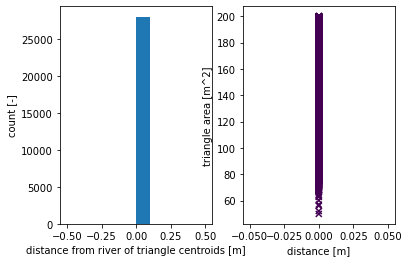

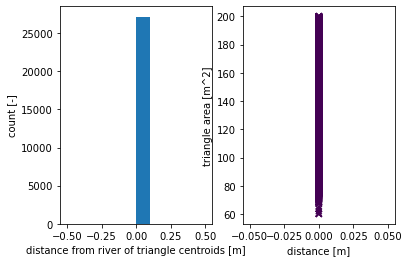

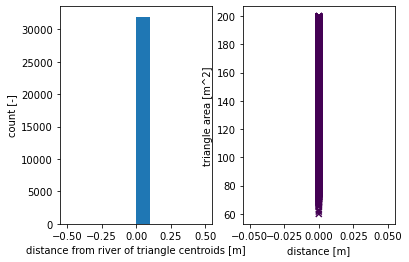

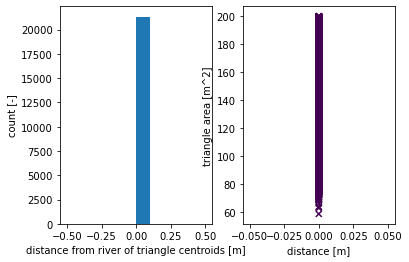

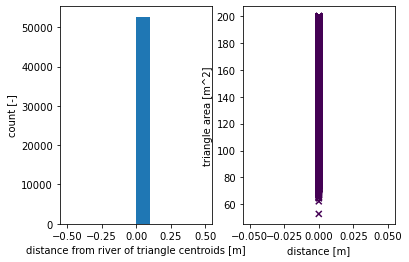

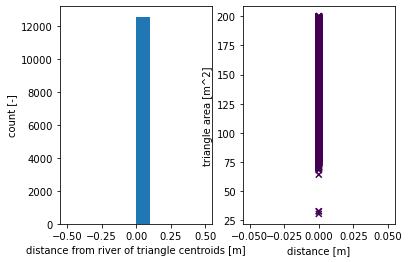

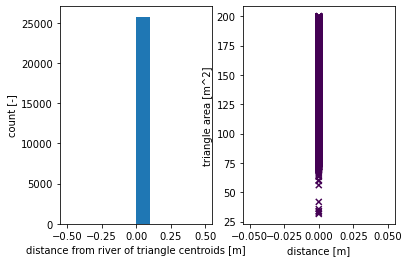

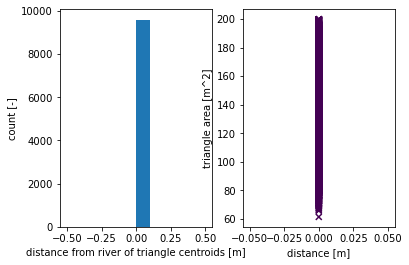

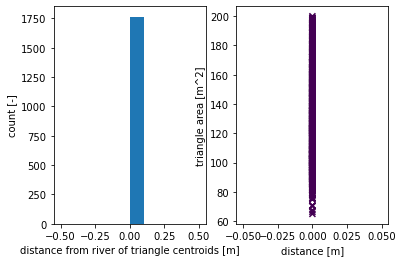

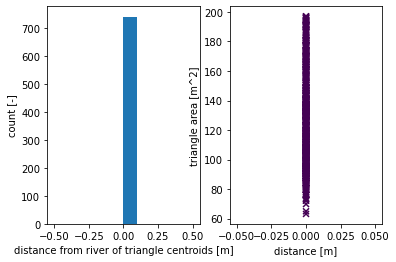

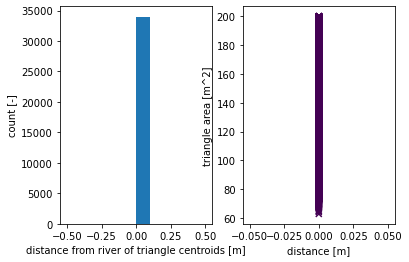

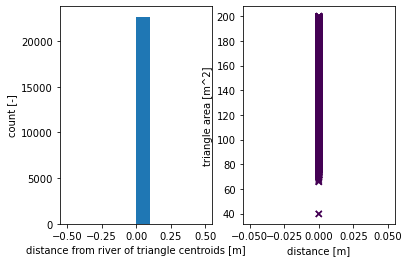

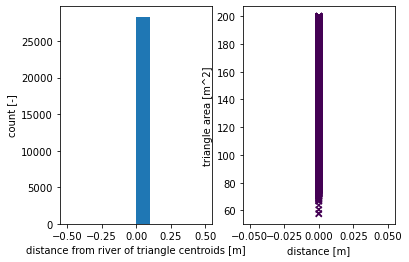

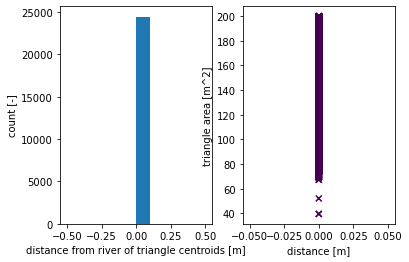

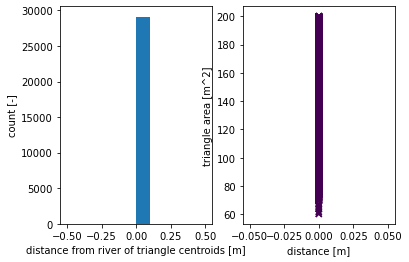

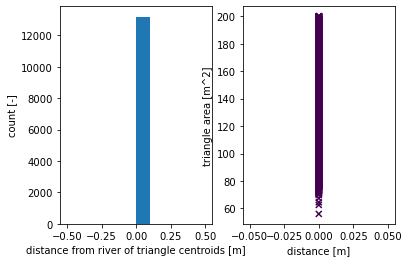

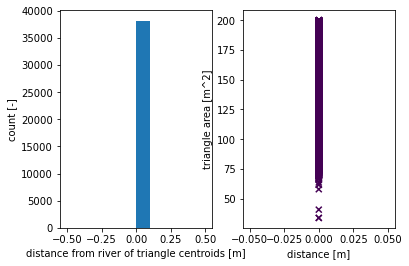

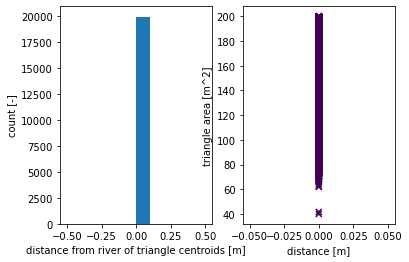

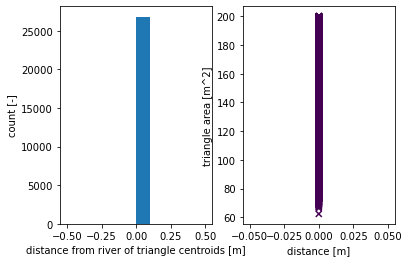

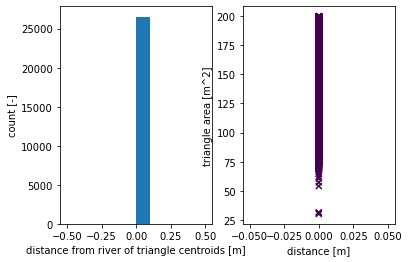

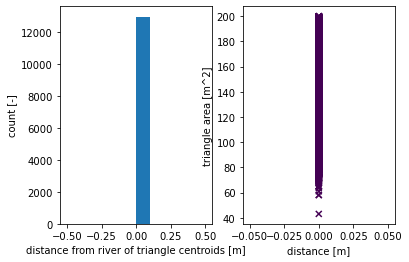

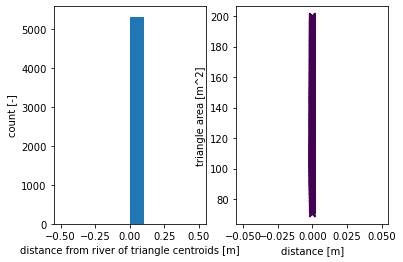

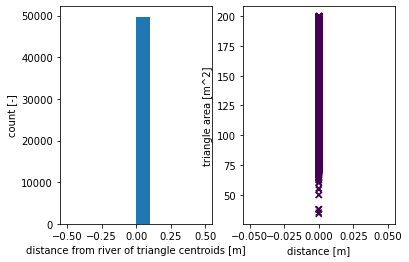

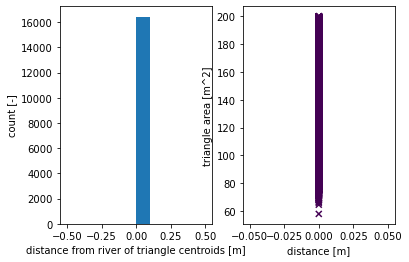

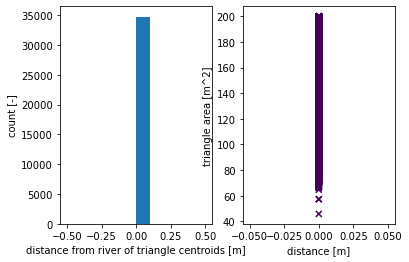

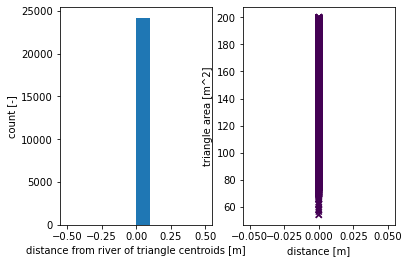

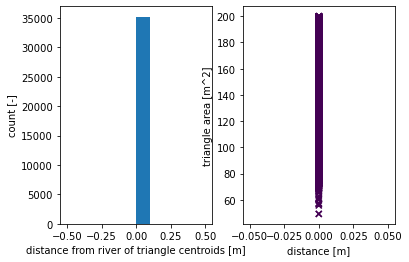

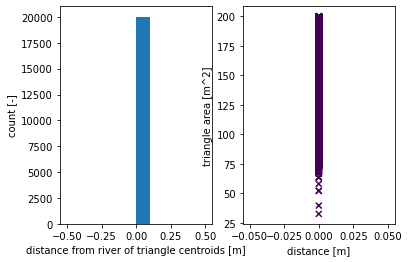

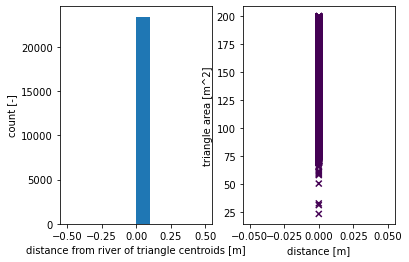

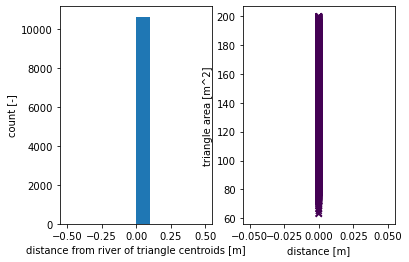

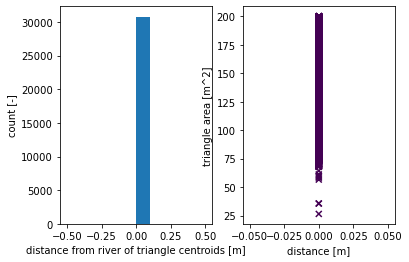

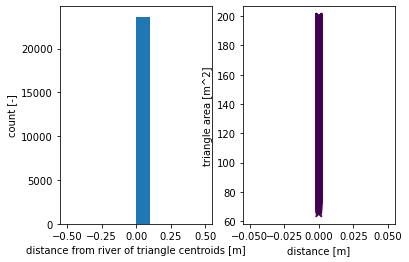

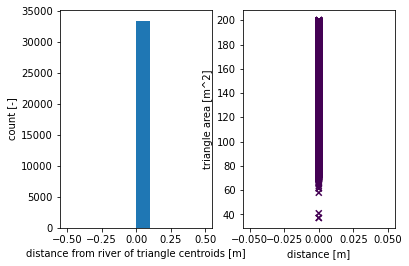

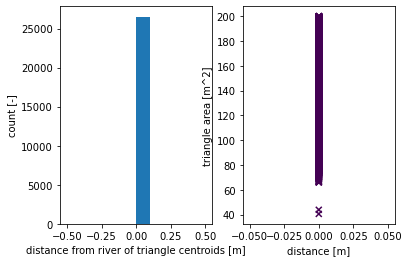

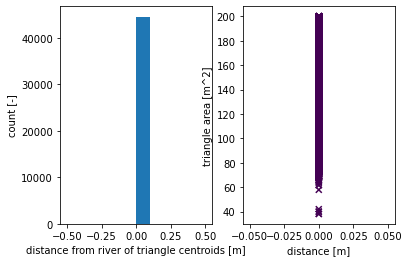

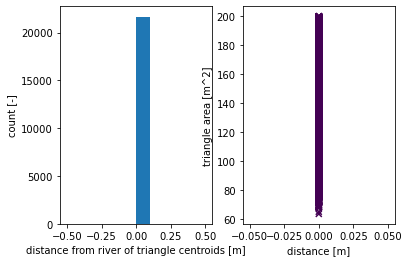

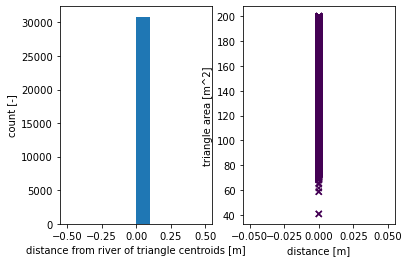

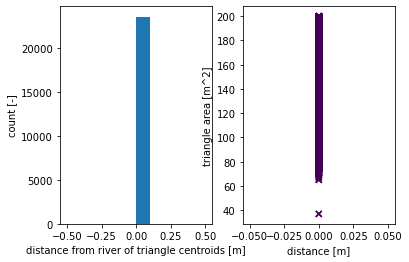

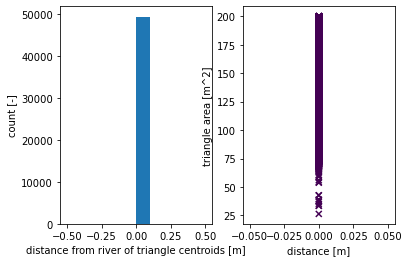

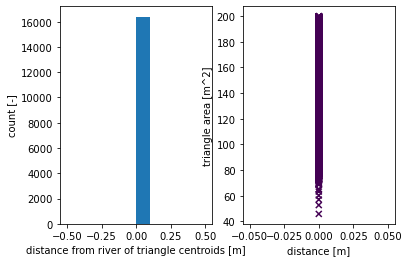

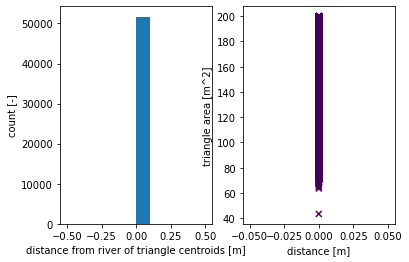

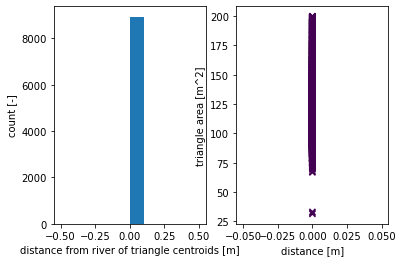

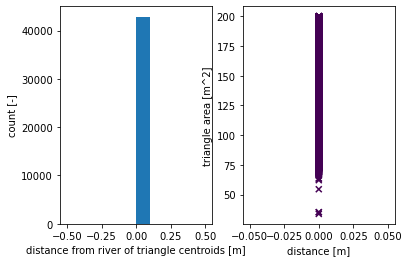

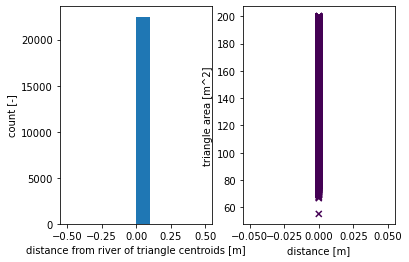

In [24]:
# subcatch_all_ids = np.arange(1, len(subcatchments)+1)
# for subcatch_id in subcatch_all_ids:
#     index = subcatch_id - 1
#     subcatch_smooth = hillslope_pars[index]['subcatchment_smooth']
#     m2, lc = meshing.createSubcatchmentMesh2D(filenames, subcatch_smooth, subcatch_crs,
#                                               mesh_pars[index], plot=False)
#     m3 = meshing.createSubcatchmentMesh3D(m2, lc, layer_info, 
#                                           os.path.join(mesh_dir, f'sag_subcatchment{subcatch_id}.exo'))

# DayMet

## For a given subcatchment

In [25]:
start, end = datetime.date(1980,1,1), datetime.date(2020,12,31)
hillslopes.downloadDaymet(hillslope_demo_pars, daymet_raw_dir, 
                          os.path.join(daymet_dir, f'huc_{huc}_subcatchment{subcatch_demo_id}_'
                          +str(start.year)+'_'+str(end.year)+'.h5'),
                          start, end)

## For all subcatchment

In [26]:
# start, end = datetime.date(1980,1,1), datetime.date(2020,12,31)
# subcatch_all_ids = np.arange(1, len(subcatchments)+1)
# for subcatch_id in subcatch_all_ids:
#     index = subcatch_id - 1
#     hillslopes.downloadDaymet(hillslope_pars[index], daymet_raw_dir, 
#                               os.path.join(daymet_dir, f'huc_{huc}_subcatchment{subcatch_id}_'
#                               +str(start.year)+'_'+str(end.year)+'.h5'),
#                               start, end)